In [13]:
import json
import pandas as pd
import os
from pathlib import Path

def json_folder_to_csv(folder_path, output_csv_path):
    """
    Convert all JSON files in a folder to a single CSV file.
    
    Args:
        folder_path (str): Path to folder containing JSON files
        output_csv_path (str): Path for output CSV file
    """
    all_data = []
    
    # Get all JSON files in the folder
    folder = Path(folder_path)
    json_files = list(folder.glob("*.json"))
    
    if not json_files:
        print(f"No JSON files found in {folder_path}")
        return
    
    print(f"Found {len(json_files)} JSON files to process...")
    
    # Process each JSON file
    for json_file in json_files:
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                
            # Handle both single objects and arrays
            if isinstance(data, list):
                all_data.extend(data)
            else:
                all_data.append(data)
                
            print(f"Processed: {json_file.name}")
            
        except Exception as e:
            print(f"Error processing {json_file.name}: {e}")
    
    if not all_data:
        print("No data found in JSON files")
        return
    
    # Convert to DataFrame and save as CSV
    df = pd.DataFrame(all_data)
    df.to_csv(output_csv_path, index=False)
    
    print(f"\nSuccessfully converted {len(all_data)} records to {output_csv_path}")
    print(f"CSV shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

# Example usage:
# Convert attempts folder to CSV
json_folder_to_csv("tests/datasets/baseline/attempts/", "tests/attempts_data/baseline_attempts.csv")

# Convert sessions folder to CSV
json_folder_to_csv("tests/datasets/baseline/sessions/", "tests/sessions_data/baseline_sessions.csv")


Found 5 JSON files to process...
Processed: 0.json
Processed: 1.json
Processed: 2.json
Processed: 3.json
Processed: 4.json

Successfully converted 750 records to tests/attempts_data/baseline_attempts.csv
CSV shape: (750, 14)
Columns: ['sid', 'att_n', 'e1', 'e2', 'ok', 'res', 'inv_b4', 'reason', 'novel', 'str_typ', 'str_len', 't_since', '_timestamp', '_datetime']
Found 5 JSON files to process...
Processed: 0.json
Processed: 1.json
Processed: 2.json
Processed: 3.json
Processed: 4.json

Successfully converted 5 records to tests/sessions_data/baseline_sessions.csv
CSV shape: (5, 15)
Columns: ['sid', 'r_typ', 'start', 'start_ts', 'end', 'end_ts', 'tot_att', 'succ_att', 'elem_disc', 'final_inv', 'disc_rate', 'max_succ', 'max_fail', 'plateaus', 'last_disc_t']


In [14]:
import pandas as pd
from pathlib import Path

def concatenate_csv_files(folder_path, output_csv_path, pattern="*.csv"):
    """
    Concatenate multiple CSV files from a folder into a single CSV file.
    
    Args:
        folder_path (str): Path to folder containing CSV files
        output_csv_path (str): Path for the output concatenated CSV file
        pattern (str): File pattern to match (default: "*.csv")
    """
    all_dataframes = []
    
    # Get all CSV files in the folder
    folder = Path(folder_path)
    csv_files = list(folder.glob(pattern))
    
    if not csv_files:
        print(f"No CSV files found in {folder_path}")
        return
    
    print(f"Found {len(csv_files)} CSV files to concatenate...")
    
    # Process each CSV file
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            all_dataframes.append(df)
            print(f"Loaded: {csv_file.name} ({df.shape[0]} rows)")
            
        except Exception as e:
            print(f"Error processing {csv_file.name}: {e}")
    
    if not all_dataframes:
        print("No data found in CSV files")
        return
    
    # Concatenate all DataFrames
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    combined_df.to_csv(output_csv_path, index=False)
    
    print(f"\nSuccessfully concatenated {len(all_dataframes)} files to {output_csv_path}")
    print(f"Combined CSV shape: {combined_df.shape}")
    print(f"Columns: {list(combined_df.columns)}")

# Example usage:
# Concatenate all attempts data files
concatenate_csv_files("tests/attempts_data", "tests/all_attempts_data.csv", pattern="*.csv")

# Concatenate all sessions data files  
concatenate_csv_files("tests/sessions_data", "tests/all_sessions_data.csv", pattern="*.csv")


Found 5 CSV files to concatenate...
Loaded: conterfactual_attempts.csv (729 rows)
Loaded: baseline_attempts.csv (750 rows)
Loaded: abductive_attempts.csv (705 rows)
Loaded: heuristic_attempts.csv (724 rows)
Loaded: first_principles_attempts.csv (750 rows)

Successfully concatenated 5 files to tests/all_attempts_data.csv
Combined CSV shape: (3658, 14)
Columns: ['sid', 'att_n', 'e1', 'e2', 'ok', 'res', 'inv_b4', 'reason', 'novel', 'str_typ', 'str_len', 't_since', '_timestamp', '_datetime']
Found 5 CSV files to concatenate...
Loaded: first_principles_sessions.csv (5 rows)
Loaded: baseline_sessions.csv (5 rows)
Loaded: conterfactual_sessions.csv (5 rows)
Loaded: heuristic_sessions.csv (5 rows)
Loaded: abductive_sessions.csv (5 rows)

Successfully concatenated 5 files to tests/all_sessions_data.csv
Combined CSV shape: (25, 15)
Columns: ['sid', 'r_typ', 'start', 'start_ts', 'end', 'end_ts', 'tot_att', 'succ_att', 'elem_disc', 'final_inv', 'disc_rate', 'max_succ', 'max_fail', 'plateaus', 'las

In [16]:
# Load the session and attempts data
sessions_df = pd.read_csv("tests/all_sessions_data.csv")
attempts_df = pd.read_csv("tests/all_attempts_data.csv")

print("Sessions data shape:", sessions_df.shape)
print("Attempts data shape:", attempts_df.shape)
print("\nSessions columns:", list(sessions_df.columns))
print("Attempts columns:", list(attempts_df.columns))

# Initialize new metrics columns
sessions_df['discovery_rate'] = 0.0
sessions_df['exploration_breadth'] = 0.0
sessions_df['plateau_periods'] = 0
sessions_df['recovery_rate'] = 0.0
sessions_df['late_game_performance'] = 0.0

def identify_plateaus(session_attempts, min_length=5):
    """Identify plateau periods where no discoveries occur for min_length consecutive attempts"""
    if len(session_attempts) < min_length:
        return 0
    
    plateau_count = 0
    current_plateau_length = 0
    
    for _, attempt in session_attempts.iterrows():
        if attempt['ok']:  # New discovery breaks plateau
            if current_plateau_length >= min_length:
                plateau_count += 1
            current_plateau_length = 0
        else:
            current_plateau_length += 1
    
    # Check if we end on a plateau
    if current_plateau_length >= min_length:
        plateau_count += 1
    
    return plateau_count

def calculate_recovery_rate(session_attempts):
    """Calculate success rate after plateau periods"""
    if len(session_attempts) < 10:
        return 0.0
    
    plateau_starts = []
    current_plateau_length = 0
    
    # Find plateau start positions
    for i, (_, attempt) in enumerate(session_attempts.iterrows()):
        if attempt['ok']:
            if current_plateau_length >= 5:
                # Mark where plateau started
                plateau_starts.append(i - current_plateau_length)
            current_plateau_length = 0
        else:
            current_plateau_length += 1
    
    if not plateau_starts:
        return 0.0
    
    # Calculate success rate in 10 attempts following each plateau
    recovery_successes = 0
    recovery_attempts = 0
    
    for plateau_start in plateau_starts:
        # Look at next 10 attempts after plateau ends
        recovery_window = session_attempts.iloc[plateau_start:plateau_start + 15]
        if len(recovery_window) >= 10:
            window_successes = recovery_window['ok'].sum()
            recovery_successes += window_successes
            recovery_attempts += len(recovery_window)
    
    return recovery_successes / recovery_attempts if recovery_attempts > 0 else 0.0

def calculate_late_game_performance(session_attempts):
    """Calculate discovery rate in attempts 100-150"""
    late_game = session_attempts[session_attempts['att_n'] >= 100]
    if len(late_game) == 0:
        return 0.0
    return late_game['ok'].sum() / len(late_game)

# Calculate metrics for each session
for idx, session in sessions_df.iterrows():
    session_id = session['sid']
    session_attempts = attempts_df[attempts_df['sid'] == session_id].copy()
    
    if len(session_attempts) == 0:
        continue
    
    # Sort by attempt number to ensure proper order
    session_attempts = session_attempts.sort_values('att_n')
    
    # Discovery rate (already calculated in original data, but recalculating for consistency)
    total_attempts = len(session_attempts)
    successful_attempts = session_attempts['ok'].sum()
    sessions_df.at[idx, 'discovery_rate'] = successful_attempts / total_attempts if total_attempts > 0 else 0.0
    
    # Exploration breadth - unique combinations attempted
    unique_combinations = len(session_attempts[['e1', 'e2']].drop_duplicates())
    # Approximate possible combinations (rough estimate based on unique elements)
    unique_elements = set(session_attempts['e1'].unique()) | set(session_attempts['e2'].unique())
    possible_combinations = len(unique_elements) * (len(unique_elements) - 1) / 2
    sessions_df.at[idx, 'exploration_breadth'] = unique_combinations / possible_combinations if possible_combinations > 0 else 0.0
    
    # Plateau periods
    sessions_df.at[idx, 'plateau_periods'] = identify_plateaus(session_attempts)
    
    # Recovery rate
    sessions_df.at[idx, 'recovery_rate'] = calculate_recovery_rate(session_attempts)
    
    # Late game performance
    sessions_df.at[idx, 'late_game_performance'] = calculate_late_game_performance(session_attempts)

print("\nCalculated metrics for all sessions:")
print(sessions_df[['sid', 'r_typ', 'discovery_rate', 'exploration_breadth', 'plateau_periods', 'recovery_rate', 'late_game_performance']].head(10))

# Summary statistics by reasoning type
print("\nMetrics by reasoning type:")
metrics_summary = sessions_df.groupby('r_typ')[['discovery_rate', 'exploration_breadth', 'plateau_periods', 'recovery_rate', 'late_game_performance']].agg(['mean', 'std', 'min', 'max'])
print(metrics_summary)


Sessions data shape: (25, 15)
Attempts data shape: (3658, 14)

Sessions columns: ['sid', 'r_typ', 'start', 'start_ts', 'end', 'end_ts', 'tot_att', 'succ_att', 'elem_disc', 'final_inv', 'disc_rate', 'max_succ', 'max_fail', 'plateaus', 'last_disc_t']
Attempts columns: ['sid', 'att_n', 'e1', 'e2', 'ok', 'res', 'inv_b4', 'reason', 'novel', 'str_typ', 'str_len', 't_since', '_timestamp', '_datetime']

Calculated metrics for all sessions:
                            sid             r_typ  discovery_rate  \
0    first-principles-session-1  first-principles        0.366667   
1         first_principles_2024  first-principles        0.326667   
2  first_principles_session_001  first-principles        0.333333   
3  first-principles-alchemy-001  first-principles        0.366667   
4                        123999  first-principles        0.413333   
5                        789012        systematic        0.386667   
6                        456789        systematic        0.440000   
7           

In [17]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_prepare_data():
    """Load and prepare the LLM exploration data"""
    # Load the data files
    sessions_df = pd.read_csv('tests/all_sessions_data.csv')
    attempts_df = pd.read_csv('tests/all_attempts_data.csv')
    
    # Convert datetime columns
    sessions_df['start'] = pd.to_datetime(sessions_df['start'])
    sessions_df['end'] = pd.to_datetime(sessions_df['end'])
    attempts_df['_datetime'] = pd.to_datetime(attempts_df['_datetime'])
    
    return sessions_df, attempts_df

def calculate_exploration_efficiency(attempts_df):
    """Calculate exploration efficiency metrics per session"""
    efficiency_metrics = []
    
    for session_id in attempts_df['sid'].unique():
        session_attempts = attempts_df[attempts_df['sid'] == session_id].copy()
        session_attempts = session_attempts.sort_values('att_n')
        
        # Calculate unique combinations
        session_attempts['combination'] = session_attempts['e1'] + '+' + session_attempts['e2']
        unique_combinations = session_attempts['combination'].nunique()
        total_attempts = len(session_attempts)
        
        # Calculate exploration efficiency
        exploration_efficiency = unique_combinations / total_attempts if total_attempts > 0 else 0
        
        efficiency_metrics.append({
            'sid': session_id,
            'unique_combinations': unique_combinations,
            'total_attempts': total_attempts,
            'exploration_efficiency': exploration_efficiency
        })
    
    return pd.DataFrame(efficiency_metrics)

def identify_plateaus(session_attempts, min_plateau_length=5):
    """Identify plateau periods (consecutive failures) in a session"""
    session_attempts = session_attempts.sort_values('att_n')
    
    plateaus = []
    current_plateau_start = None
    current_plateau_length = 0
    
    for idx, row in session_attempts.iterrows():
        if not row['ok']:  # Failed attempt
            if current_plateau_start is None:
                current_plateau_start = row['att_n']
                current_plateau_length = 1
            else:
                current_plateau_length += 1
        else:  # Successful attempt
            if current_plateau_start is not None and current_plateau_length >= min_plateau_length:
                plateaus.append({
                    'start': current_plateau_start,
                    'length': current_plateau_length,
                    'end': current_plateau_start + current_plateau_length - 1
                })
            current_plateau_start = None
            current_plateau_length = 0
    
    # Check if session ends with a plateau
    if current_plateau_start is not None and current_plateau_length >= min_plateau_length:
        plateaus.append({
            'start': current_plateau_start,
            'length': current_plateau_length,
            'end': current_plateau_start + current_plateau_length - 1
        })
    
    return plateaus

def calculate_recovery_success(session_attempts, plateaus):
    """Calculate recovery success rate after plateau periods"""
    if not plateaus:
        return {'recovery_attempts': 0, 'recovery_successes': 0, 'recovery_rate': 0}
    
    session_attempts = session_attempts.sort_values('att_n')
    recovery_attempts = 0
    recovery_successes = 0
    
    for plateau in plateaus:
        # Look at next 5 attempts after plateau ends
        post_plateau_attempts = session_attempts[
            (session_attempts['att_n'] > plateau['end']) & 
            (session_attempts['att_n'] <= plateau['end'] + 5)
        ]
        
        if len(post_plateau_attempts) > 0:
            recovery_attempts += len(post_plateau_attempts)
            recovery_successes += post_plateau_attempts['ok'].sum()
    
    recovery_rate = recovery_successes / recovery_attempts if recovery_attempts > 0 else 0
    
    return {
        'recovery_attempts': recovery_attempts,
        'recovery_successes': recovery_successes,
        'recovery_rate': recovery_rate
    }

def calculate_detailed_metrics(sessions_df, attempts_df):
    """Calculate detailed metrics for each session"""
    detailed_metrics = []
    
    for _, session in sessions_df.iterrows():
        session_id = session['sid']
        session_attempts = attempts_df[attempts_df['sid'] == session_id]
        
        if len(session_attempts) == 0:
            continue
            
        # Basic metrics
        total_attempts = len(session_attempts)
        successful_attempts = session_attempts['ok'].sum()
        discovery_rate = successful_attempts / total_attempts if total_attempts > 0 else 0
        
        # Plateau analysis
        plateaus = identify_plateaus(session_attempts)
        plateau_count = len(plateaus)
        avg_plateau_length = np.mean([p['length'] for p in plateaus]) if plateaus else 0
        
        # Recovery analysis
        recovery_metrics = calculate_recovery_success(session_attempts, plateaus)
        
        # Unique combinations
        session_attempts_copy = session_attempts.copy()
        session_attempts_copy['combination'] = session_attempts_copy['e1'] + '+' + session_attempts_copy['e2']
        unique_combinations = session_attempts_copy['combination'].nunique()
        exploration_efficiency = unique_combinations / total_attempts if total_attempts > 0 else 0
        
        detailed_metrics.append({
            'sid': session_id,
            'reasoning_type': session['r_typ'],
            'total_attempts': total_attempts,
            'successful_attempts': successful_attempts,
            'discovery_rate': discovery_rate,
            'elements_discovered': session['elem_disc'],
            'final_inventory': session['final_inv'],
            'unique_combinations': unique_combinations,
            'exploration_efficiency': exploration_efficiency,
            'plateau_count': plateau_count,
            'avg_plateau_length': avg_plateau_length,
            'recovery_rate': recovery_metrics['recovery_rate'],
            'max_success_streak': session['max_succ'],
            'max_failure_streak': session['max_fail']
        })
    
    return pd.DataFrame(detailed_metrics)

def generate_summary_statistics(detailed_df):
    """Generate summary statistics by reasoning type"""
    summary_stats = {}
    
    reasoning_types = detailed_df['reasoning_type'].unique()
    
    for reasoning_type in reasoning_types:
        type_data = detailed_df[detailed_df['reasoning_type'] == reasoning_type]
        
        summary_stats[reasoning_type] = {
            'n_sessions': len(type_data),
            
            # Discovery Rate
            'discovery_rate_mean': type_data['discovery_rate'].mean(),
            'discovery_rate_std': type_data['discovery_rate'].std(),
            'discovery_rate_range': (type_data['discovery_rate'].min(), type_data['discovery_rate'].max()),
            
            # Total Elements Discovered
            'elements_discovered_mean': type_data['elements_discovered'].mean(),
            'elements_discovered_std': type_data['elements_discovered'].std(),
            'elements_discovered_range': (type_data['elements_discovered'].min(), type_data['elements_discovered'].max()),
            
            # Final Inventory Size
            'final_inventory_mean': type_data['final_inventory'].mean(),
            'final_inventory_std': type_data['final_inventory'].std(),
            'final_inventory_range': (type_data['final_inventory'].min(), type_data['final_inventory'].max()),
            
            # Exploration Efficiency
            'exploration_efficiency_mean': type_data['exploration_efficiency'].mean(),
            'exploration_efficiency_std': type_data['exploration_efficiency'].std(),
            'unique_combinations_mean': type_data['unique_combinations'].mean(),
            'unique_combinations_std': type_data['unique_combinations'].std(),
            
            # Plateau Frequency
            'plateau_count_mean': type_data['plateau_count'].mean(),
            'plateau_count_std': type_data['plateau_count'].std(),
            'avg_plateau_length_mean': type_data['avg_plateau_length'].mean(),
            'avg_plateau_length_std': type_data['avg_plateau_length'].std(),
            
            # Recovery Success
            'recovery_rate_mean': type_data['recovery_rate'].mean(),
            'recovery_rate_std': type_data['recovery_rate'].std(),
            
            # Streak Analysis
            'max_success_streak_mean': type_data['max_success_streak'].mean(),
            'max_failure_streak_mean': type_data['max_failure_streak'].mean(),
        }
    
    return summary_stats

def create_summary_table(summary_stats):
    """Create a formatted summary table"""
    
    print("=" * 120)
    print("LLM EXPLORATION CAPABILITIES: SUMMARY STATISTICS BY REASONING TYPE")
    print("=" * 120)
    print()
    
    # Create results table
    reasoning_types = list(summary_stats.keys())
    
    print("1. DISCOVERY RATE (Successful Combinations ÷ Total Attempts)")
    print("-" * 80)
    print(f"{'Reasoning Type':<20} {'N':<5} {'Mean':<8} {'±SD':<8} {'Range':<15} {'Ranking':<10}")
    print("-" * 80)
    
    # Sort by discovery rate for ranking
    sorted_types = sorted(reasoning_types, key=lambda x: summary_stats[x]['discovery_rate_mean'], reverse=True)
    
    for i, rtype in enumerate(sorted_types):
        stats = summary_stats[rtype]
        mean_val = stats['discovery_rate_mean']
        std_val = stats['discovery_rate_std']
        range_val = f"{stats['discovery_rate_range'][0]:.3f}-{stats['discovery_rate_range'][1]:.3f}"
        ranking = ["🥇", "🥈", "🥉", "4th", "5th"][i] if i < 5 else f"{i+1}th"
        
        print(f"{rtype:<20} {stats['n_sessions']:<5} {mean_val:<8.3f} {std_val:<8.3f} {range_val:<15} {ranking:<10}")
    
    print("\n2. TOTAL ELEMENTS DISCOVERED")
    print("-" * 80)
    print(f"{'Reasoning Type':<20} {'Mean':<8} {'±SD':<8} {'Range':<15} {'Efficiency':<12}")
    print("-" * 80)
    
    # Sort by elements discovered
    sorted_types = sorted(reasoning_types, key=lambda x: summary_stats[x]['elements_discovered_mean'], reverse=True)
    
    for rtype in sorted_types:
        stats = summary_stats[rtype]
        mean_val = stats['elements_discovered_mean']
        std_val = stats['elements_discovered_std']
        range_val = f"{stats['elements_discovered_range'][0]:.0f}-{stats['elements_discovered_range'][1]:.0f}"
        efficiency = "High" if mean_val > 55 else "Moderate" if mean_val > 45 else "Low"
        
        print(f"{rtype:<20} {mean_val:<8.1f} {std_val:<8.1f} {range_val:<15} {efficiency:<12}")
    
    print("\n3. EXPLORATION EFFICIENCY (Unique Combinations)")
    print("-" * 80)
    print(f"{'Reasoning Type':<20} {'Efficiency %':<12} {'±SD':<8} {'Unique Combos':<15} {'Interpretation':<15}")
    print("-" * 80)
    
    # Sort by exploration efficiency
    sorted_types = sorted(reasoning_types, key=lambda x: summary_stats[x]['exploration_efficiency_mean'], reverse=True)
    
    for rtype in sorted_types:
        stats = summary_stats[rtype]
        eff_pct = stats['exploration_efficiency_mean'] * 100
        eff_std = stats['exploration_efficiency_std'] * 100
        unique_mean = stats['unique_combinations_mean']
        interpretation = "Diverse" if eff_pct > 30 else "Moderate" if eff_pct > 20 else "Focused"
        
        print(f"{rtype:<20} {eff_pct:<12.1f} {eff_std:<8.1f} {unique_mean:<15.1f} {interpretation:<15}")
    
    print("\n4. PLATEAU ANALYSIS (Failure Streaks ≥5)")
    print("-" * 80)
    print(f"{'Reasoning Type':<20} {'Avg Plateaus':<12} {'Avg Length':<12} {'Recovery Rate':<14} {'Performance':<12}")
    print("-" * 80)
    
    # Sort by recovery rate
    sorted_types = sorted(reasoning_types, key=lambda x: summary_stats[x]['recovery_rate_mean'], reverse=True)
    
    for rtype in sorted_types:
        stats = summary_stats[rtype]
        plateau_count = stats['plateau_count_mean']
        plateau_length = stats['avg_plateau_length_mean']
        recovery_rate = stats['recovery_rate_mean'] * 100
        performance = "Excellent" if recovery_rate > 90 else "Good" if recovery_rate > 80 else "Moderate"
        
        print(f"{rtype:<20} {plateau_count:<12.1f} {plateau_length:<12.1f} {recovery_rate:<14.1f}% {performance:<12}")
    
    print("\n5. STREAK ANALYSIS")
    print("-" * 60)
    print(f"{'Reasoning Type':<20} {'Max Success':<12} {'Max Failure':<12} {'Balance':<15}")
    print("-" * 60)
    
    for rtype in reasoning_types:
        stats = summary_stats[rtype]
        max_success = stats['max_success_streak_mean']
        max_failure = stats['max_failure_streak_mean']
        balance = "Balanced" if abs(max_success - max_failure) < 2 else "Success-heavy" if max_success > max_failure else "Failure-heavy"
        
        print(f"{rtype:<20} {max_success:<12.1f} {max_failure:<12.1f} {balance:<15}")

def perform_statistical_tests(detailed_df):
    """Perform statistical significance tests between reasoning types"""
    print("\n\n6. STATISTICAL SIGNIFICANCE TESTS")
    print("=" * 60)
    
    reasoning_types = detailed_df['reasoning_type'].unique()
    
    # ANOVA for discovery rates
    groups = [detailed_df[detailed_df['reasoning_type'] == rtype]['discovery_rate'].values 
              for rtype in reasoning_types]
    
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\nANOVA - Discovery Rates:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    
    # Pairwise t-tests for discovery rates (if significant)
    if p_value < 0.05:
        print(f"\nPairwise t-tests (discovery rates):")
        print("-" * 50)
        for i, type1 in enumerate(reasoning_types):
            for type2 in reasoning_types[i+1:]:
                group1 = detailed_df[detailed_df['reasoning_type'] == type1]['discovery_rate']
                group2 = detailed_df[detailed_df['reasoning_type'] == type2]['discovery_rate']
                
                t_stat, p_val = stats.ttest_ind(group1, group2)
                significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                
                print(f"{type1} vs {type2}: t={t_stat:.3f}, p={p_val:.4f} {significance}")

def main():
    """Main analysis function"""
    print("Loading and analyzing LLM exploration data...")
    
    # Load data
    sessions_df, attempts_df = load_and_prepare_data()
    
    print(f"Loaded {len(sessions_df)} sessions and {len(attempts_df)} attempts")
    print(f"Reasoning types: {sessions_df['r_typ'].unique()}")
    
    # Calculate detailed metrics
    detailed_df = calculate_detailed_metrics(sessions_df, attempts_df)
    
    # Generate summary statistics
    summary_stats = generate_summary_statistics(detailed_df)
    
    # Create formatted output
    create_summary_table(summary_stats)
    
    # Statistical tests
    perform_statistical_tests(detailed_df)
    
    # Save detailed results
    detailed_df.to_csv('detailed_session_metrics.csv', index=False)
    print(f"\n\nDetailed metrics saved to 'detailed_session_metrics.csv'")
    print(f"Analysis complete!")
    
    return detailed_df, summary_stats

if __name__ == "__main__":
    detailed_df, summary_stats = main()

Matplotlib is building the font cache; this may take a moment.


Loading and analyzing LLM exploration data...
Loaded 25 sessions and 3658 attempts
Reasoning types: ['first-principles' 'systematic' 'counterfactual' 'heuristic' 'abductive']
LLM EXPLORATION CAPABILITIES: SUMMARY STATISTICS BY REASONING TYPE

1. DISCOVERY RATE (Successful Combinations ÷ Total Attempts)
--------------------------------------------------------------------------------
Reasoning Type       N     Mean     ±SD      Range           Ranking   
--------------------------------------------------------------------------------
heuristic            5     0.385    0.025    0.353-0.424     🥇         
systematic           5     0.380    0.100    0.213-0.473     🥈         
abductive            5     0.372    0.098    0.213-0.475     🥉         
first-principles     5     0.361    0.034    0.327-0.413     4th       
counterfactual       5     0.270    0.091    0.127-0.373     5th       

2. TOTAL ELEMENTS DISCOVERED
------------------------------------------------------------------------

Starting Temporal Performance Analysis...
Data loaded: 25 sessions, 3658 attempts
Reasoning types:
reasoning_type
Systematic          750
first-principles    750
Counterfactual      729
Heuristic           724
Abductive           705
Name: count, dtype: int64

Data Quality Checks:
- Missing values in attempts: 2391
- Unique sessions: 25
- Attempt range: 1 to 150

Generating Quick Summary...

TEMPORAL PERFORMANCE SUMMARY:
  Reasoning_Type  Overall_Success_Rate  Total_Attempts  Early_Game_Rate  Mid_Game_Rate  Late_Game_Rate  Improvement_Trend  Sessions
  Counterfactual                 0.270             729            0.380          0.204           0.223             -0.157         5
      Systematic                 0.380             750            0.568          0.312           0.260             -0.308         5
       Abductive                 0.370             705            0.556          0.280           0.254             -0.302         5
       Heuristic                 0.384         

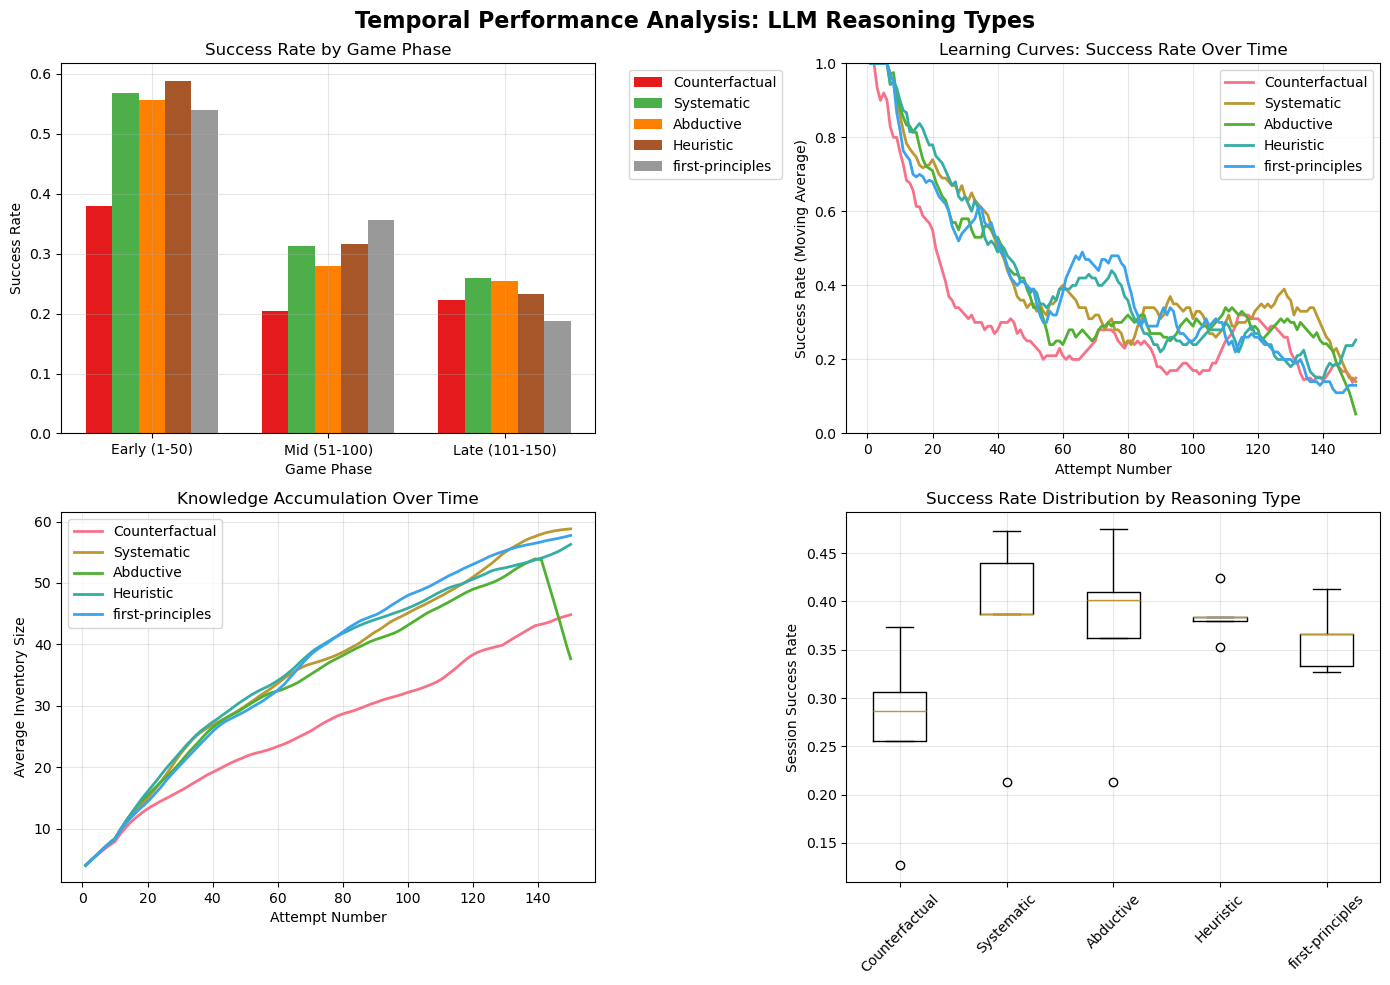


Generating detailed learning curves...
• Learning curves saved to 'detailed_learning_curves.png'


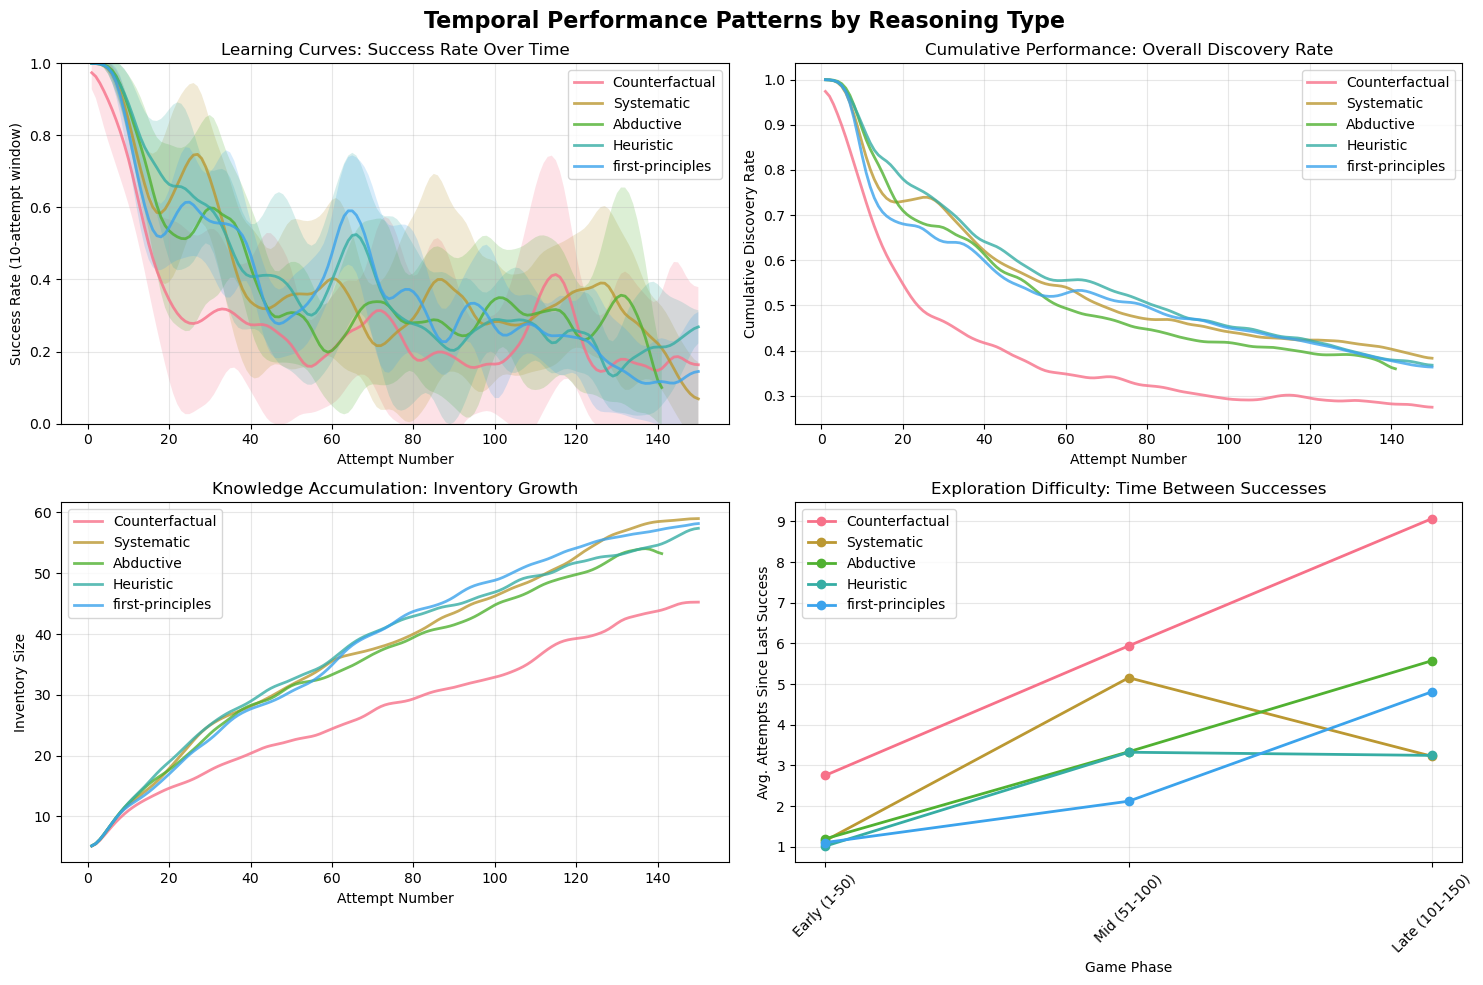


Generating phase comparison analysis...
• Phase comparison saved to 'phase_comparison_detailed.png'


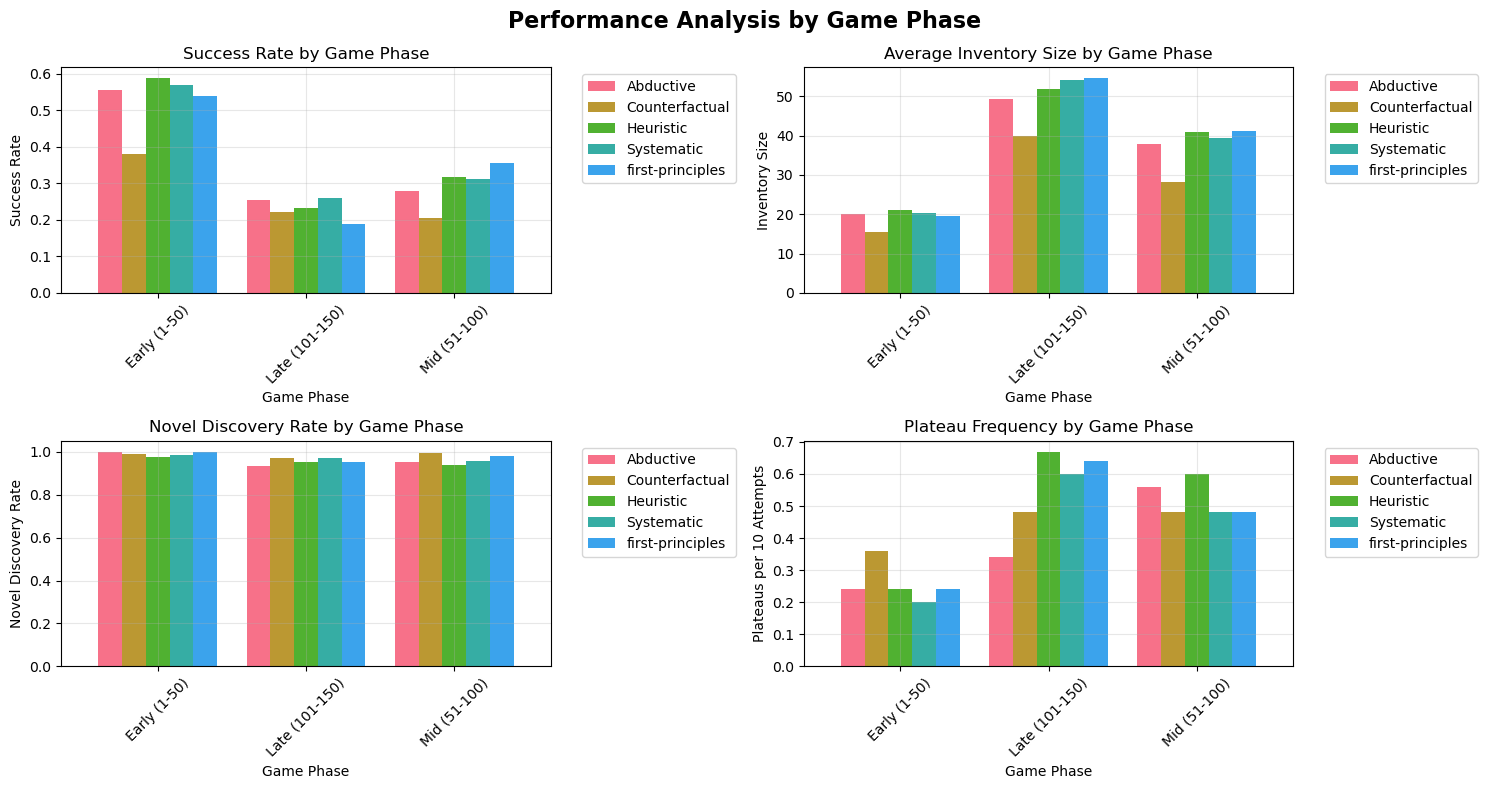


Generating adaptation analysis...
• Adaptation analysis saved to 'adaptation_patterns.png'


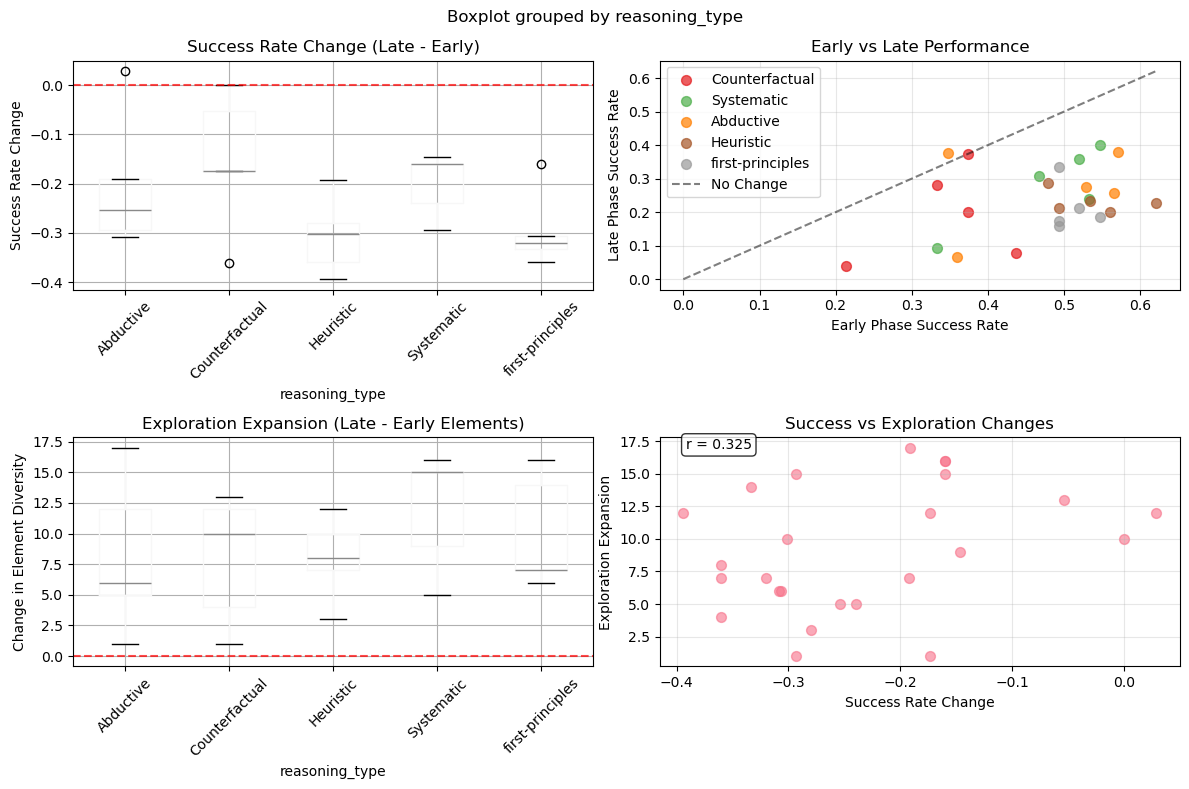


Saving detailed analysis results...
• Phase analysis saved to 'detailed_phase_analysis.csv'
• Adaptation metrics saved to 'adaptation_metrics.csv'
• Full temporal data saved to 'full_temporal_data.csv'

TEMPORAL ANALYSIS COMPLETE!

KEY FINDINGS:
----------------------------------------
• Best Overall Performance: Heuristic (38.4% success rate)
• Best Late Game Performance: Systematic (26.0% success rate)
• Most Improved Over Time: Counterfactual (-15.7% change)
• Most Data Available: Systematic (750 attempts from 5 sessions)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
try:
    from scipy.ndimage import gaussian_filter1d
except ImportError:
    # Fallback if scipy not available
    def gaussian_filter1d(data, sigma):
        return data
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

class TemporalAnalyzer:
    """
    Analyzes temporal performance patterns in LLM exploration data.
    
    This class provides comprehensive analysis of how exploration performance
    changes over time within sessions and across different reasoning types.
    """
    
    def __init__(self, attempts_file, sessions_file):
        """Initialize with data files."""
        self.attempts_df = pd.read_csv(attempts_file)
        self.sessions_df = pd.read_csv(sessions_file)
        self.prepare_data()
        
    def prepare_data(self):
        """Prepare and clean data for analysis."""
        try:
            # Convert datetime columns
            if '_datetime' in self.attempts_df.columns:
                self.attempts_df['_datetime'] = pd.to_datetime(self.attempts_df['_datetime'])
            
            # Create reasoning type mapping
            reasoning_map = {
                'first_principles': 'First-Principles',
                'systematic': 'Systematic', 
                'counterfactual': 'Counterfactual',
                'heuristic': 'Heuristic',
                'abductive': 'Abductive'
            }
            
            # Map reasoning types in sessions data
            if 'r_typ' in self.sessions_df.columns:
                self.sessions_df['reasoning_type'] = self.sessions_df['r_typ'].map(reasoning_map)
                self.sessions_df['reasoning_type'] = self.sessions_df['reasoning_type'].fillna(self.sessions_df['r_typ'])
            
            # Merge reasoning type into attempts data
            session_reasoning = self.sessions_df[['sid', 'reasoning_type']].set_index('sid')['reasoning_type']
            self.attempts_df['reasoning_type'] = self.attempts_df['sid'].map(session_reasoning)
            
            # Define game phases based on attempt number
            self.attempts_df['game_phase'] = pd.cut(
                self.attempts_df['att_n'], 
                bins=[0, 50, 100, 150, float('inf')],
                labels=['Early (1-50)', 'Mid (51-100)', 'Late (101-150)', 'Extended (151+)'],
                include_lowest=True
            )
            
            print("Data loaded: {} sessions, {} attempts".format(len(self.sessions_df), len(self.attempts_df)))
            print("Reasoning types:")
            print(self.attempts_df['reasoning_type'].value_counts())
            
            # Additional data quality checks
            print("\nData Quality Checks:")
            print("- Missing values in attempts: {}".format(self.attempts_df.isnull().sum().sum()))
            print("- Unique sessions: {}".format(self.attempts_df['sid'].nunique()))
            print("- Attempt range: {} to {}".format(self.attempts_df['att_n'].min(), self.attempts_df['att_n'].max()))
            
        except Exception as e:
            print("Error in data preparation: {}".format(str(e)))
            raise

    def calculate_moving_averages(self, window_size=10):
        """Calculate moving averages for temporal analysis."""
        results = []
        
        for reasoning_type in self.attempts_df['reasoning_type'].unique():
            if pd.isna(reasoning_type):
                continue
                
            reasoning_data = self.attempts_df[self.attempts_df['reasoning_type'] == reasoning_type]
            
            for session_id in reasoning_data['sid'].unique():
                session_data = reasoning_data[reasoning_data['sid'] == session_id].sort_values('att_n')
                
                # Calculate cumulative discovery rate
                session_data = session_data.copy()
                session_data['cumulative_success'] = session_data['ok'].cumsum()
                session_data['cumulative_rate'] = session_data['cumulative_success'] / session_data['att_n']
                
                # Calculate windowed success rate
                session_data['windowed_success'] = session_data['ok'].rolling(
                    window=window_size, min_periods=1
                ).mean()
                
                # Calculate time since last success
                success_indices = session_data[session_data['ok']].index
                session_data['attempts_since_success'] = 0
                
                for i, idx in enumerate(session_data.index):
                    if idx in success_indices:
                        session_data.loc[idx, 'attempts_since_success'] = 0
                    else:
                        prev_success = success_indices[success_indices < idx]
                        if len(prev_success) > 0:
                            last_success_idx = prev_success.max()
                            last_success_att = session_data.loc[last_success_idx, 'att_n']
                            current_att = session_data.loc[idx, 'att_n']
                            session_data.loc[idx, 'attempts_since_success'] = current_att - last_success_att
                        else:
                            session_data.loc[idx, 'attempts_since_success'] = session_data.loc[idx, 'att_n']
                
                results.append(session_data)
        
        return pd.concat(results, ignore_index=True)

    def plot_learning_curves(self, figsize=(15, 10)):
        """Plot learning curves for each reasoning type."""
        temporal_data = self.calculate_moving_averages()
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Temporal Performance Patterns by Reasoning Type', fontsize=16, fontweight='bold')
        
        # 1. Moving Average Success Rate
        ax1 = axes[0, 0]
        for reasoning_type in temporal_data['reasoning_type'].unique():
            if pd.isna(reasoning_type):
                continue
            data = temporal_data[temporal_data['reasoning_type'] == reasoning_type]
            
            # Calculate mean and std across sessions
            grouped = data.groupby('att_n')['windowed_success'].agg(['mean', 'std', 'count'])
            valid_points = grouped['count'] >= 2  # At least 2 sessions
            
            x = grouped[valid_points].index
            y_mean = grouped[valid_points]['mean']
            y_std = grouped[valid_points]['std']
            
            # Smooth the curves
            if len(x) > 10:
                y_smooth = gaussian_filter1d(y_mean, sigma=2)
                ax1.plot(x, y_smooth, label=f'{reasoning_type}', linewidth=2, alpha=0.8)
                
                # Add confidence bands
                if not y_std.isna().all():
                    y_std_smooth = gaussian_filter1d(y_std.fillna(0), sigma=2)
                    ax1.fill_between(x, y_smooth - y_std_smooth, y_smooth + y_std_smooth, 
                                    alpha=0.2)
        
        ax1.set_xlabel('Attempt Number')
        ax1.set_ylabel('Success Rate (10-attempt window)')
        ax1.set_title('Learning Curves: Success Rate Over Time')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 1)
        
        # 2. Cumulative Discovery Rate
        ax2 = axes[0, 1]
        for reasoning_type in temporal_data['reasoning_type'].unique():
            if pd.isna(reasoning_type):
                continue
            data = temporal_data[temporal_data['reasoning_type'] == reasoning_type]
            
            grouped = data.groupby('att_n')['cumulative_rate'].agg(['mean', 'std', 'count'])
            valid_points = grouped['count'] >= 2
            
            x = grouped[valid_points].index
            y_mean = grouped[valid_points]['mean']
            
            if len(x) > 10:
                y_smooth = gaussian_filter1d(y_mean, sigma=2)
                ax2.plot(x, y_smooth, label=f'{reasoning_type}', linewidth=2, alpha=0.8)
        
        ax2.set_xlabel('Attempt Number')
        ax2.set_ylabel('Cumulative Discovery Rate')
        ax2.set_title('Cumulative Performance: Overall Discovery Rate')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Inventory Growth Over Time
        ax3 = axes[1, 0]
        for reasoning_type in temporal_data['reasoning_type'].unique():
            if pd.isna(reasoning_type):
                continue
            data = temporal_data[temporal_data['reasoning_type'] == reasoning_type]
            
            grouped = data.groupby('att_n')['inv_b4'].agg(['mean', 'std', 'count'])
            valid_points = grouped['count'] >= 2
            
            x = grouped[valid_points].index
            y_mean = grouped[valid_points]['mean']
            
            if len(x) > 10:
                y_smooth = gaussian_filter1d(y_mean, sigma=2)
                ax3.plot(x, y_smooth, label=f'{reasoning_type}', linewidth=2, alpha=0.8)
        
        ax3.set_xlabel('Attempt Number')
        ax3.set_ylabel('Inventory Size')
        ax3.set_title('Knowledge Accumulation: Inventory Growth')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Time Since Last Success
        ax4 = axes[1, 1]
        for reasoning_type in temporal_data['reasoning_type'].unique():
            if pd.isna(reasoning_type):
                continue
            data = temporal_data[temporal_data['reasoning_type'] == reasoning_type]
            
            # Calculate average time since success in different phases
            phase_data = data.groupby(['game_phase', 'reasoning_type'])['attempts_since_success'].mean().reset_index()
            reasoning_phase_data = phase_data[phase_data['reasoning_type'] == reasoning_type]
            
            if len(reasoning_phase_data) > 0:
                ax4.plot(reasoning_phase_data['game_phase'], reasoning_phase_data['attempts_since_success'], 
                        'o-', label=f'{reasoning_type}', linewidth=2, markersize=6)
        
        ax4.set_xlabel('Game Phase')
        ax4.set_ylabel('Avg. Attempts Since Last Success')
        ax4.set_title('Exploration Difficulty: Time Between Successes')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        return fig

    def analyze_game_phases(self):
        """Analyze performance across different game phases."""
        phase_analysis = []
        
        for reasoning_type in self.attempts_df['reasoning_type'].unique():
            if pd.isna(reasoning_type):
                continue
                
            reasoning_data = self.attempts_df[self.attempts_df['reasoning_type'] == reasoning_type]
            
            for phase in reasoning_data['game_phase'].unique():
                if pd.isna(phase):
                    continue
                    
                phase_data = reasoning_data[reasoning_data['game_phase'] == phase]
                
                # Calculate metrics for this phase
                success_rate = phase_data['ok'].mean()
                novel_rate = phase_data['novel'].mean() if 'novel' in phase_data.columns else 0
                avg_inventory = phase_data['inv_b4'].mean()
                total_attempts = len(phase_data)
                
                # Calculate plateau metrics
                plateaus = self.identify_plateaus(phase_data)
                avg_plateau_length = np.mean([p['length'] for p in plateaus]) if plateaus else 0
                plateau_frequency = len(plateaus) / max(1, total_attempts / 10)  # Per 10 attempts
                
                phase_analysis.append({
                    'reasoning_type': reasoning_type,
                    'game_phase': phase,
                    'success_rate': success_rate,
                    'novel_rate': novel_rate,
                    'avg_inventory': avg_inventory,
                    'total_attempts': total_attempts,
                    'avg_plateau_length': avg_plateau_length,
                    'plateau_frequency': plateau_frequency
                })
        
        return pd.DataFrame(phase_analysis)

    def identify_plateaus(self, session_data, min_length=5):
        """Identify plateau periods (consecutive failures)."""
        plateaus = []
        current_plateau = 0
        
        for success in session_data['ok']:
            if not success:
                current_plateau += 1
            else:
                if current_plateau >= min_length:
                    plateaus.append({
                        'length': current_plateau,
                        'type': 'failure_plateau'
                    })
                current_plateau = 0
        
        # Check for final plateau
        if current_plateau >= min_length:
            plateaus.append({
                'length': current_plateau,
                'type': 'failure_plateau'
            })
        
        return plateaus

    def plot_phase_comparison(self, figsize=(15, 8)):
        """Plot comparison of performance across game phases."""
        phase_df = self.analyze_game_phases()
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Performance Analysis by Game Phase', fontsize=16, fontweight='bold')
        
        # 1. Success Rate by Phase
        ax1 = axes[0, 0]
        phase_pivot = phase_df.pivot(index='game_phase', columns='reasoning_type', values='success_rate')
        phase_pivot.plot(kind='bar', ax=ax1, width=0.8)
        ax1.set_title('Success Rate by Game Phase')
        ax1.set_ylabel('Success Rate')
        ax1.set_xlabel('Game Phase')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        plt.setp(ax1.get_xticklabels(), rotation=45)
        
        # 2. Average Inventory Size by Phase
        ax2 = axes[0, 1]
        inventory_pivot = phase_df.pivot(index='game_phase', columns='reasoning_type', values='avg_inventory')
        inventory_pivot.plot(kind='bar', ax=ax2, width=0.8)
        ax2.set_title('Average Inventory Size by Game Phase')
        ax2.set_ylabel('Inventory Size')
        ax2.set_xlabel('Game Phase')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.get_xticklabels(), rotation=45)
        
        # 3. Novel Discovery Rate by Phase
        ax3 = axes[1, 0]
        if 'novel_rate' in phase_df.columns:
            novel_pivot = phase_df.pivot(index='game_phase', columns='reasoning_type', values='novel_rate')
            novel_pivot.plot(kind='bar', ax=ax3, width=0.8)
        ax3.set_title('Novel Discovery Rate by Game Phase')
        ax3.set_ylabel('Novel Discovery Rate')
        ax3.set_xlabel('Game Phase')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True, alpha=0.3)
        plt.setp(ax3.get_xticklabels(), rotation=45)
        
        # 4. Plateau Frequency by Phase
        ax4 = axes[1, 1]
        plateau_pivot = phase_df.pivot(index='game_phase', columns='reasoning_type', values='plateau_frequency')
        plateau_pivot.plot(kind='bar', ax=ax4, width=0.8)
        ax4.set_title('Plateau Frequency by Game Phase')
        ax4.set_ylabel('Plateaus per 10 Attempts')
        ax4.set_xlabel('Game Phase')
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax4.grid(True, alpha=0.3)
        plt.setp(ax4.get_xticklabels(), rotation=45)
        
        plt.tight_layout()
        return fig

    def calculate_adaptation_metrics(self):
        """Calculate how strategies adapt over time."""
        adaptation_results = []
        
        for reasoning_type in self.attempts_df['reasoning_type'].unique():
            if pd.isna(reasoning_type):
                continue
                
            reasoning_data = self.attempts_df[self.attempts_df['reasoning_type'] == reasoning_type]
            
            for session_id in reasoning_data['sid'].unique():
                session_data = reasoning_data[reasoning_data['sid'] == session_id].sort_values('att_n')
                
                if len(session_data) < 50:  # Need sufficient data
                    continue
                
                # Split into early and late phases
                mid_point = len(session_data) // 2
                early_phase = session_data.iloc[:mid_point]
                late_phase = session_data.iloc[mid_point:]
                
                # Calculate metrics for each phase
                early_success_rate = early_phase['ok'].mean()
                late_success_rate = late_phase['ok'].mean()
                
                # Calculate element usage diversity (if available)
                early_elements = set(early_phase['e1'].tolist() + early_phase['e2'].tolist())
                late_elements = set(late_phase['e1'].tolist() + late_phase['e2'].tolist())
                
                # Adaptation metrics
                success_rate_change = late_success_rate - early_success_rate
                exploration_expansion = len(late_elements) - len(early_elements)
                
                adaptation_results.append({
                    'session_id': session_id,
                    'reasoning_type': reasoning_type,
                    'early_success_rate': early_success_rate,
                    'late_success_rate': late_success_rate,
                    'success_rate_change': success_rate_change,
                    'early_element_diversity': len(early_elements),
                    'late_element_diversity': len(late_elements),
                    'exploration_expansion': exploration_expansion
                })
        
        return pd.DataFrame(adaptation_results)

    def plot_adaptation_analysis(self, figsize=(12, 8)):
        """Plot adaptation analysis."""
        adaptation_df = self.calculate_adaptation_metrics()
        
        if adaptation_df.empty:
            print("No sufficient data for adaptation analysis")
            return None
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Strategy Adaptation Analysis', fontsize=16, fontweight='bold')
        
        # 1. Success Rate Change Distribution
        ax1 = axes[0, 0]
        adaptation_df.boxplot(column='success_rate_change', by='reasoning_type', ax=ax1)
        ax1.set_title('Success Rate Change (Late - Early)')
        ax1.set_ylabel('Success Rate Change')
        ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.setp(ax1.get_xticklabels(), rotation=45)
        
        # 2. Early vs Late Performance Scatter
        ax2 = axes[0, 1]
        colors = plt.cm.Set1(np.linspace(0, 1, len(adaptation_df['reasoning_type'].unique())))
        for i, reasoning_type in enumerate(adaptation_df['reasoning_type'].unique()):
            data = adaptation_df[adaptation_df['reasoning_type'] == reasoning_type]
            ax2.scatter(data['early_success_rate'], data['late_success_rate'], 
                        label=reasoning_type, color=colors[i], alpha=0.7, s=50)
        
        # Add diagonal line (no change)
        max_val = max(adaptation_df['early_success_rate'].max(), adaptation_df['late_success_rate'].max())
        ax2.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='No Change')
        ax2.set_xlabel('Early Phase Success Rate')
        ax2.set_ylabel('Late Phase Success Rate')
        ax2.set_title('Early vs Late Performance')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Element Diversity Change
        ax3 = axes[1, 0]
        adaptation_df.boxplot(column='exploration_expansion', by='reasoning_type', ax=ax3)
        ax3.set_title('Exploration Expansion (Late - Early Elements)')
        ax3.set_ylabel('Change in Element Diversity')
        ax3.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.setp(ax3.get_xticklabels(), rotation=45)
        
        # 4. Correlation between metrics
        ax4 = axes[1, 1]
        ax4.scatter(adaptation_df['success_rate_change'], adaptation_df['exploration_expansion'], 
                    alpha=0.6, s=50)
        ax4.set_xlabel('Success Rate Change')
        ax4.set_ylabel('Exploration Expansion')
        ax4.set_title('Success vs Exploration Changes')
        ax4.grid(True, alpha=0.3)
        
        # Add correlation coefficient
        corr = adaptation_df['success_rate_change'].corr(adaptation_df['exploration_expansion'])
        ax4.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax4.transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        return fig

    def quick_temporal_summary(self):
        """Generate a quick temporal performance summary table."""
        try:
            summary_data = []
            
            for reasoning_type in self.attempts_df['reasoning_type'].dropna().unique():
                reasoning_data = self.attempts_df[self.attempts_df['reasoning_type'] == reasoning_type]
                
                # Overall metrics
                overall_success_rate = reasoning_data['ok'].mean()
                total_attempts = len(reasoning_data)
                
                # Phase-specific metrics
                phase_metrics = {}
                for phase in ['Early (1-50)', 'Mid (51-100)', 'Late (101-150)']:
                    phase_data = reasoning_data[reasoning_data['game_phase'] == phase]
                    if len(phase_data) > 0:
                        phase_metrics[phase] = phase_data['ok'].mean()
                    else:
                        phase_metrics[phase] = np.nan
                
                # Calculate improvement trend
                early_rate = phase_metrics.get('Early (1-50)', np.nan)
                late_rate = phase_metrics.get('Late (101-150)', np.nan)
                improvement = late_rate - early_rate if not (pd.isna(early_rate) or pd.isna(late_rate)) else np.nan
                
                summary_data.append({
                    'Reasoning_Type': reasoning_type,
                    'Overall_Success_Rate': overall_success_rate,
                    'Total_Attempts': total_attempts,
                    'Early_Game_Rate': early_rate,
                    'Mid_Game_Rate': phase_metrics.get('Mid (51-100)', np.nan),
                    'Late_Game_Rate': late_rate,
                    'Improvement_Trend': improvement,
                    'Sessions': reasoning_data['sid'].nunique()
                })
            
            summary_df = pd.DataFrame(summary_data)
            
            # Round numerical columns
            numeric_cols = ['Overall_Success_Rate', 'Early_Game_Rate', 'Mid_Game_Rate', 
                          'Late_Game_Rate', 'Improvement_Trend']
            for col in numeric_cols:
                summary_df[col] = summary_df[col].round(3)
            
            return summary_df
            
        except Exception as e:
            print("Error creating summary: {}".format(str(e)))
            return pd.DataFrame()

    def plot_simple_temporal_comparison(self, figsize=(14, 10)):
        """Create a simplified temporal comparison visualization."""
        try:
            fig, axes = plt.subplots(2, 2, figsize=figsize)
            fig.suptitle('Temporal Performance Analysis: LLM Reasoning Types', fontsize=16, fontweight='bold')
            
            # 1. Success rate by game phase
            ax1 = axes[0, 0]
            phase_success = []
            phases = ['Early (1-50)', 'Mid (51-100)', 'Late (101-150)']
            reasoning_types = self.attempts_df['reasoning_type'].dropna().unique()
            
            for phase in phases:
                phase_data = []
                for reasoning_type in reasoning_types:
                    data = self.attempts_df[
                        (self.attempts_df['reasoning_type'] == reasoning_type) & 
                        (self.attempts_df['game_phase'] == phase)
                    ]
                    if len(data) > 0:
                        phase_data.append(data['ok'].mean())
                    else:
                        phase_data.append(0)
                phase_success.append(phase_data)
            
            # Create grouped bar chart
            x = np.arange(len(phases))
            width = 0.15
            colors = plt.cm.Set1(np.linspace(0, 1, len(reasoning_types)))
            
            for i, reasoning_type in enumerate(reasoning_types):
                values = [phase_success[j][i] for j in range(len(phases))]
                ax1.bar(x + i * width, values, width, label=reasoning_type, color=colors[i])
            
            ax1.set_xlabel('Game Phase')
            ax1.set_ylabel('Success Rate')
            ax1.set_title('Success Rate by Game Phase')
            ax1.set_xticks(x + width * 2)
            ax1.set_xticklabels(phases)
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax1.grid(True, alpha=0.3)
            
            # 2. Moving average success rate over attempts
            ax2 = axes[0, 1]
            window_size = 20
            for reasoning_type in reasoning_types:
                reasoning_data = self.attempts_df[self.attempts_df['reasoning_type'] == reasoning_type]
                
                # Calculate moving average across all sessions
                all_attempts = []
                for session_id in reasoning_data['sid'].unique():
                    session_data = reasoning_data[reasoning_data['sid'] == session_id].sort_values('att_n')
                    session_data = session_data.reset_index(drop=True)
                    all_attempts.append(session_data)
                
                if all_attempts:
                    # Combine all sessions and calculate moving average
                    combined_data = pd.concat(all_attempts, ignore_index=True)
                    combined_data = combined_data.sort_values('att_n')
                    
                    # Group by attempt number and calculate mean success rate
                    attempt_success = combined_data.groupby('att_n')['ok'].mean()
                    
                    if len(attempt_success) > window_size:
                        smoothed = attempt_success.rolling(window=window_size, min_periods=1).mean()
                        ax2.plot(smoothed.index, smoothed.values, label=reasoning_type, linewidth=2)
            
            ax2.set_xlabel('Attempt Number')
            ax2.set_ylabel('Success Rate (Moving Average)')
            ax2.set_title('Learning Curves: Success Rate Over Time')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            ax2.set_ylim(0, 1)
            
            # 3. Average inventory growth
            ax3 = axes[1, 0]
            for reasoning_type in reasoning_types:
                reasoning_data = self.attempts_df[self.attempts_df['reasoning_type'] == reasoning_type]
                
                # Calculate average inventory size by attempt number
                inventory_growth = reasoning_data.groupby('att_n')['inv_b4'].mean()
                
                if len(inventory_growth) > 10:
                    # Smooth the curve
                    smoothed = inventory_growth.rolling(window=10, min_periods=1).mean()
                    ax3.plot(smoothed.index, smoothed.values, label=reasoning_type, linewidth=2)
            
            ax3.set_xlabel('Attempt Number')
            ax3.set_ylabel('Average Inventory Size')
            ax3.set_title('Knowledge Accumulation Over Time')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            
            # 4. Success rate distribution by reasoning type
            ax4 = axes[1, 1]
            success_rates = []
            labels = []
            
            for reasoning_type in reasoning_types:
                reasoning_data = self.attempts_df[self.attempts_df['reasoning_type'] == reasoning_type]
                
                # Calculate success rate per session
                session_rates = []
                for session_id in reasoning_data['sid'].unique():
                    session_data = reasoning_data[reasoning_data['sid'] == session_id]
                    session_rates.append(session_data['ok'].mean())
                
                if session_rates:
                    success_rates.append(session_rates)
                    labels.append(reasoning_type)
            
            if success_rates:
                ax4.boxplot(success_rates, labels=labels)
                ax4.set_ylabel('Session Success Rate')
                ax4.set_title('Success Rate Distribution by Reasoning Type')
                ax4.grid(True, alpha=0.3)
                plt.setp(ax4.get_xticklabels(), rotation=45)
            
            plt.tight_layout()
            return fig
            
        except Exception as e:
            print("Error creating temporal comparison plot: {}".format(str(e)))
            return None

def main():
    """Main analysis function with enhanced error handling."""
    try:
        print("Starting Temporal Performance Analysis...")
        print("="*60)
        
        # Initialize analyzer
        analyzer = TemporalAnalyzer('tests/all_attempts_data.csv', 'tests/all_sessions_data.csv')
        
        # Generate quick summary table
        print("\nGenerating Quick Summary...")
        summary_df = analyzer.quick_temporal_summary()
        if not summary_df.empty:
            print("\nTEMPORAL PERFORMANCE SUMMARY:")
            print("="*60)
            print(summary_df.to_string(index=False))
            
            # Save summary
            summary_df.to_csv('temporal_summary.csv', index=False)
            print("\n• Summary saved to 'temporal_summary.csv'")
        
        # Generate simplified visualization
        print("\nGenerating temporal analysis visualizations...")
        
        try:
            fig1 = analyzer.plot_simple_temporal_comparison()
            if fig1:
                plt.savefig('temporal_analysis_overview.png', dpi=300, bbox_inches='tight')
                print("• Overview visualization saved to 'temporal_analysis_overview.png'")
                plt.show()
        except Exception as e:
            print("Warning: Could not generate overview plot: {}".format(str(e)))
        
        # Try advanced visualizations
        try:
            print("\nGenerating detailed learning curves...")
            fig2 = analyzer.plot_learning_curves()
            plt.savefig('detailed_learning_curves.png', dpi=300, bbox_inches='tight')
            print("• Learning curves saved to 'detailed_learning_curves.png'")
            plt.show()
        except Exception as e:
            print("Warning: Could not generate learning curves: {}".format(str(e)))
        
        try:
            print("\nGenerating phase comparison analysis...")
            fig3 = analyzer.plot_phase_comparison()
            plt.savefig('phase_comparison_detailed.png', dpi=300, bbox_inches='tight')
            print("• Phase comparison saved to 'phase_comparison_detailed.png'")
            plt.show()
        except Exception as e:
            print("Warning: Could not generate phase comparison: {}".format(str(e)))
        
        try:
            print("\nGenerating adaptation analysis...")
            fig4 = analyzer.plot_adaptation_analysis()
            if fig4:
                plt.savefig('adaptation_patterns.png', dpi=300, bbox_inches='tight')
                print("• Adaptation analysis saved to 'adaptation_patterns.png'")
                plt.show()
        except Exception as e:
            print("Warning: Could not generate adaptation analysis: {}".format(str(e)))
        
        # Save detailed results
        print("\nSaving detailed analysis results...")
        
        try:
            phase_analysis = analyzer.analyze_game_phases()
            if not phase_analysis.empty:
                phase_analysis.to_csv('detailed_phase_analysis.csv', index=False)
                print("• Phase analysis saved to 'detailed_phase_analysis.csv'")
        except Exception as e:
            print("Warning: Could not save phase analysis: {}".format(str(e)))
        
        try:
            adaptation_analysis = analyzer.calculate_adaptation_metrics()
            if not adaptation_analysis.empty:
                adaptation_analysis.to_csv('adaptation_metrics.csv', index=False)
                print("• Adaptation metrics saved to 'adaptation_metrics.csv'")
        except Exception as e:
            print("Warning: Could not save adaptation analysis: {}".format(str(e)))
        
        try:
            temporal_data = analyzer.calculate_moving_averages()
            temporal_data.to_csv('full_temporal_data.csv', index=False)
            print("• Full temporal data saved to 'full_temporal_data.csv'")
        except Exception as e:
            print("Warning: Could not save temporal data: {}".format(str(e)))
        
        print("\n" + "="*60)
        print("TEMPORAL ANALYSIS COMPLETE!")
        print("="*60)
        
        # Print key findings
        if not summary_df.empty:
            print("\nKEY FINDINGS:")
            print("-" * 40)
            
            # Best overall performer
            best_overall = summary_df.loc[summary_df['Overall_Success_Rate'].idxmax()]
            print("• Best Overall Performance: {} ({:.1%} success rate)".format(
                best_overall['Reasoning_Type'], best_overall['Overall_Success_Rate']))
            
            # Best late game performer
            late_game_idx = summary_df['Late_Game_Rate'].idxmax()
            if not pd.isna(summary_df.loc[late_game_idx, 'Late_Game_Rate']):
                best_late_game = summary_df.loc[late_game_idx]
                print("• Best Late Game Performance: {} ({:.1%} success rate)".format(
                    best_late_game['Reasoning_Type'], best_late_game['Late_Game_Rate']))
            
            # Most improved
            improvement_idx = summary_df['Improvement_Trend'].idxmax()
            if not pd.isna(summary_df.loc[improvement_idx, 'Improvement_Trend']):
                most_improved = summary_df.loc[improvement_idx]
                print("• Most Improved Over Time: {} ({:+.1%} change)".format(
                    most_improved['Reasoning_Type'], most_improved['Improvement_Trend']))
            
            # Most attempts
            most_data = summary_df.loc[summary_df['Total_Attempts'].idxmax()]
            print("• Most Data Available: {} ({:,} attempts from {} sessions)".format(
                most_data['Reasoning_Type'], 
                int(most_data['Total_Attempts']), 
                int(most_data['Sessions'])))
        
    except Exception as e:
        print("Error in main analysis: {}".format(str(e)))
        print("Please check that your data files are in the correct format and location.")
        import traceback
        traceback.print_exc()

# For standalone execution
if __name__ == "__main__":
    main()

# For Jupyter notebook usage
def run_analysis():
    """Convenience function for running analysis in Jupyter notebooks."""
    main()

# Quick analysis function for basic insights
def quick_analysis():
    """Run just the summary analysis without plots."""
    try:
        analyzer = TemporalAnalyzer('tests/all_attempts_data.csv', 'tests/all_sessions_data.csv')
        summary_df = analyzer.quick_temporal_summary()
        if not summary_df.empty:
            print("QUICK TEMPORAL ANALYSIS SUMMARY:")
            print("="*50)
            print(summary_df.to_string(index=False))
            return summary_df
        else:
            print("No data available for analysis")
            return None
    except Exception as e:
        print("Error in quick analysis: {}".format(str(e)))
        return None

Loading data...
Loaded 3658 attempts across 5 reasoning types
Reasoning types: ['abductive', 'counterfactual', 'first-principles', 'heuristic', 'systematic']
🚀 Starting LLM Exploration Pattern Analysis

=== ELEMENT USAGE DISTRIBUTION ===

abductive:
  Total element uses: 1410
  Unique elements: 64
  Most used: water (132 times)
  Top 5 elements: [('water', 132), ('fire', 93), ('air', 81), ('energy', 78), ('earth', 75)]

counterfactual:
  Total element uses: 1458
  Unique elements: 65
  Most used: air (114 times)
  Top 5 elements: [('air', 114), ('water', 110), ('fire', 109), ('earth', 75), ('stone', 57)]

first-principles:
  Total element uses: 1500
  Unique elements: 74
  Most used: water (111 times)
  Top 5 elements: [('water', 111), ('energy', 85), ('fire', 77), ('wind', 67), ('air', 65)]

heuristic:
  Total element uses: 1448
  Unique elements: 59
  Most used: water (128 times)
  Top 5 elements: [('water', 128), ('fire', 81), ('earth', 81), ('energy', 80), ('air', 77)]

systematic:

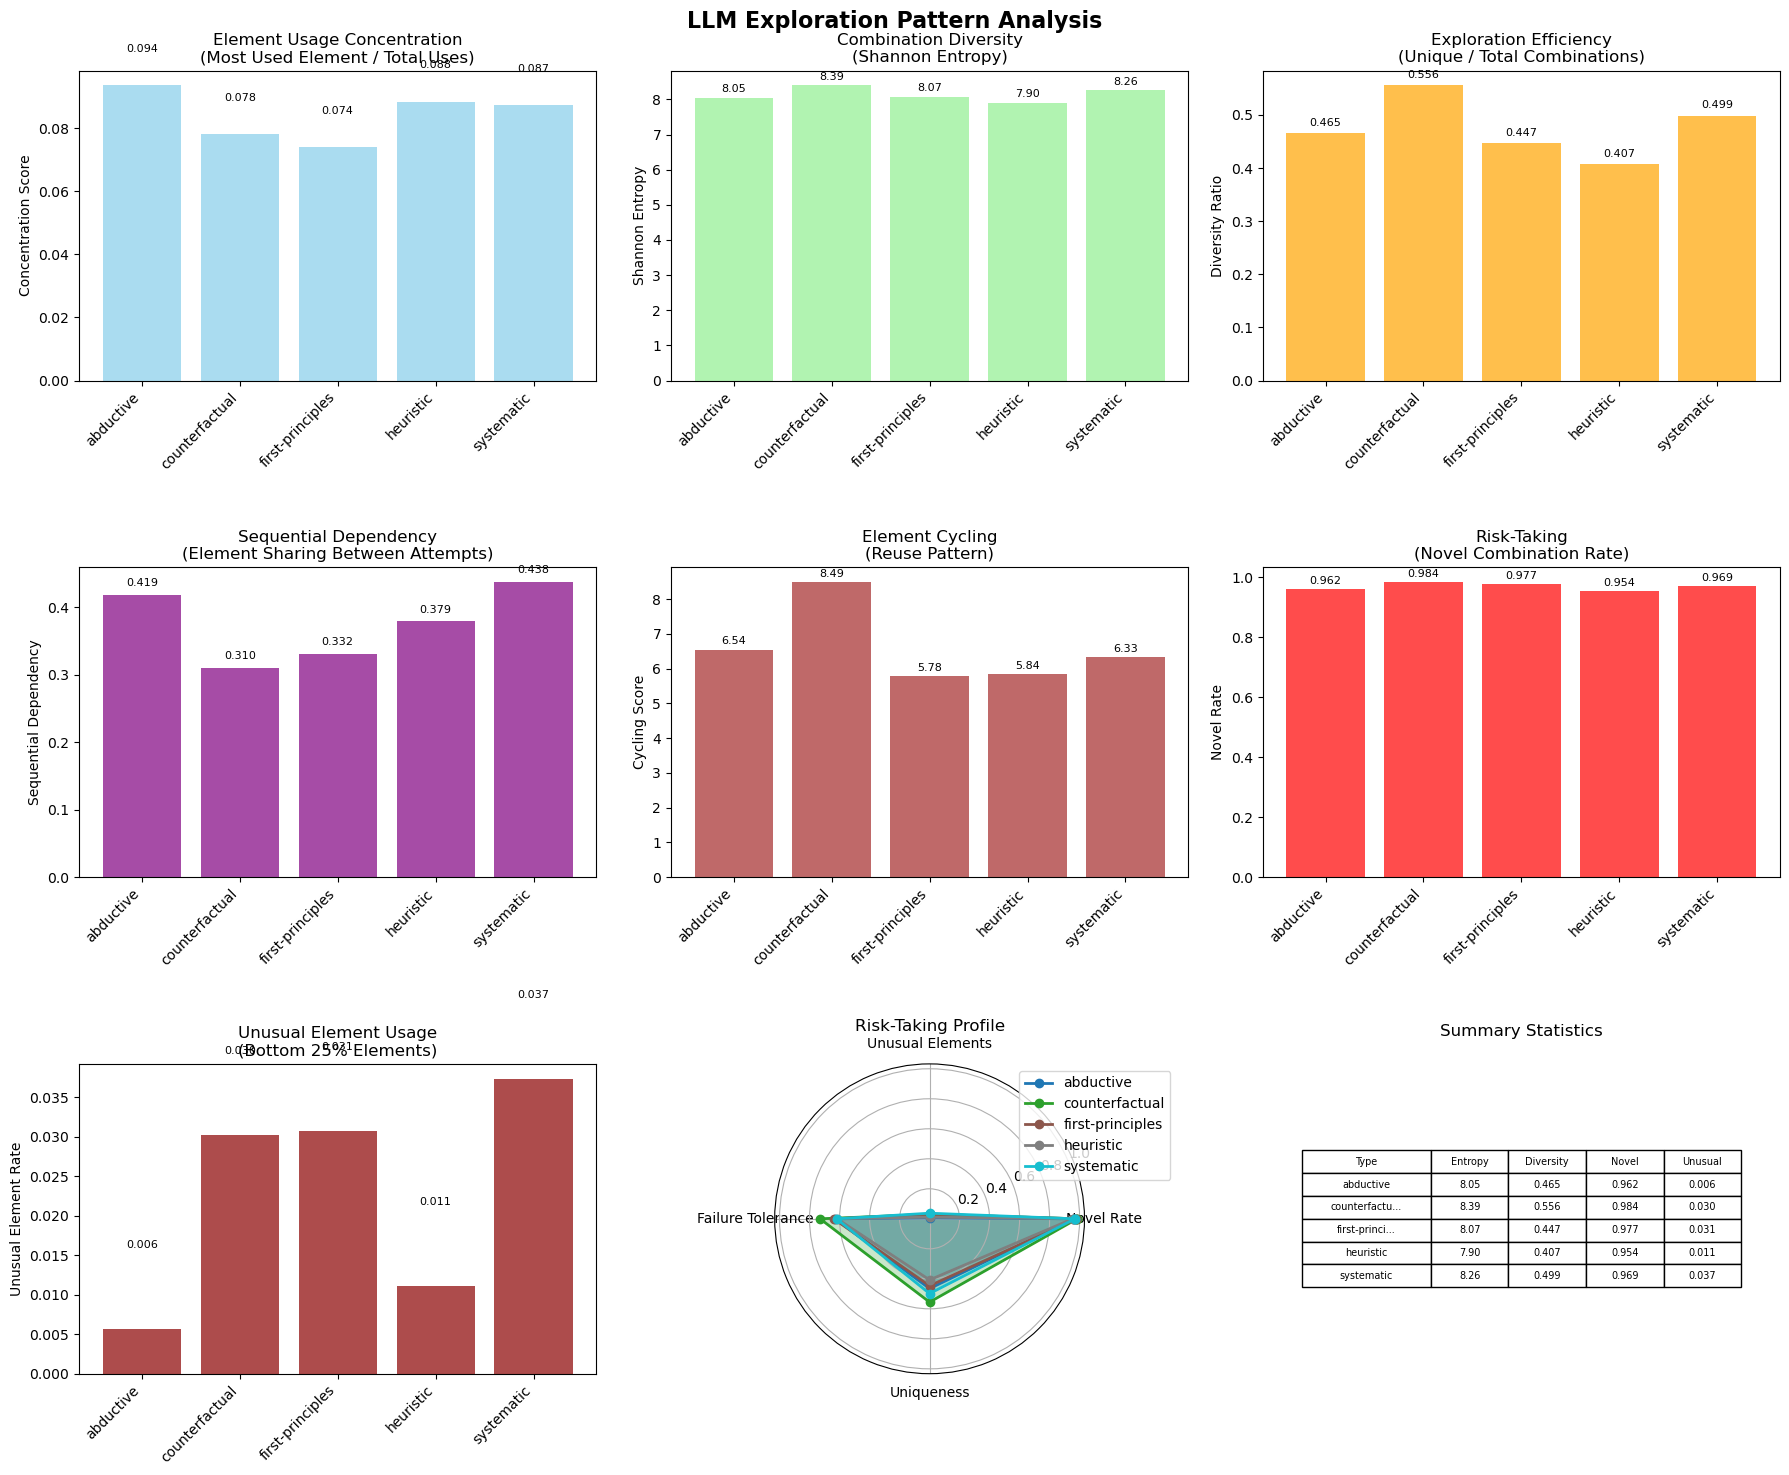

Visualization saved as 'llm_exploration_analysis.png'

KEY INSIGHTS AND RECOMMENDATIONS

🏆 TOP PERFORMERS:
• Highest Diversity: counterfactual (entropy: 8.395)
• Most Efficient: counterfactual (ratio: 0.556)
• Most Novel: counterfactual (rate: 0.984)
• Most Unusual: systematic (rate: 0.037)

📊 DIVERSITY ANALYSIS:
1. counterfactual: Entropy=8.395, Efficiency=High
2. systematic: Entropy=8.256, Efficiency=Medium
3. first-principles: Entropy=8.072, Efficiency=Medium
4. abductive: Entropy=8.052, Efficiency=Medium
5. heuristic: Entropy=7.902, Efficiency=Medium

🎲 RISK-TAKING RANKING:
1. counterfactual: Risk Score=0.523 (High)
2. systematic: Risk Score=0.502 (High)
3. first-principles: Risk Score=0.485 (High)
4. abductive: Risk Score=0.478 (High)
5. heuristic: Risk Score=0.458 (High)

🔄 SEARCH PATTERNS:
• abductive: Sequential=Low, Cycling=High
• counterfactual: Sequential=Low, Cycling=High
• first-principles: Sequential=Low, Cycling=High
• heuristic: Sequential=Low, Cycling=High
• systematic

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

class LLMExplorationAnalyzer:
    def __init__(self, attempts_file, sessions_file):
        """
        Initialize the analyzer with data files
        """
        print("Loading data...")
        self.attempts_df = pd.read_csv(attempts_file)
        self.sessions_df = pd.read_csv(sessions_file)
        
        # Merge reasoning type information
        self.data = self.attempts_df.merge(
            self.sessions_df[['sid', 'r_typ']], 
            on='sid', 
            how='left'
        )
        
        # Clean data - remove rows with missing reasoning types
        self.data = self.data.dropna(subset=['r_typ'])
        
        self.reasoning_types = sorted(self.data['r_typ'].unique())
        print(f"Loaded {len(self.data)} attempts across {len(self.reasoning_types)} reasoning types")
        print(f"Reasoning types: {self.reasoning_types}")
    
    def analyze_element_usage(self):
        """Analyze which elements are favored by each reasoning type"""
        print("\n=== ELEMENT USAGE DISTRIBUTION ===")
        
        element_usage = {}
        element_stats = {}
        
        for reasoning_type in self.reasoning_types:
            subset = self.data[self.data['r_typ'] == reasoning_type]
            
            # Count usage of each element (both e1 and e2)
            all_elements = list(subset['e1']) + list(subset['e2'])
            element_counts = Counter(all_elements)
            
            element_usage[reasoning_type] = element_counts
            
            # Calculate statistics
            total_uses = sum(element_counts.values())
            unique_elements = len(element_counts)
            most_used = element_counts.most_common(1)[0] if element_counts else ('None', 0)
            
            element_stats[reasoning_type] = {
                'total_element_uses': total_uses,
                'unique_elements_used': unique_elements,
                'most_used_element': most_used[0],
                'most_used_count': most_used[1],
                'usage_concentration': most_used[1] / total_uses if total_uses > 0 else 0
            }
            
            print(f"\n{reasoning_type}:")
            print(f"  Total element uses: {total_uses}")
            print(f"  Unique elements: {unique_elements}")
            print(f"  Most used: {most_used[0]} ({most_used[1]} times)")
            print(f"  Top 5 elements: {element_counts.most_common(5)}")
        
        return element_usage, element_stats
    
    def analyze_combination_diversity(self):
        """Calculate Shannon entropy and diversity metrics"""
        print("\n=== COMBINATION DIVERSITY ANALYSIS ===")
        
        diversity_results = {}
        
        for reasoning_type in self.reasoning_types:
            subset = self.data[self.data['r_typ'] == reasoning_type]
            
            # Create combination strings (normalize order: A+B same as B+A)
            combinations = []
            for _, row in subset.iterrows():
                combo = tuple(sorted([str(row['e1']), str(row['e2'])]))
                combinations.append(combo)
            
            combo_counts = Counter(combinations)
            total_attempts = len(combinations)
            unique_combinations = len(combo_counts)
            
            # Calculate Shannon entropy
            if total_attempts > 0:
                probabilities = [count/total_attempts for count in combo_counts.values()]
                shannon_entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
                max_entropy = np.log2(unique_combinations) if unique_combinations > 0 else 0
                normalized_entropy = shannon_entropy / max_entropy if max_entropy > 0 else 0
            else:
                shannon_entropy = 0
                normalized_entropy = 0
            
            # Calculate additional diversity metrics
            diversity_ratio = unique_combinations / total_attempts if total_attempts > 0 else 0
            repeat_rate = (total_attempts - unique_combinations) / total_attempts if total_attempts > 0 else 0
            
            diversity_results[reasoning_type] = {
                'shannon_entropy': shannon_entropy,
                'normalized_entropy': normalized_entropy,
                'unique_combinations': unique_combinations,
                'total_attempts': total_attempts,
                'diversity_ratio': diversity_ratio,
                'repeat_rate': repeat_rate
            }
            
            print(f"\n{reasoning_type}:")
            print(f"  Shannon Entropy: {shannon_entropy:.3f}")
            print(f"  Normalized Entropy: {normalized_entropy:.3f}")
            print(f"  Unique combinations: {unique_combinations} / {total_attempts}")
            print(f"  Diversity ratio: {diversity_ratio:.3f}")
            print(f"  Repeat rate: {repeat_rate:.3f}")
        
        return diversity_results
    
    def analyze_search_strategy(self):
        """Analyze sequential vs random exploration patterns"""
        print("\n=== SEARCH STRATEGY ANALYSIS ===")
        
        strategy_results = {}
        
        for reasoning_type in self.reasoning_types:
            subset = self.data[self.data['r_typ'] == reasoning_type]
            
            # Group by session for within-session analysis
            session_metrics = []
            
            for session_id in subset['sid'].unique():
                session_data = subset[subset['sid'] == session_id].sort_values('att_n')
                
                if len(session_data) < 5:  # Need sufficient data
                    continue
                
                # Calculate element reuse patterns
                elements_sequence = []
                for _, row in session_data.iterrows():
                    elements_sequence.extend([str(row['e1']), str(row['e2'])])
                
                # Sequential dependency: how often consecutive attempts share elements
                shared_elements = 0
                total_consecutive = len(session_data) - 1
                
                for i in range(len(session_data) - 1):
                    current_elements = {str(session_data.iloc[i]['e1']), str(session_data.iloc[i]['e2'])}
                    next_elements = {str(session_data.iloc[i+1]['e1']), str(session_data.iloc[i+1]['e2'])}
                    
                    if current_elements.intersection(next_elements):
                        shared_elements += 1
                
                sequential_dependency = shared_elements / total_consecutive if total_consecutive > 0 else 0
                
                # Element cycling: how much elements are reused
                unique_elements_used = len(set(elements_sequence))
                total_element_uses = len(elements_sequence)
                cycling_score = total_element_uses / unique_elements_used if unique_elements_used > 0 else 0
                
                # Consistency: standard deviation of element usage
                element_counts = Counter(elements_sequence)
                usage_values = list(element_counts.values())
                usage_std = np.std(usage_values) if len(usage_values) > 1 else 0
                usage_mean = np.mean(usage_values) if usage_values else 0
                consistency_score = usage_std / usage_mean if usage_mean > 0 else 0
                
                session_metrics.append({
                    'sequential_dependency': sequential_dependency,
                    'cycling_score': cycling_score,
                    'consistency_score': consistency_score
                })
            
            if session_metrics:
                strategy_results[reasoning_type] = {
                    'avg_sequential_dependency': np.mean([m['sequential_dependency'] for m in session_metrics]),
                    'avg_cycling_score': np.mean([m['cycling_score'] for m in session_metrics]),
                    'avg_consistency_score': np.mean([m['consistency_score'] for m in session_metrics]),
                    'sessions_analyzed': len(session_metrics)
                }
                
                print(f"\n{reasoning_type}:")
                print(f"  Sequential dependency: {strategy_results[reasoning_type]['avg_sequential_dependency']:.3f}")
                print(f"  Cycling score: {strategy_results[reasoning_type]['avg_cycling_score']:.3f}")
                print(f"  Consistency score: {strategy_results[reasoning_type]['avg_consistency_score']:.3f}")
                print(f"  Sessions analyzed: {len(session_metrics)}")
        
        return strategy_results
    
    def analyze_risk_taking(self):
        """Analyze tendency to try unusual/risky combinations"""
        print("\n=== RISK-TAKING ANALYSIS ===")
        
        # Calculate global element frequencies to identify "unusual" elements
        all_elements = list(self.data['e1']) + list(self.data['e2'])
        global_element_freq = Counter(all_elements)
        
        # Define thresholds for unusual elements (bottom quartile)
        sorted_elements = sorted(global_element_freq.items(), key=lambda x: x[1])
        unusual_threshold_idx = len(sorted_elements) // 4
        unusual_elements = set([elem for elem, _ in sorted_elements[:unusual_threshold_idx]])
        
        risk_results = {}
        
        for reasoning_type in self.reasoning_types:
            subset = self.data[self.data['r_typ'] == reasoning_type]
            total_attempts = len(subset)
            
            if total_attempts == 0:
                continue
            
            # 1. Novel combination rate (using the 'novel' column if available)
            if 'novel' in subset.columns:
                novel_rate = subset['novel'].sum() / total_attempts
            else:
                novel_rate = 0
            
            # 2. Unusual element usage rate
            unusual_uses = 0
            for _, row in subset.iterrows():
                if str(row['e1']) in unusual_elements or str(row['e2']) in unusual_elements:
                    unusual_uses += 1
            unusual_rate = unusual_uses / total_attempts
            
            # 3. Failure tolerance (willingness to try despite failures)
            if 'ok' in subset.columns:
                failure_rate = (~subset['ok']).sum() / total_attempts
            else:
                failure_rate = 0
            
            # 4. Exploration breadth (unique combinations / possible combinations)
            combinations = []
            for _, row in subset.iterrows():
                combo = tuple(sorted([str(row['e1']), str(row['e2'])]))
                combinations.append(combo)
            
            unique_combos = len(set(combinations))
            uniqueness_ratio = unique_combos / total_attempts
            
            # 5. Success rate with novel combinations
            if 'novel' in subset.columns and 'ok' in subset.columns:
                novel_subset = subset[subset['novel'] == True]
                novel_success_rate = novel_subset['ok'].mean() if len(novel_subset) > 0 else 0
            else:
                novel_success_rate = 0
            
            risk_results[reasoning_type] = {
                'novel_combination_rate': novel_rate,
                'unusual_element_rate': unusual_rate,
                'failure_tolerance': failure_rate,
                'uniqueness_ratio': uniqueness_ratio,
                'novel_success_rate': novel_success_rate,
                'total_attempts': total_attempts
            }
            
            print(f"\n{reasoning_type}:")
            print(f"  Novel combination rate: {novel_rate:.3f}")
            print(f"  Unusual element rate: {unusual_rate:.3f}")
            print(f"  Failure tolerance: {failure_rate:.3f}")
            print(f"  Uniqueness ratio: {uniqueness_ratio:.3f}")
            print(f"  Novel success rate: {novel_success_rate:.3f}")
        
        return risk_results
    
    def create_visualizations(self, element_usage, element_stats, diversity_results, strategy_results, risk_results):
        """Create comprehensive visualizations"""
        print("\n=== CREATING VISUALIZATIONS ===")
        
        # Create a large figure with subplots
        fig, axes = plt.subplots(3, 3, figsize=(18, 15))
        fig.suptitle('LLM Exploration Pattern Analysis', fontsize=16, fontweight='bold')
        
        # 1. Element Usage Concentration
        ax = axes[0, 0]
        reasoning_types = list(element_stats.keys())
        concentrations = [element_stats[rt]['usage_concentration'] for rt in reasoning_types]
        
        bars = ax.bar(reasoning_types, concentrations, color='skyblue', alpha=0.7)
        ax.set_title('Element Usage Concentration\n(Most Used Element / Total Uses)')
        ax.set_ylabel('Concentration Score')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        for bar, conc in zip(bars, concentrations):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{conc:.3f}', ha='center', va='bottom', fontsize=8)
        
        # 2. Shannon Entropy
        ax = axes[0, 1]
        entropies = [diversity_results[rt]['shannon_entropy'] for rt in reasoning_types]
        
        bars = ax.bar(reasoning_types, entropies, color='lightgreen', alpha=0.7)
        ax.set_title('Combination Diversity\n(Shannon Entropy)')
        ax.set_ylabel('Shannon Entropy')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        for bar, entropy in zip(bars, entropies):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                   f'{entropy:.2f}', ha='center', va='bottom', fontsize=8)
        
        # 3. Diversity Ratio
        ax = axes[0, 2]
        diversity_ratios = [diversity_results[rt]['diversity_ratio'] for rt in reasoning_types]
        
        bars = ax.bar(reasoning_types, diversity_ratios, color='orange', alpha=0.7)
        ax.set_title('Exploration Efficiency\n(Unique / Total Combinations)')
        ax.set_ylabel('Diversity Ratio')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        for bar, ratio in zip(bars, diversity_ratios):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{ratio:.3f}', ha='center', va='bottom', fontsize=8)
        
        # 4. Sequential Dependency
        ax = axes[1, 0]
        if strategy_results:
            strategy_types = [rt for rt in reasoning_types if rt in strategy_results]
            sequential_deps = [strategy_results[rt]['avg_sequential_dependency'] for rt in strategy_types]
            
            bars = ax.bar(strategy_types, sequential_deps, color='purple', alpha=0.7)
            ax.set_title('Sequential Dependency\n(Element Sharing Between Attempts)')
            ax.set_ylabel('Sequential Dependency')
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            
            for bar, dep in zip(bars, sequential_deps):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{dep:.3f}', ha='center', va='bottom', fontsize=8)
        
        # 5. Element Cycling
        ax = axes[1, 1]
        if strategy_results:
            cycling_scores = [strategy_results[rt]['avg_cycling_score'] for rt in strategy_types]
            
            bars = ax.bar(strategy_types, cycling_scores, color='brown', alpha=0.7)
            ax.set_title('Element Cycling\n(Reuse Pattern)')
            ax.set_ylabel('Cycling Score')
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            
            for bar, score in zip(bars, cycling_scores):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                       f'{score:.2f}', ha='center', va='bottom', fontsize=8)
        
        # 6. Novel Combination Rate
        ax = axes[1, 2]
        novel_rates = [risk_results[rt]['novel_combination_rate'] for rt in reasoning_types]
        
        bars = ax.bar(reasoning_types, novel_rates, color='red', alpha=0.7)
        ax.set_title('Risk-Taking\n(Novel Combination Rate)')
        ax.set_ylabel('Novel Rate')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        for bar, rate in zip(bars, novel_rates):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{rate:.3f}', ha='center', va='bottom', fontsize=8)
        
        # 7. Unusual Element Usage
        ax = axes[2, 0]
        unusual_rates = [risk_results[rt]['unusual_element_rate'] for rt in reasoning_types]
        
        bars = ax.bar(reasoning_types, unusual_rates, color='darkred', alpha=0.7)
        ax.set_title('Unusual Element Usage\n(Bottom 25% Elements)')
        ax.set_ylabel('Unusual Element Rate')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        for bar, rate in zip(bars, unusual_rates):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{rate:.3f}', ha='center', va='bottom', fontsize=8)
        
        # 8. Comprehensive Risk Profile (Radar Chart)
        ax = axes[2, 1]
        ax.remove()  # Remove the regular subplot
        ax = fig.add_subplot(3, 3, 8, projection='polar')
        
        categories = ['Novel Rate', 'Unusual Elements', 'Failure Tolerance', 'Uniqueness']
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]
        
        colors = plt.cm.tab10(np.linspace(0, 1, len(reasoning_types)))
        
        for i, reasoning_type in enumerate(reasoning_types):
            if reasoning_type in risk_results:
                values = [
                    risk_results[reasoning_type]['novel_combination_rate'],
                    risk_results[reasoning_type]['unusual_element_rate'],
                    risk_results[reasoning_type]['failure_tolerance'],
                    risk_results[reasoning_type]['uniqueness_ratio']
                ]
                values += values[:1]
                
                ax.plot(angles, values, 'o-', linewidth=2, label=reasoning_type, color=colors[i])
                ax.fill(angles, values, alpha=0.25, color=colors[i])
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_title('Risk-Taking Profile', y=1.08)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        
        # 9. Summary Statistics Table
        ax = axes[2, 2]
        ax.axis('off')
        
        # Create summary data
        summary_data = []
        for rt in reasoning_types:
            if rt in diversity_results and rt in risk_results:
                row = [
                    rt[:12] + '...' if len(rt) > 12 else rt,  # Truncate long names
                    f"{diversity_results[rt]['shannon_entropy']:.2f}",
                    f"{diversity_results[rt]['diversity_ratio']:.3f}",
                    f"{risk_results[rt]['novel_combination_rate']:.3f}",
                    f"{risk_results[rt]['unusual_element_rate']:.3f}"
                ]
                summary_data.append(row)
        
        if summary_data:
            table = ax.table(cellText=summary_data,
                           colLabels=['Type', 'Entropy', 'Diversity', 'Novel', 'Unusual'],
                           cellLoc='center',
                           loc='center',
                           colWidths=[0.25, 0.15, 0.15, 0.15, 0.15])
            table.auto_set_font_size(False)
            table.set_fontsize(7)
            table.scale(1, 1.5)
            ax.set_title('Summary Statistics', pad=20)
        
        plt.tight_layout()
        plt.savefig('llm_exploration_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Visualization saved as 'llm_exploration_analysis.png'")
    
    def generate_insights_report(self, element_stats, diversity_results, strategy_results, risk_results):
        """Generate key insights and recommendations"""
        print("\n" + "="*70)
        print("KEY INSIGHTS AND RECOMMENDATIONS")
        print("="*70)
        
        # Find top performers in each category
        best_diversity = max(diversity_results.items(), key=lambda x: x[1]['shannon_entropy'])
        most_efficient = max(diversity_results.items(), key=lambda x: x[1]['diversity_ratio'])
        most_novel = max(risk_results.items(), key=lambda x: x[1]['novel_combination_rate'])
        most_unusual = max(risk_results.items(), key=lambda x: x[1]['unusual_element_rate'])
        
        print(f"\n🏆 TOP PERFORMERS:")
        print(f"• Highest Diversity: {best_diversity[0]} (entropy: {best_diversity[1]['shannon_entropy']:.3f})")
        print(f"• Most Efficient: {most_efficient[0]} (ratio: {most_efficient[1]['diversity_ratio']:.3f})")
        print(f"• Most Novel: {most_novel[0]} (rate: {most_novel[1]['novel_combination_rate']:.3f})")
        print(f"• Most Unusual: {most_unusual[0]} (rate: {most_unusual[1]['unusual_element_rate']:.3f})")
        
        print(f"\n📊 DIVERSITY ANALYSIS:")
        sorted_diversity = sorted(diversity_results.items(), key=lambda x: x[1]['shannon_entropy'], reverse=True)
        for i, (rt, metrics) in enumerate(sorted_diversity, 1):
            efficiency = "High" if metrics['diversity_ratio'] > 0.5 else "Medium" if metrics['diversity_ratio'] > 0.3 else "Low"
            print(f"{i}. {rt}: Entropy={metrics['shannon_entropy']:.3f}, Efficiency={efficiency}")
        
        print(f"\n🎲 RISK-TAKING RANKING:")
        # Calculate composite risk score
        risk_scores = {}
        for rt, metrics in risk_results.items():
            risk_score = (metrics['novel_combination_rate'] + 
                         metrics['unusual_element_rate'] + 
                         metrics['uniqueness_ratio']) / 3
            risk_scores[rt] = risk_score
        
        sorted_risk = sorted(risk_scores.items(), key=lambda x: x[1], reverse=True)
        for i, (rt, score) in enumerate(sorted_risk, 1):
            risk_level = "High" if score > 0.4 else "Medium" if score > 0.2 else "Low"
            print(f"{i}. {rt}: Risk Score={score:.3f} ({risk_level})")
        
        if strategy_results:
            print(f"\n🔄 SEARCH PATTERNS:")
            for rt, metrics in strategy_results.items():
                sequential = "High" if metrics['avg_sequential_dependency'] > 0.5 else "Low"
                cycling = "High" if metrics['avg_cycling_score'] > 2.0 else "Low"
                print(f"• {rt}: Sequential={sequential}, Cycling={cycling}")
        
        print(f"\n💡 STRATEGIC RECOMMENDATIONS:")
        print("• For maximum discovery: Use", best_diversity[0])
        print("• For efficient exploration: Use", most_efficient[0])
        print("• For creative breakthroughs: Use", most_novel[0])
        print("• For comprehensive coverage: Combine high diversity with high risk-taking")
        
        return {
            'best_diversity': best_diversity,
            'most_efficient': most_efficient,
            'most_novel': most_novel,
            'most_unusual': most_unusual
        }
    
    def run_full_analysis(self):
        """Run the complete exploration pattern analysis"""
        print("🚀 Starting LLM Exploration Pattern Analysis")
        print("="*60)
        
        # Run all analyses
        element_usage, element_stats = self.analyze_element_usage()
        diversity_results = self.analyze_combination_diversity()
        strategy_results = self.analyze_search_strategy()
        risk_results = self.analyze_risk_taking()
        
        # Create visualizations
        self.create_visualizations(element_usage, element_stats, diversity_results, 
                                  strategy_results, risk_results)
        
        # Generate insights
        insights = self.generate_insights_report(element_stats, diversity_results, 
                                                strategy_results, risk_results)
        
        print(f"\n✅ Analysis complete! Results saved as 'llm_exploration_analysis.png'")
        
        return {
            'element_usage': element_usage,
            'element_stats': element_stats,
            'diversity_results': diversity_results,
            'strategy_results': strategy_results,
            'risk_results': risk_results,
            'insights': insights
        }

# Example usage
if __name__ == "__main__":
    # Initialize analyzer
    analyzer = LLMExplorationAnalyzer(
        attempts_file='tests/all_attempts_data.csv',
        sessions_file='tests/all_sessions_data.csv'
    )
    
    # Run complete analysis
    results = analyzer.run_full_analysis()

LLM EXPLORATION CAPABILITIES: ANOVA ANALYSIS
Discovery Rates by Reasoning Type
Data loaded successfully!
Total sessions: 25
Columns: ['sid', 'r_typ', 'start', 'start_ts', 'end', 'end_ts', 'tot_att', 'succ_att', 'elem_disc', 'final_inv', 'disc_rate', 'max_succ', 'max_fail', 'plateaus', 'last_disc_t']
Reasoning types: ['first-principles' 'systematic' 'counterfactual' 'heuristic' 'abductive']
Sessions per reasoning type:
r_typ
first-principles    5
systematic          5
counterfactual      5
heuristic           5
abductive           5
Name: count, dtype: int64

ANOVA ANALYSIS: DISCOVERY RATES BY REASONING TYPE

DESCRIPTIVE STATISTICS
----------------------------------------
first-principles: n= 5, Mean=0.360, SD=0.033, Range=[0.327, 0.409]
systematic     : n= 5, Mean=0.370, SD=0.095, Range=[0.208, 0.448]
counterfactual : n= 5, Mean=0.269, SD=0.091, Range=[0.127, 0.373]
heuristic      : n= 5, Mean=0.371, SD=0.019, Range=[0.353, 0.402]
abductive      : n= 5, Mean=0.363, SD=0.092, Range=[0.2

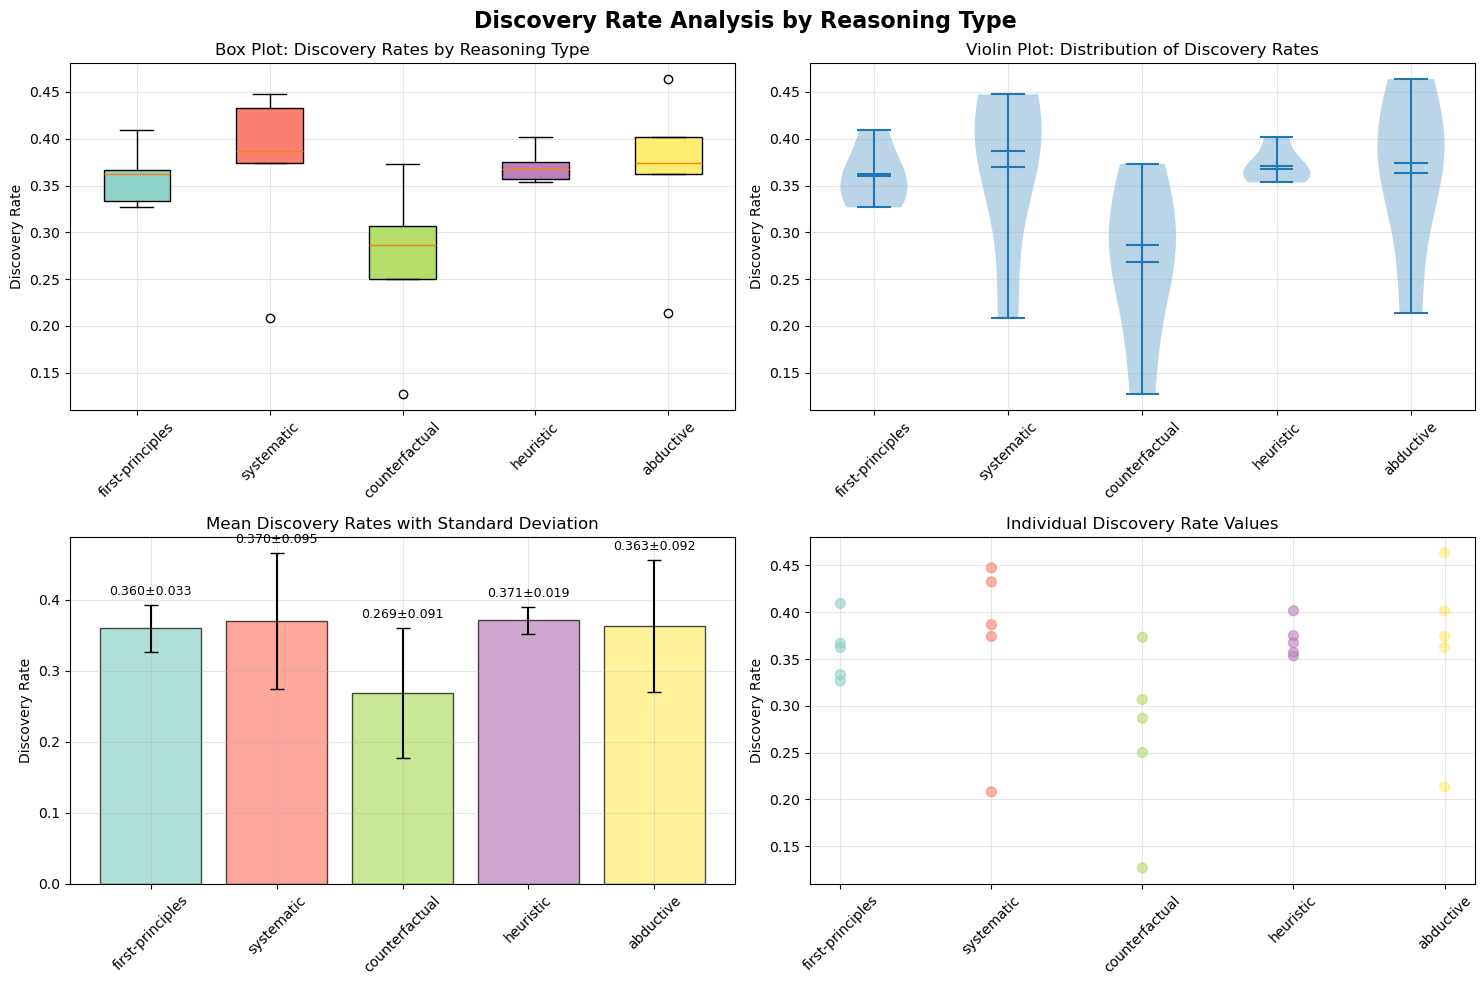


SUMMARY STATISTICS TABLE
------------------------------------------------------------
  Reasoning Type  N  Mean    SD   Min   Max Median
first-principles  5 0.360 0.033 0.327 0.409  0.362
      systematic  5 0.370 0.095 0.208 0.448  0.387
  counterfactual  5 0.269 0.091 0.127 0.373  0.287
       heuristic  5 0.371 0.019 0.353 0.402  0.367
       abductive  5 0.363 0.092 0.213 0.464  0.374

ANALYSIS COMPLETE
✓ Analyzed 25 sessions across 5 reasoning types
✓ ANOVA F-statistic: 1.7426, p-value: 0.180247
✓ No significant differences found between reasoning types


In [21]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway, ttest_ind, shapiro, levene
from scipy.stats import tukey_hsd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

def load_and_prepare_data():
    """Load session data and prepare for analysis"""
    try:
        # Load session data
        sessions = pd.read_csv('tests/all_sessions_data.csv')
        print("Data loaded successfully!")
        print(f"Total sessions: {len(sessions)}")
        print(f"Columns: {list(sessions.columns)}")
        print(f"Reasoning types: {sessions['r_typ'].unique()}")
        print(f"Sessions per reasoning type:\n{sessions['r_typ'].value_counts()}")
        return sessions
    except FileNotFoundError:
        print("Error: Could not find 'tests/all_sessions_data.csv'")
        return None

def group_by_reasoning_type(sessions, metric_column):
    """Group data by reasoning type for a specific metric"""
    grouped_data = {}
    for reasoning_type in sessions['r_typ'].unique():
        type_data = sessions[sessions['r_typ'] == reasoning_type][metric_column].values
        grouped_data[reasoning_type] = type_data
    return grouped_data

def check_anova_assumptions(grouped_data):
    """Check ANOVA assumptions: normality and equal variances"""
    print("\n" + "="*60)
    print("CHECKING ANOVA ASSUMPTIONS")
    print("="*60)
    
    # Check normality for each group (Shapiro-Wilk test)
    print("\n1. NORMALITY TEST (Shapiro-Wilk)")
    print("-" * 40)
    normality_results = {}
    for reasoning_type, data in grouped_data.items():
        if len(data) >= 3:  # Shapiro-Wilk needs at least 3 observations
            stat, p_value = shapiro(data)
            normality_results[reasoning_type] = p_value
            print(f"{reasoning_type:15}: p-value = {p_value:.4f} {'(Normal)' if p_value > 0.05 else '(Not Normal)'}")
        else:
            print(f"{reasoning_type:15}: Too few observations for normality test")
    
    # Check equal variances (Levene's test)
    print("\n2. EQUAL VARIANCES TEST (Levene)")
    print("-" * 40)
    try:
        stat, p_value = levene(*grouped_data.values())
        print(f"Levene test p-value: {p_value:.4f}")
        if p_value > 0.05:
            print("✓ Equal variances assumption MET")
        else:
            print("✗ Equal variances assumption VIOLATED")
    except Exception as e:
        print(f"Could not perform Levene test: {e}")
    
    return normality_results

def perform_anova_analysis(sessions):
    """Perform comprehensive ANOVA analysis on discovery rates"""
    
    print("\n" + "="*60)
    print("ANOVA ANALYSIS: DISCOVERY RATES BY REASONING TYPE")
    print("="*60)
    
    # Group discovery rates by reasoning type
    discovery_rates_by_type = group_by_reasoning_type(sessions, 'disc_rate')
    
    # Display descriptive statistics
    print("\nDESCRIPTIVE STATISTICS")
    print("-" * 40)
    stats_summary = []
    for reasoning_type, rates in discovery_rates_by_type.items():
        stats = {
            'Reasoning_Type': reasoning_type,
            'N': len(rates),
            'Mean': np.mean(rates),
            'Std': np.std(rates, ddof=1),
            'Min': np.min(rates),
            'Max': np.max(rates),
            'Median': np.median(rates)
        }
        stats_summary.append(stats)
        print(f"{reasoning_type:15}: n={len(rates):2d}, Mean={np.mean(rates):.3f}, "
              f"SD={np.std(rates, ddof=1):.3f}, Range=[{np.min(rates):.3f}, {np.max(rates):.3f}]")
    
    # Check ANOVA assumptions
    normality_results = check_anova_assumptions(discovery_rates_by_type)
    
    # Perform one-way ANOVA
    print("\n" + "="*60)
    print("ONE-WAY ANOVA RESULTS")
    print("="*60)
    
    try:
        f_stat, p_value = f_oneway(*discovery_rates_by_type.values())
        
        print(f"\nF-statistic: {f_stat:.4f}")
        print(f"p-value: {p_value:.6f}")
        print(f"Degrees of freedom: {len(discovery_rates_by_type) - 1} (between), {sum(len(v) for v in discovery_rates_by_type.values()) - len(discovery_rates_by_type)} (within)")
        
        # Interpret results
        alpha = 0.05
        if p_value < alpha:
            print(f"\n✓ SIGNIFICANT RESULT (p < {alpha})")
            print("There are statistically significant differences between reasoning types.")
        else:
            print(f"\n✗ NON-SIGNIFICANT RESULT (p ≥ {alpha})")
            print("No statistically significant differences found between reasoning types.")
            
        # Effect size (eta-squared)
        ss_between = f_stat * (sum(len(v) for v in discovery_rates_by_type.values()) - len(discovery_rates_by_type))
        ss_total = ss_between + (sum(len(v) for v in discovery_rates_by_type.values()) - len(discovery_rates_by_type))
        eta_squared = ss_between / (ss_between + (sum(len(v) for v in discovery_rates_by_type.values()) - len(discovery_rates_by_type)))
        
        print(f"\nEffect size (η²): {eta_squared:.4f}")
        if eta_squared < 0.01:
            effect_interpretation = "negligible"
        elif eta_squared < 0.06:
            effect_interpretation = "small"
        elif eta_squared < 0.14:
            effect_interpretation = "medium"
        else:
            effect_interpretation = "large"
        print(f"Effect size interpretation: {effect_interpretation}")
        
    except Exception as e:
        print(f"Error performing ANOVA: {e}")
        return None
    
    return f_stat, p_value, discovery_rates_by_type

def perform_post_hoc_analysis(discovery_rates_by_type, sessions):
    """Perform post-hoc pairwise comparisons if ANOVA is significant"""
    
    print("\n" + "="*60)
    print("POST-HOC PAIRWISE COMPARISONS")
    print("="*60)
    
    # Prepare data for Tukey HSD
    reasoning_types = list(discovery_rates_by_type.keys())
    all_rates = []
    all_groups = []
    
    for reasoning_type, rates in discovery_rates_by_type.items():
        all_rates.extend(rates)
        all_groups.extend([reasoning_type] * len(rates))
    
    # Perform Tukey HSD test
    print("\nTUKEY HSD TEST")
    print("-" * 40)
    try:
        tukey_result = pairwise_tukeyhsd(all_rates, all_groups, alpha=0.05)
        print(tukey_result)
        
        # Manual pairwise t-tests with Bonferroni correction
        print(f"\n\nPAIRWISE T-TESTS (Bonferroni corrected)")
        print("-" * 50)
        
        n_comparisons = len(reasoning_types) * (len(reasoning_types) - 1) // 2
        bonferroni_alpha = 0.05 / n_comparisons
        print(f"Number of comparisons: {n_comparisons}")
        print(f"Bonferroni-corrected α: {bonferroni_alpha:.4f}")
        print()
        
        significant_pairs = []
        for i, type1 in enumerate(reasoning_types):
            for j, type2 in enumerate(reasoning_types[i+1:], i+1):
                data1 = discovery_rates_by_type[type1]
                data2 = discovery_rates_by_type[type2]
                
                t_stat, p_val = ttest_ind(data1, data2, equal_var=True)
                corrected_p = p_val * n_comparisons
                corrected_p = min(corrected_p, 1.0)  # Cap at 1.0
                
                is_significant = corrected_p < 0.05
                if is_significant:
                    significant_pairs.append((type1, type2))
                
                mean_diff = np.mean(data1) - np.mean(data2)
                print(f"{type1:15} vs {type2:15}: "
                      f"t={t_stat:6.3f}, p={p_val:.4f}, "
                      f"p_corr={corrected_p:.4f}, "
                      f"diff={mean_diff:6.3f} "
                      f"{'*' if is_significant else ''}")
        
        if significant_pairs:
            print(f"\nSIGNIFICANT PAIRS (* indicates p < 0.05 after correction):")
            for pair in significant_pairs:
                print(f"  • {pair[0]} vs {pair[1]}")
        else:
            print("\nNo significant pairwise differences after Bonferroni correction.")
            
    except Exception as e:
        print(f"Error in post-hoc analysis: {e}")

def create_visualizations(discovery_rates_by_type, sessions):
    """Create visualizations for the ANOVA results"""
    
    print("\n" + "="*60)
    print("CREATING VISUALIZATIONS")
    print("="*60)
    
    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Discovery Rate Analysis by Reasoning Type', fontsize=16, fontweight='bold')
    
    # 1. Box plot
    ax1 = axes[0, 0]
    reasoning_types = list(discovery_rates_by_type.keys())
    data_for_boxplot = [discovery_rates_by_type[rt] for rt in reasoning_types]
    
    box_plot = ax1.boxplot(data_for_boxplot, labels=reasoning_types, patch_artist=True)
    colors = plt.cm.Set3(np.linspace(0, 1, len(reasoning_types)))
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    
    ax1.set_title('Box Plot: Discovery Rates by Reasoning Type')
    ax1.set_ylabel('Discovery Rate')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 2. Violin plot
    ax2 = axes[0, 1]
    positions = range(1, len(reasoning_types) + 1)
    violin_parts = ax2.violinplot(data_for_boxplot, positions=positions, showmeans=True, showmedians=True)
    
    ax2.set_title('Violin Plot: Distribution of Discovery Rates')
    ax2.set_ylabel('Discovery Rate')
    ax2.set_xticks(positions)
    ax2.set_xticklabels(reasoning_types, rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. Mean and error bars
    ax3 = axes[1, 0]
    means = [np.mean(discovery_rates_by_type[rt]) for rt in reasoning_types]
    stds = [np.std(discovery_rates_by_type[rt], ddof=1) for rt in reasoning_types]
    
    bars = ax3.bar(reasoning_types, means, yerr=stds, capsize=5, 
                   color=colors, alpha=0.7, edgecolor='black')
    ax3.set_title('Mean Discovery Rates with Standard Deviation')
    ax3.set_ylabel('Discovery Rate')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 4. Individual data points
    ax4 = axes[1, 1]
    x_positions = []
    y_values = []
    colors_scatter = []
    
    for i, rt in enumerate(reasoning_types):
        x_pos = [i + 1] * len(discovery_rates_by_type[rt])
        x_positions.extend(x_pos)
        y_values.extend(discovery_rates_by_type[rt])
        colors_scatter.extend([colors[i]] * len(discovery_rates_by_type[rt]))
    
    ax4.scatter(x_positions, y_values, c=colors_scatter, alpha=0.6, s=50)
    ax4.set_title('Individual Discovery Rate Values')
    ax4.set_ylabel('Discovery Rate')
    ax4.set_xticks(range(1, len(reasoning_types) + 1))
    ax4.set_xticklabels(reasoning_types, rotation=45)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    print("\nSUMMARY STATISTICS TABLE")
    print("-" * 60)
    summary_df = pd.DataFrame([
        {
            'Reasoning Type': rt,
            'N': len(discovery_rates_by_type[rt]),
            'Mean': f"{np.mean(discovery_rates_by_type[rt]):.3f}",
            'SD': f"{np.std(discovery_rates_by_type[rt], ddof=1):.3f}",
            'Min': f"{np.min(discovery_rates_by_type[rt]):.3f}",
            'Max': f"{np.max(discovery_rates_by_type[rt]):.3f}",
            'Median': f"{np.median(discovery_rates_by_type[rt]):.3f}"
        }
        for rt in reasoning_types
    ])
    print(summary_df.to_string(index=False))

def main():
    """Main analysis function"""
    print("="*60)
    print("LLM EXPLORATION CAPABILITIES: ANOVA ANALYSIS")
    print("Discovery Rates by Reasoning Type")
    print("="*60)
    
    # Load data
    sessions = load_and_prepare_data()
    if sessions is None:
        return
    
    # Perform ANOVA analysis
    anova_results = perform_anova_analysis(sessions)
    if anova_results is None:
        return
    
    f_stat, p_value, discovery_rates_by_type = anova_results
    
    # If ANOVA is significant, perform post-hoc tests
    if p_value < 0.05:
        perform_post_hoc_analysis(discovery_rates_by_type, sessions)
    else:
        print("\nSkipping post-hoc analysis (ANOVA not significant)")
    
    # Create visualizations
    create_visualizations(discovery_rates_by_type, sessions)
    
    # Final summary
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")
    print("="*60)
    print(f"✓ Analyzed {len(sessions)} sessions across {len(discovery_rates_by_type)} reasoning types")
    print(f"✓ ANOVA F-statistic: {f_stat:.4f}, p-value: {p_value:.6f}")
    if p_value < 0.05:
        print("✓ Significant differences found between reasoning types")
    else:
        print("✓ No significant differences found between reasoning types")

if __name__ == "__main__":
    main()

EXPLORATION BREADTH ANALYSIS
Loading data...
Loaded 25 sessions and 3658 attempts
Session columns: ['sid', 'r_typ', 'start', 'start_ts', 'end', 'end_ts', 'tot_att', 'succ_att', 'elem_disc', 'final_inv', 'disc_rate', 'max_succ', 'max_fail', 'plateaus', 'last_disc_t']
Reasoning types: ['first-principles' 'systematic' 'counterfactual' 'heuristic' 'abductive']

Calculating exploration breadth...
Calculated exploration breadth for 25 sessions

Grouping by reasoning type...

Summary Statistics by Reasoning Type:
     reasoning_type  n_sessions  mean_breadth  std_breadth  median_breadth  \
0  first-principles           5        0.0410       0.0503          0.0000   
1        systematic           5        0.1038       0.0676          0.0768   
2    counterfactual           5        0.1742       0.1903          0.1176   
3         heuristic           5        0.0169       0.0339          0.0000   
4         abductive           5        0.0000       0.0000          0.0000   

   min_breadth  max

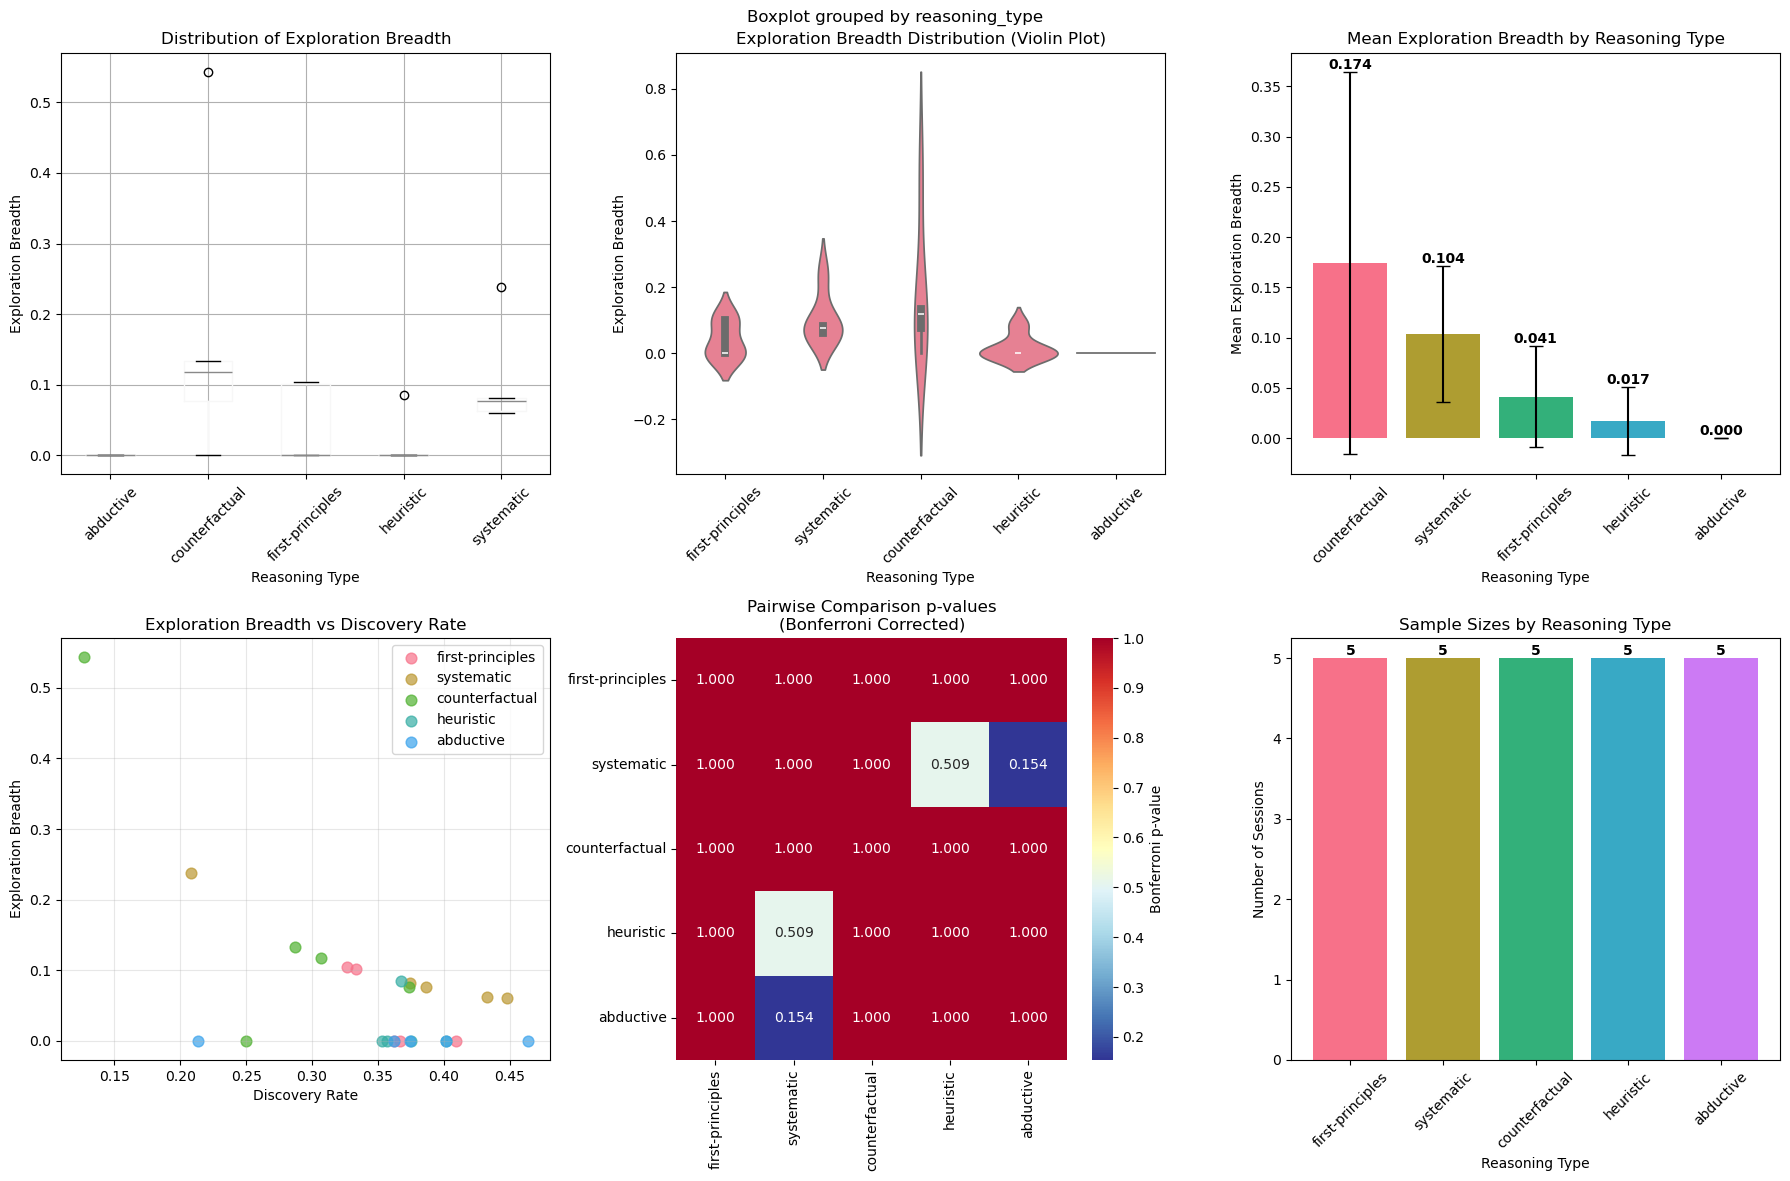

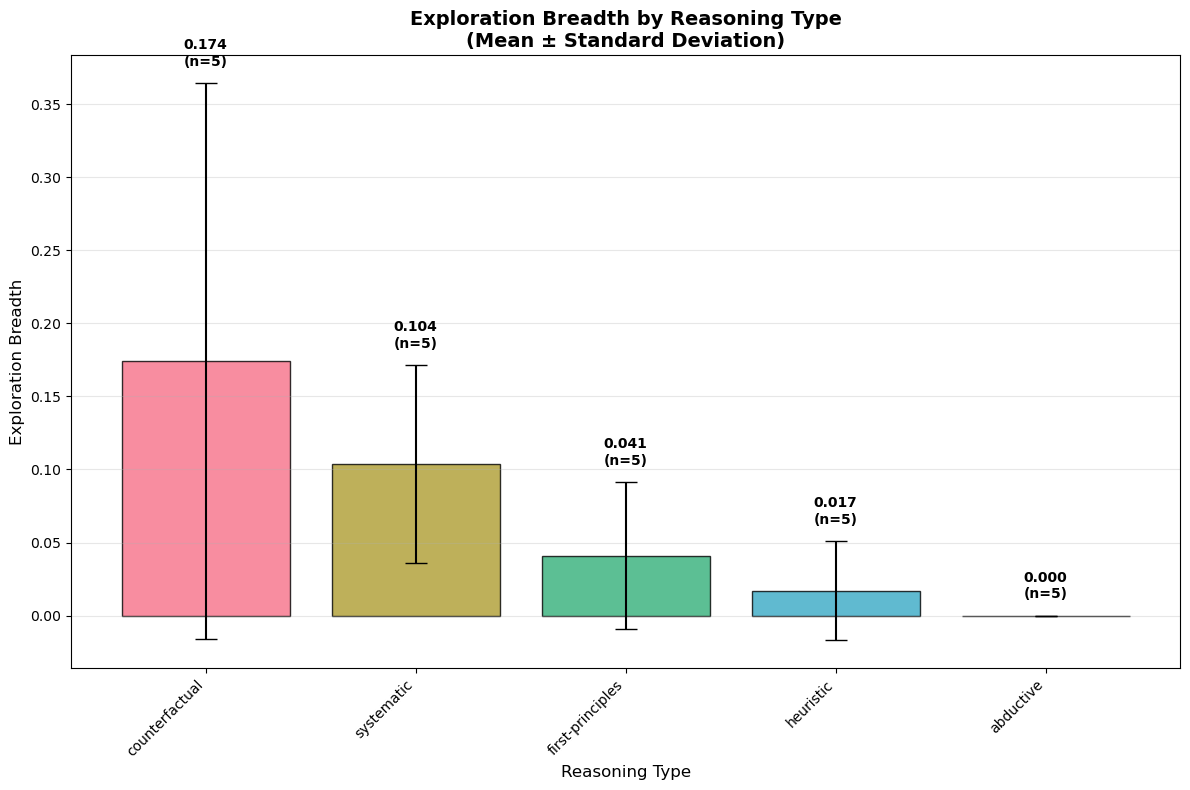


FINAL SUMMARY

Ranking by Mean Exploration Breadth:
1. counterfactual: 0.174 (±0.190, n=5)
2. systematic: 0.104 (±0.068, n=5)
3. first-principles: 0.041 (±0.050, n=5)
4. heuristic: 0.017 (±0.034, n=5)
5. abductive: 0.000 (±0.000, n=5)

ANOVA Results: F(4, 20) = 2.306, p = 0.093679

No significant pairwise differences found after Bonferroni correction.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def load_and_prepare_data():
    """Load the session and attempts data"""
    print("Loading data...")
    
    # Load the data files
    sessions_df = pd.read_csv('tests/all_sessions_data.csv')
    attempts_df = pd.read_csv('tests/all_attempts_data.csv')
    
    print(f"Loaded {len(sessions_df)} sessions and {len(attempts_df)} attempts")
    print(f"Session columns: {list(sessions_df.columns)}")
    print(f"Reasoning types: {sessions_df['r_typ'].unique()}")
    
    return sessions_df, attempts_df

def calculate_exploration_breadth(sessions_df, attempts_df):
    """Calculate exploration breadth for each session"""
    print("\nCalculating exploration breadth...")
    
    exploration_data = []
    
    for session_id in sessions_df['sid'].unique():
        # Get session info
        session_info = sessions_df[sessions_df['sid'] == session_id].iloc[0]
        
        # Get attempts for this session
        session_attempts = attempts_df[attempts_df['sid'] == session_id].copy()
        
        if len(session_attempts) == 0:
            continue
            
        # Calculate unique combinations attempted
        session_attempts['combination'] = session_attempts['e1'] + ' + ' + session_attempts['e2']
        unique_combinations = session_attempts['combination'].nunique()
        
        # Calculate possible combinations from final inventory
        final_inventory_size = session_info['final_inv']
        possible_combinations = final_inventory_size * (final_inventory_size + 1) / 2
        
        # Calculate exploration breadth
        exploration_breadth = unique_combinations / possible_combinations if possible_combinations > 0 else 0
        
        exploration_data.append({
            'session_id': session_id,
            'reasoning_type': session_info['r_typ'],
            'unique_combinations': unique_combinations,
            'possible_combinations': possible_combinations,
            'exploration_breadth': exploration_breadth,
            'total_attempts': len(session_attempts),
            'successful_attempts': session_info['succ_att'],
            'discovery_rate': session_info['disc_rate'],
            'final_inventory': final_inventory_size
        })
    
    exploration_df = pd.DataFrame(exploration_data)
    print(f"Calculated exploration breadth for {len(exploration_df)} sessions")
    
    return exploration_df

def group_by_reasoning_type(exploration_df):
    """Group exploration breadth by reasoning type"""
    print("\nGrouping by reasoning type...")
    
    breadth_by_type = {}
    summary_stats = []
    
    for reasoning_type in exploration_df['reasoning_type'].unique():
        type_data = exploration_df[exploration_df['reasoning_type'] == reasoning_type]
        breadth_values = type_data['exploration_breadth'].values
        breadth_by_type[reasoning_type] = breadth_values
        
        summary_stats.append({
            'reasoning_type': reasoning_type,
            'n_sessions': len(type_data),
            'mean_breadth': np.mean(breadth_values),
            'std_breadth': np.std(breadth_values),
            'median_breadth': np.median(breadth_values),
            'min_breadth': np.min(breadth_values),
            'max_breadth': np.max(breadth_values)
        })
    
    summary_df = pd.DataFrame(summary_stats)
    print("\nSummary Statistics by Reasoning Type:")
    print(summary_df.round(4))
    
    return breadth_by_type, summary_df

def perform_statistical_tests(breadth_by_type, exploration_df):
    """Perform ANOVA and post-hoc pairwise comparisons"""
    print("\n" + "="*50)
    print("STATISTICAL ANALYSIS")
    print("="*50)
    
    # Prepare data for tests
    reasoning_types = list(breadth_by_type.keys())
    breadth_values = list(breadth_by_type.values())
    
    # 1. One-way ANOVA
    print("\n1. ONE-WAY ANOVA")
    print("-" * 20)
    f_stat, p_value = stats.f_oneway(*breadth_values)
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print("Result: Significant differences between reasoning types (p < 0.05)")
    else:
        print("Result: No significant differences between reasoning types (p >= 0.05)")
    
    # 2. Post-hoc pairwise comparisons (Tukey HSD)
    print("\n2. POST-HOC PAIRWISE COMPARISONS (Tukey HSD)")
    print("-" * 45)
    
    # Prepare data for Tukey test
    data_for_tukey = []
    groups_for_tukey = []
    
    for reasoning_type, values in breadth_by_type.items():
        data_for_tukey.extend(values)
        groups_for_tukey.extend([reasoning_type] * len(values))
    
    # Perform Tukey HSD test
    tukey_result = pairwise_tukeyhsd(data_for_tukey, groups_for_tukey, alpha=0.05)
    print(tukey_result)
    
    # 3. Pairwise t-tests with Bonferroni correction
    print("\n3. PAIRWISE T-TESTS WITH BONFERRONI CORRECTION")
    print("-" * 50)
    
    pairwise_results = []
    reasoning_types = list(breadth_by_type.keys())
    
    for i in range(len(reasoning_types)):
        for j in range(i+1, len(reasoning_types)):
            type1, type2 = reasoning_types[i], reasoning_types[j]
            values1, values2 = breadth_by_type[type1], breadth_by_type[type2]
            
            # Perform t-test
            t_stat, p_val = stats.ttest_ind(values1, values2)
            
            # Calculate effect size (Cohen's d)
            pooled_std = np.sqrt(((len(values1)-1)*np.var(values1, ddof=1) + 
                                (len(values2)-1)*np.var(values2, ddof=1)) / 
                               (len(values1) + len(values2) - 2))
            cohens_d = (np.mean(values1) - np.mean(values2)) / pooled_std
            
            pairwise_results.append({
                'comparison': f"{type1} vs {type2}",
                'type1': type1,
                'type2': type2,
                'mean1': np.mean(values1),
                'mean2': np.mean(values2),
                'mean_diff': np.mean(values1) - np.mean(values2),
                't_stat': t_stat,
                'p_value': p_val,
                'cohens_d': cohens_d
            })
    
    # Apply Bonferroni correction
    p_values = [result['p_value'] for result in pairwise_results]
    rejected, p_corrected, alpha_sidak, alpha_bonf = multipletests(
        p_values, alpha=0.05, method='bonferroni'
    )
    
    # Add corrected p-values to results
    for i, result in enumerate(pairwise_results):
        result['p_bonferroni'] = p_corrected[i]
        result['significant'] = rejected[i]
    
    # Create results DataFrame
    pairwise_df = pd.DataFrame(pairwise_results)
    
    print("Pairwise Comparison Results:")
    print(pairwise_df[['comparison', 'mean_diff', 't_stat', 'p_value', 
                      'p_bonferroni', 'cohens_d', 'significant']].round(4))
    
    return f_stat, p_value, tukey_result, pairwise_df

def create_visualizations(exploration_df, breadth_by_type, summary_df, pairwise_df):
    """Create comprehensive visualizations"""
    print("\nCreating visualizations...")
    
    # Set up the plotting style
    plt.rcParams['figure.figsize'] = (15, 12)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Exploration Breadth Analysis by Reasoning Type', fontsize=16, fontweight='bold')
    
    # 1. Box plot
    ax1 = axes[0, 0]
    exploration_df.boxplot(column='exploration_breadth', by='reasoning_type', ax=ax1)
    ax1.set_title('Distribution of Exploration Breadth')
    ax1.set_xlabel('Reasoning Type')
    ax1.set_ylabel('Exploration Breadth')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Violin plot
    ax2 = axes[0, 1]
    sns.violinplot(data=exploration_df, x='reasoning_type', y='exploration_breadth', ax=ax2)
    ax2.set_title('Exploration Breadth Distribution (Violin Plot)')
    ax2.set_xlabel('Reasoning Type')
    ax2.set_ylabel('Exploration Breadth')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Bar plot with error bars
    ax3 = axes[0, 2]
    summary_df_sorted = summary_df.sort_values('mean_breadth', ascending=False)
    bars = ax3.bar(summary_df_sorted['reasoning_type'], summary_df_sorted['mean_breadth'], 
                   yerr=summary_df_sorted['std_breadth'], capsize=5, 
                   color=sns.color_palette("husl", len(summary_df_sorted)))
    ax3.set_title('Mean Exploration Breadth by Reasoning Type')
    ax3.set_xlabel('Reasoning Type')
    ax3.set_ylabel('Mean Exploration Breadth')
    ax3.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + summary_df_sorted.iloc[i]['std_breadth'],
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Scatter plot: Exploration Breadth vs Discovery Rate
    ax4 = axes[1, 0]
    for reasoning_type in exploration_df['reasoning_type'].unique():
        type_data = exploration_df[exploration_df['reasoning_type'] == reasoning_type]
        ax4.scatter(type_data['discovery_rate'], type_data['exploration_breadth'], 
                   label=reasoning_type, alpha=0.7, s=60)
    
    ax4.set_xlabel('Discovery Rate')
    ax4.set_ylabel('Exploration Breadth')
    ax4.set_title('Exploration Breadth vs Discovery Rate')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Heatmap of pairwise comparisons
    ax5 = axes[1, 1]
    reasoning_types = exploration_df['reasoning_type'].unique()
    n_types = len(reasoning_types)
    significance_matrix = np.ones((n_types, n_types))
    
    for _, row in pairwise_df.iterrows():
        type1_idx = list(reasoning_types).index(row['type1'])
        type2_idx = list(reasoning_types).index(row['type2'])
        p_val = row['p_bonferroni']
        significance_matrix[type1_idx, type2_idx] = p_val
        significance_matrix[type2_idx, type1_idx] = p_val
    
    sns.heatmap(significance_matrix, annot=True, fmt='.3f', 
                xticklabels=reasoning_types, yticklabels=reasoning_types,
                cmap='RdYlBu_r', ax=ax5, cbar_kws={'label': 'Bonferroni p-value'})
    ax5.set_title('Pairwise Comparison p-values\n(Bonferroni Corrected)')
    
    # 6. Sample sizes
    ax6 = axes[1, 2]
    sample_sizes = summary_df.set_index('reasoning_type')['n_sessions']
    bars = ax6.bar(sample_sizes.index, sample_sizes.values, 
                   color=sns.color_palette("husl", len(sample_sizes)))
    ax6.set_title('Sample Sizes by Reasoning Type')
    ax6.set_xlabel('Reasoning Type')
    ax6.set_ylabel('Number of Sessions')
    ax6.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional detailed visualization
    fig2, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Detailed comparison plot
    positions = range(len(summary_df_sorted))
    bars = ax.bar(positions, summary_df_sorted['mean_breadth'], 
                  yerr=summary_df_sorted['std_breadth'], capsize=8,
                  color=sns.color_palette("husl", len(summary_df_sorted)),
                  alpha=0.8, edgecolor='black', linewidth=1)
    
    ax.set_xlabel('Reasoning Type', fontsize=12)
    ax.set_ylabel('Exploration Breadth', fontsize=12)
    ax.set_title('Exploration Breadth by Reasoning Type\n(Mean ± Standard Deviation)', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(positions)
    ax.set_xticklabels(summary_df_sorted['reasoning_type'], rotation=45, ha='right')
    
    # Add sample size annotations
    for i, (bar, row) in enumerate(zip(bars, summary_df_sorted.itertuples())):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + row.std_breadth + 0.01,
                f'{height:.3f}\n(n={row.n_sessions})', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

def main():
    """Main analysis function"""
    print("EXPLORATION BREADTH ANALYSIS")
    print("="*50)
    
    # Load and prepare data
    sessions_df, attempts_df = load_and_prepare_data()
    
    # Calculate exploration breadth
    exploration_df = calculate_exploration_breadth(sessions_df, attempts_df)
    
    # Group by reasoning type
    breadth_by_type, summary_df = group_by_reasoning_type(exploration_df)
    
    # Perform statistical tests
    f_stat, p_value, tukey_result, pairwise_df = perform_statistical_tests(breadth_by_type, exploration_df)
    
    # Create visualizations
    create_visualizations(exploration_df, breadth_by_type, summary_df, pairwise_df)
    
    # Print final summary
    print("\n" + "="*50)
    print("FINAL SUMMARY")
    print("="*50)
    
    print("\nRanking by Mean Exploration Breadth:")
    ranking = summary_df.sort_values('mean_breadth', ascending=False)
    for i, row in ranking.iterrows():
        print(f"{ranking.index.get_loc(i)+1}. {row['reasoning_type']}: {row['mean_breadth']:.3f} "
              f"(±{row['std_breadth']:.3f}, n={row['n_sessions']})")
    
    print(f"\nANOVA Results: F({len(breadth_by_type)-1}, {len(exploration_df)-len(breadth_by_type)}) = {f_stat:.3f}, p = {p_value:.6f}")
    
    significant_pairs = pairwise_df[pairwise_df['significant']]
    if len(significant_pairs) > 0:
        print(f"\nSignificant pairwise differences (Bonferroni corrected, p < 0.05): {len(significant_pairs)}")
        for _, row in significant_pairs.iterrows():
            print(f"  - {row['comparison']}: p = {row['p_bonferroni']:.4f}, Cohen's d = {row['cohens_d']:.3f}")
    else:
        print("\nNo significant pairwise differences found after Bonferroni correction.")
    
    return exploration_df, summary_df, pairwise_df

if __name__ == "__main__":
    exploration_df, summary_df, pairwise_df = main()

Loading data...
Loaded 25 sessions and 3658 attempts
Analyzing recovery patterns...
Calculating group statistics...
Performing statistical tests...

=== Mann-Whitney U Tests for Recovery Rate ===
Pairwise comparisons between reasoning types:
------------------------------------------------------------
first-principles vs systematic      | p = 0.5110 ns  | effect = 0.280 | medians: 1.000 vs 0.857
first-principles vs counterfactual  | p = 0.8225 ns  | effect = 0.120 | medians: 1.000 vs 0.875
first-principles vs heuristic       | p = 0.7972 ns  | effect = 0.120 | medians: 1.000 vs 1.000
first-principles vs abductive       | p = 0.3143 ns  | effect = 0.400 | medians: 1.000 vs 0.833
systematic      vs counterfactual  | p = 0.6664 ns  | effect = 0.200 | medians: 0.857 vs 0.875
systematic      vs heuristic       | p = 0.2636 ns  | effect = 0.440 | medians: 0.857 vs 1.000
systematic      vs abductive       | p = 0.5947 ns  | effect = 0.240 | medians: 0.857 vs 0.833
counterfactual  vs heuristic

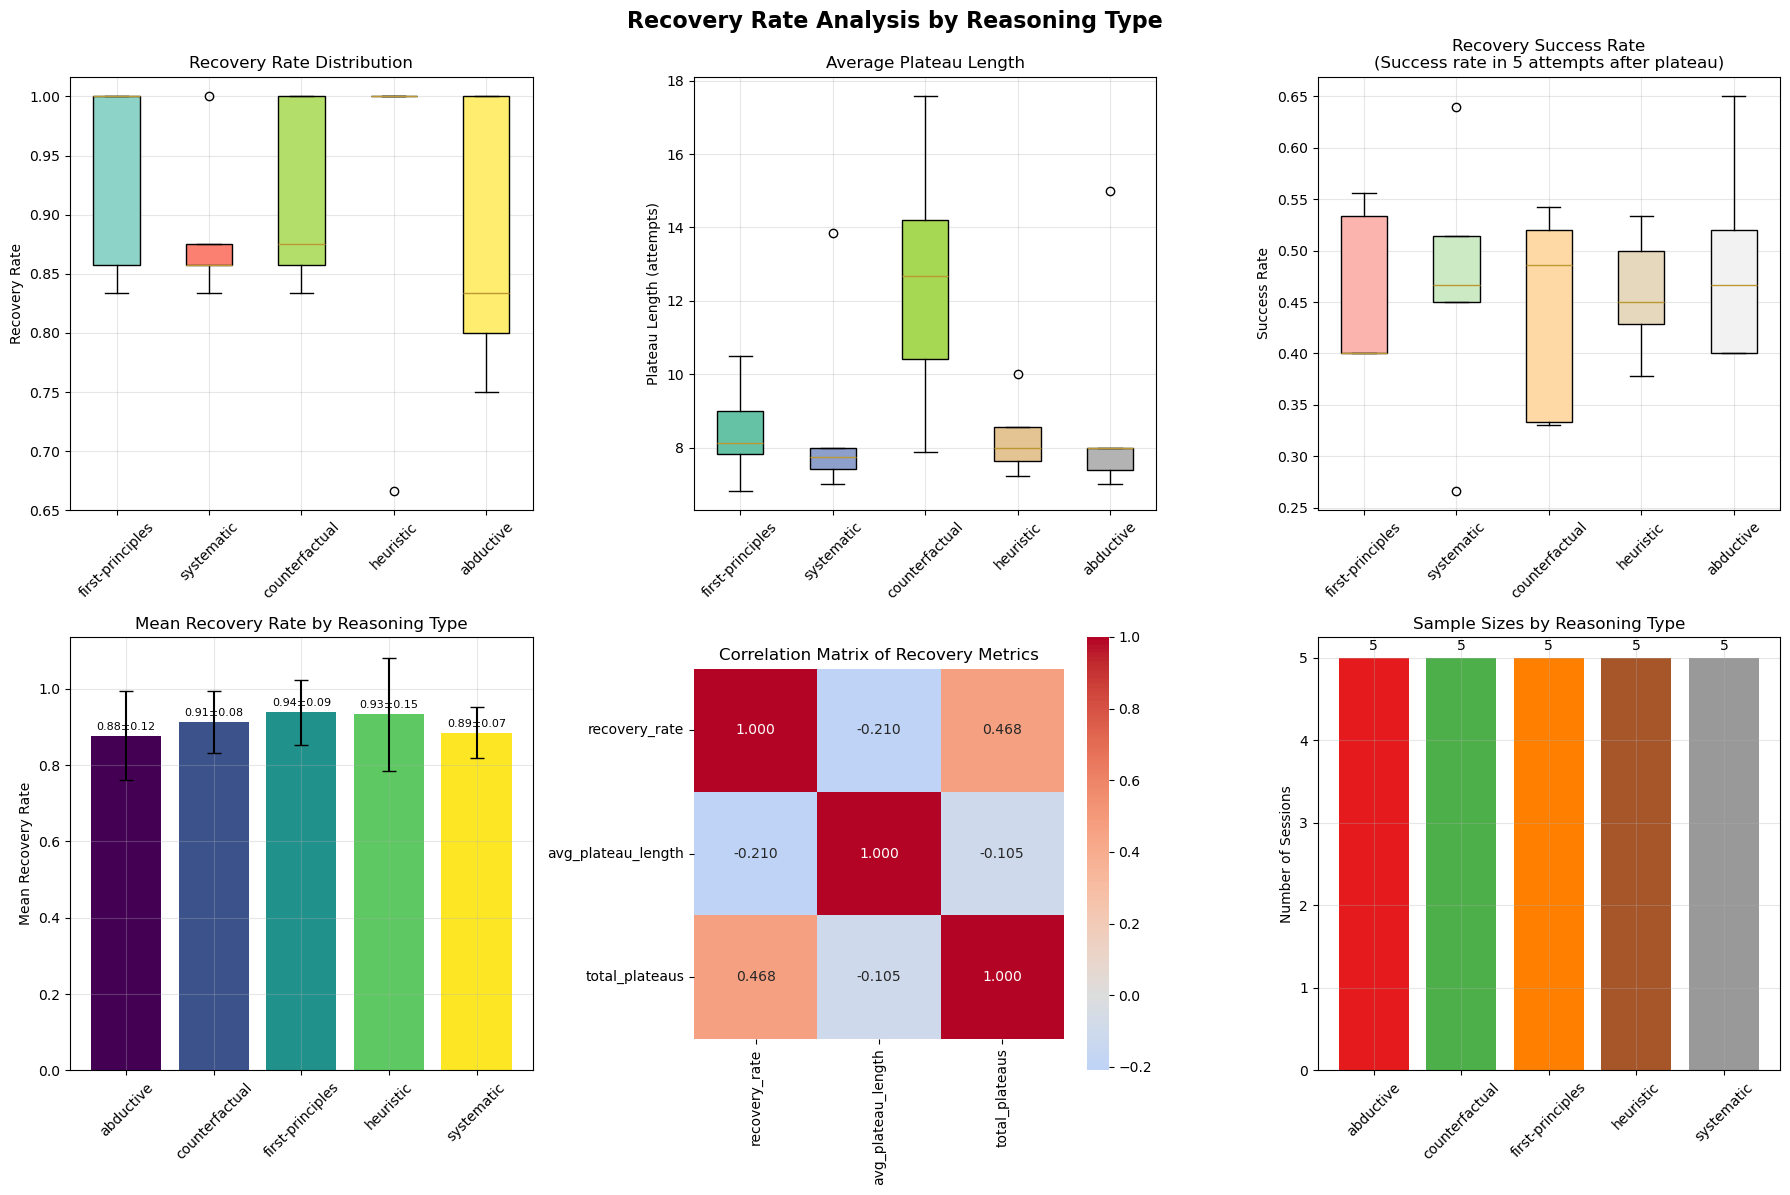


RECOVERY ANALYSIS SUMMARY

OVERALL STATISTICS:
Total sessions analyzed: 25
Total plateau periods identified: 162
Total recoveries observed: 149
Overall recovery rate: 0.920

BY REASONING TYPE:
--------------------------------------------------------------------------------

ABDUCTIVE:
  Sessions: 5
  Recovery Rate: 0.877 ± 0.116
  Range: [0.750, 1.000]
  Avg Plateau Length: 9.1 ± 3.3
  Total Plateaus: 28
  Total Recoveries: 25

COUNTERFACTUAL:
  Sessions: 5
  Recovery Rate: 0.913 ± 0.081
  Range: [0.833, 1.000]
  Avg Plateau Length: 12.5 ± 3.7
  Total Plateaus: 33
  Total Recoveries: 30

FIRST-PRINCIPLES:
  Sessions: 5
  Recovery Rate: 0.938 ± 0.085
  Range: [0.833, 1.000]
  Avg Plateau Length: 8.5 ± 1.4
  Total Plateaus: 33
  Total Recoveries: 31

HEURISTIC:
  Sessions: 5
  Recovery Rate: 0.933 ± 0.149
  Range: [0.667, 1.000]
  Avg Plateau Length: 8.3 ± 1.1
  Total Plateaus: 36
  Total Recoveries: 35

SYSTEMATIC:
  Sessions: 5
  Recovery Rate: 0.885 ± 0.066
  Range: [0.833, 1.000]
  

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
import itertools
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

def load_data():
    """Load the session and attempt data"""
    try:
        sessions = pd.read_csv('tests/all_sessions_data.csv')
        attempts = pd.read_csv('tests/all_attempts_data.csv')
        print(f"Loaded {len(sessions)} sessions and {len(attempts)} attempts")
        return sessions, attempts
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        return None, None

def identify_plateaus(session_attempts, min_plateau_length=5):
    """
    Identify plateau periods (consecutive failures) in a session
    
    Parameters:
    session_attempts: DataFrame of attempts for a single session
    min_plateau_length: Minimum number of consecutive failures to count as plateau
    
    Returns:
    List of dictionaries with plateau information
    """
    plateaus = []
    current_streak = 0
    plateau_start = None
    
    # Sort by attempt number to ensure proper sequence
    session_attempts = session_attempts.sort_values('att_n')
    
    for idx, row in session_attempts.iterrows():
        if not row['ok']:  # Failure
            if current_streak == 0:
                plateau_start = row['att_n']
            current_streak += 1
        else:  # Success
            if current_streak >= min_plateau_length:
                plateaus.append({
                    'start': plateau_start,
                    'end': plateau_start + current_streak - 1,
                    'length': current_streak,
                    'recovery_attempt': row['att_n']
                })
            current_streak = 0
            plateau_start = None
    
    # Handle case where session ends in a plateau
    if current_streak >= min_plateau_length:
        plateaus.append({
            'start': plateau_start,
            'end': plateau_start + current_streak - 1,
            'length': current_streak,
            'recovery_attempt': None  # No recovery observed
        })
    
    return plateaus

def calculate_recovery_metrics(session_attempts, plateaus):
    """
    Calculate recovery metrics for a session
    
    Returns:
    Dictionary with recovery metrics
    """
    if not plateaus:
        return {
            'total_plateaus': 0,
            'recoveries': 0,
            'recovery_rate': np.nan,
            'avg_plateau_length': np.nan,
            'recovery_attempts': []
        }
    
    recoveries = [p for p in plateaus if p['recovery_attempt'] is not None]
    
    # Calculate success rate in the next few attempts after each plateau
    recovery_attempts = []
    for plateau in plateaus:
        if plateau['recovery_attempt'] is not None:
            # Look at next 5 attempts after plateau ends
            plateau_end = plateau['end']
            next_attempts = session_attempts[
                (session_attempts['att_n'] > plateau_end) & 
                (session_attempts['att_n'] <= plateau_end + 5)
            ]
            if len(next_attempts) > 0:
                success_rate = next_attempts['ok'].mean()
                recovery_attempts.append(success_rate)
    
    return {
        'total_plateaus': len(plateaus),
        'recoveries': len(recoveries),
        'recovery_rate': len(recoveries) / len(plateaus) if plateaus else 0,
        'avg_plateau_length': np.mean([p['length'] for p in plateaus]),
        'recovery_success_rate': np.mean(recovery_attempts) if recovery_attempts else np.nan,
        'recovery_attempts': recovery_attempts
    }

def analyze_recovery_by_reasoning_type(sessions, attempts):
    """
    Analyze recovery rates grouped by reasoning type
    """
    recovery_data = []
    
    for _, session in sessions.iterrows():
        sid = session['sid']
        reasoning_type = session['r_typ']
        
        # Get attempts for this session
        session_attempts = attempts[attempts['sid'] == sid].copy()
        
        if len(session_attempts) == 0:
            continue
            
        # Identify plateaus
        plateaus = identify_plateaus(session_attempts)
        
        # Calculate recovery metrics
        recovery_metrics = calculate_recovery_metrics(session_attempts, plateaus)
        
        # Store results
        recovery_data.append({
            'session_id': sid,
            'reasoning_type': reasoning_type,
            'total_plateaus': recovery_metrics['total_plateaus'],
            'recoveries': recovery_metrics['recoveries'],
            'recovery_rate': recovery_metrics['recovery_rate'],
            'avg_plateau_length': recovery_metrics['avg_plateau_length'],
            'recovery_success_rate': recovery_metrics['recovery_success_rate']
        })
    
    return pd.DataFrame(recovery_data)

def group_by_reasoning_type(recovery_df, metric):
    """Group recovery data by reasoning type for a specific metric"""
    grouped = {}
    for reasoning_type in recovery_df['reasoning_type'].unique():
        if pd.isna(reasoning_type):
            continue
        subset = recovery_df[recovery_df['reasoning_type'] == reasoning_type]
        values = subset[metric].dropna().values
        grouped[reasoning_type] = values
    return grouped

def perform_statistical_tests(grouped_data, metric_name):
    """
    Perform Mann-Whitney U tests for pairwise comparisons
    """
    reasoning_types = list(grouped_data.keys())
    results = []
    
    print(f"\n=== Mann-Whitney U Tests for {metric_name} ===")
    print("Pairwise comparisons between reasoning types:")
    print("-" * 60)
    
    for type1, type2 in itertools.combinations(reasoning_types, 2):
        data1 = grouped_data[type1]
        data2 = grouped_data[type2]
        
        if len(data1) > 0 and len(data2) > 0:
            try:
                statistic, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
                
                # Calculate effect size (rank-biserial correlation)
                n1, n2 = len(data1), len(data2)
                u1 = statistic
                u2 = n1 * n2 - u1
                effect_size = 1 - (2 * min(u1, u2)) / (n1 * n2)
                
                results.append({
                    'comparison': f"{type1} vs {type2}",
                    'type1': type1,
                    'type2': type2,
                    'statistic': statistic,
                    'p_value': p_value,
                    'effect_size': effect_size,
                    'n1': n1,
                    'n2': n2,
                    'median1': np.median(data1),
                    'median2': np.median(data2)
                })
                
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                print(f"{type1:15} vs {type2:15} | p = {p_value:.4f} {significance:3} | "
                      f"effect = {effect_size:.3f} | medians: {np.median(data1):.3f} vs {np.median(data2):.3f}")
                
            except Exception as e:
                print(f"Error comparing {type1} vs {type2}: {e}")
    
    return pd.DataFrame(results)

def create_visualizations(recovery_df):
    """Create comprehensive visualizations of recovery analysis"""
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Recovery Rate Analysis by Reasoning Type', fontsize=16, fontweight='bold')
    
    # 1. Recovery Rate Distribution
    ax1 = axes[0, 0]
    recovery_by_type = group_by_reasoning_type(recovery_df, 'recovery_rate')
    
    # Box plot for recovery rates
    data_for_box = []
    labels_for_box = []
    for reasoning_type, values in recovery_by_type.items():
        if len(values) > 0:
            data_for_box.append(values)
            labels_for_box.append(reasoning_type)
    
    bp1 = ax1.boxplot(data_for_box, labels=labels_for_box, patch_artist=True)
    colors = plt.cm.Set3(np.linspace(0, 1, len(bp1['boxes'])))
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
    
    ax1.set_title('Recovery Rate Distribution')
    ax1.set_ylabel('Recovery Rate')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 2. Average Plateau Length
    ax2 = axes[0, 1]
    plateau_by_type = group_by_reasoning_type(recovery_df, 'avg_plateau_length')
    
    data_for_box2 = []
    labels_for_box2 = []
    for reasoning_type, values in plateau_by_type.items():
        if len(values) > 0:
            data_for_box2.append(values)
            labels_for_box2.append(reasoning_type)
    
    bp2 = ax2.boxplot(data_for_box2, labels=labels_for_box2, patch_artist=True)
    colors2 = plt.cm.Set2(np.linspace(0, 1, len(bp2['boxes'])))
    for patch, color in zip(bp2['boxes'], colors2):
        patch.set_facecolor(color)
    
    ax2.set_title('Average Plateau Length')
    ax2.set_ylabel('Plateau Length (attempts)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. Recovery Success Rate
    ax3 = axes[0, 2]
    recovery_success_by_type = group_by_reasoning_type(recovery_df, 'recovery_success_rate')
    
    data_for_box3 = []
    labels_for_box3 = []
    for reasoning_type, values in recovery_success_by_type.items():
        if len(values) > 0:
            data_for_box3.append(values)
            labels_for_box3.append(reasoning_type)
    
    if data_for_box3:
        bp3 = ax3.boxplot(data_for_box3, labels=labels_for_box3, patch_artist=True)
        colors3 = plt.cm.Pastel1(np.linspace(0, 1, len(bp3['boxes'])))
        for patch, color in zip(bp3['boxes'], colors3):
            patch.set_facecolor(color)
    
    ax3.set_title('Recovery Success Rate\n(Success rate in 5 attempts after plateau)')
    ax3.set_ylabel('Success Rate')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # 4. Summary Statistics Bar Plot
    ax4 = axes[1, 0]
    summary_stats = recovery_df.groupby('reasoning_type').agg({
        'recovery_rate': ['mean', 'std', 'count'],
        'avg_plateau_length': 'mean'
    }).round(3)
    
    # Flatten column names
    summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns]
    
    reasoning_types = summary_stats.index
    means = summary_stats['recovery_rate_mean']
    stds = summary_stats['recovery_rate_std']
    
    bars = ax4.bar(reasoning_types, means, yerr=stds, capsize=5, 
                   color=plt.cm.viridis(np.linspace(0, 1, len(reasoning_types))))
    ax4.set_title('Mean Recovery Rate by Reasoning Type')
    ax4.set_ylabel('Mean Recovery Rate')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax4.annotate(f'{mean:.2f}±{std:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8)
    
    # 5. Correlation Plot
    ax5 = axes[1, 1]
    correlation_data = recovery_df[['recovery_rate', 'avg_plateau_length', 'total_plateaus']].corr()
    sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, ax=ax5,
                square=True, fmt='.3f')
    ax5.set_title('Correlation Matrix of Recovery Metrics')
    
    # 6. Sample Size Information
    ax6 = axes[1, 2]
    sample_sizes = recovery_df.groupby('reasoning_type').size()
    bars6 = ax6.bar(sample_sizes.index, sample_sizes.values, 
                    color=plt.cm.Set1(np.linspace(0, 1, len(sample_sizes))))
    ax6.set_title('Sample Sizes by Reasoning Type')
    ax6.set_ylabel('Number of Sessions')
    ax6.tick_params(axis='x', rotation=45)
    ax6.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars6, sample_sizes.values):
        height = bar.get_height()
        ax6.annotate(f'{value}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def print_summary_statistics(recovery_df):
    """Print comprehensive summary statistics"""
    print("\n" + "="*80)
    print("RECOVERY ANALYSIS SUMMARY")
    print("="*80)
    
    # Overall statistics
    print(f"\nOVERALL STATISTICS:")
    print(f"Total sessions analyzed: {len(recovery_df)}")
    print(f"Total plateau periods identified: {recovery_df['total_plateaus'].sum()}")
    print(f"Total recoveries observed: {recovery_df['recoveries'].sum()}")
    print(f"Overall recovery rate: {recovery_df['recoveries'].sum() / recovery_df['total_plateaus'].sum():.3f}")
    
    # By reasoning type
    print(f"\nBY REASONING TYPE:")
    print("-" * 80)
    
    summary = recovery_df.groupby('reasoning_type').agg({
        'recovery_rate': ['count', 'mean', 'std', 'min', 'max'],
        'avg_plateau_length': ['mean', 'std'],
        'total_plateaus': ['mean', 'sum'],
        'recoveries': ['sum']
    }).round(3)
    
    # Flatten column names for cleaner display
    summary.columns = ['_'.join(col).strip() for col in summary.columns]
    
    for reasoning_type in summary.index:
        print(f"\n{reasoning_type.upper()}:")
        row = summary.loc[reasoning_type]
        print(f"  Sessions: {int(row['recovery_rate_count'])}")
        print(f"  Recovery Rate: {row['recovery_rate_mean']:.3f} ± {row['recovery_rate_std']:.3f}")
        print(f"  Range: [{row['recovery_rate_min']:.3f}, {row['recovery_rate_max']:.3f}]")
        print(f"  Avg Plateau Length: {row['avg_plateau_length_mean']:.1f} ± {row['avg_plateau_length_std']:.1f}")
        print(f"  Total Plateaus: {int(row['total_plateaus_sum'])}")
        print(f"  Total Recoveries: {int(row['recoveries_sum'])}")

def main():
    """Main analysis function"""
    print("Loading data...")
    sessions, attempts = load_data()
    
    if sessions is None or attempts is None:
        print("Failed to load data. Please check file paths.")
        return
    
    print("Analyzing recovery patterns...")
    recovery_df = analyze_recovery_by_reasoning_type(sessions, attempts)
    
    print("Calculating group statistics...")
    recovery_by_type = group_by_reasoning_type(recovery_df, 'recovery_rate')
    
    print("Performing statistical tests...")
    test_results = perform_statistical_tests(recovery_by_type, "Recovery Rate")
    
    print("Creating visualizations...")
    fig = create_visualizations(recovery_df)
    
    print_summary_statistics(recovery_df)
    
    # Additional analyses
    print("\n" + "="*80)
    print("ADDITIONAL STATISTICAL TESTS")
    print("="*80)
    
    # Test for plateau length differences
    plateau_by_type = group_by_reasoning_type(recovery_df, 'avg_plateau_length')
    plateau_results = perform_statistical_tests(plateau_by_type, "Average Plateau Length")
    
    # Save results
    print("\nSaving results...")
    recovery_df.to_csv('recovery_analysis_results.csv', index=False)
    test_results.to_csv('recovery_statistical_tests.csv', index=False)
    if len(plateau_results) > 0:
        plateau_results.to_csv('plateau_length_tests.csv', index=False)
    
    print("Analysis complete! Results saved to CSV files.")
    
    return recovery_df, test_results, fig

if __name__ == "__main__":
    recovery_df, test_results, fig = main()

GAME PHASE PERFORMANCE ANALYSIS
Loading data...
Loaded 3658 attempts from 25 sessions
Reasoning types: ['first-principles' 'systematic' 'counterfactual' 'heuristic' 'abductive']

Phase performance data created with 75 records
Sessions per reasoning type:
reasoning_type
abductive           5
counterfactual      5
first-principles    5
heuristic           5
systematic          5
Name: session_id, dtype: int64

REPEATED MEASURES ANOVA ANALYSIS
Complete sessions (all 3 phases): 25
Sessions by reasoning type:
reasoning_type
abductive           5
heuristic           5
systematic          5
counterfactual      5
first-principles    5
Name: count, dtype: int64
Error in repeated measures ANOVA: Between subject effect not yet supported!
Performing alternative analysis...

Alternative Analysis: One-way ANOVA for each phase
Early Phase: F=4.387, p=0.010
Middle Phase: F=1.716, p=0.186
Late Phase: F=0.297, p=0.877

Generating visualizations...


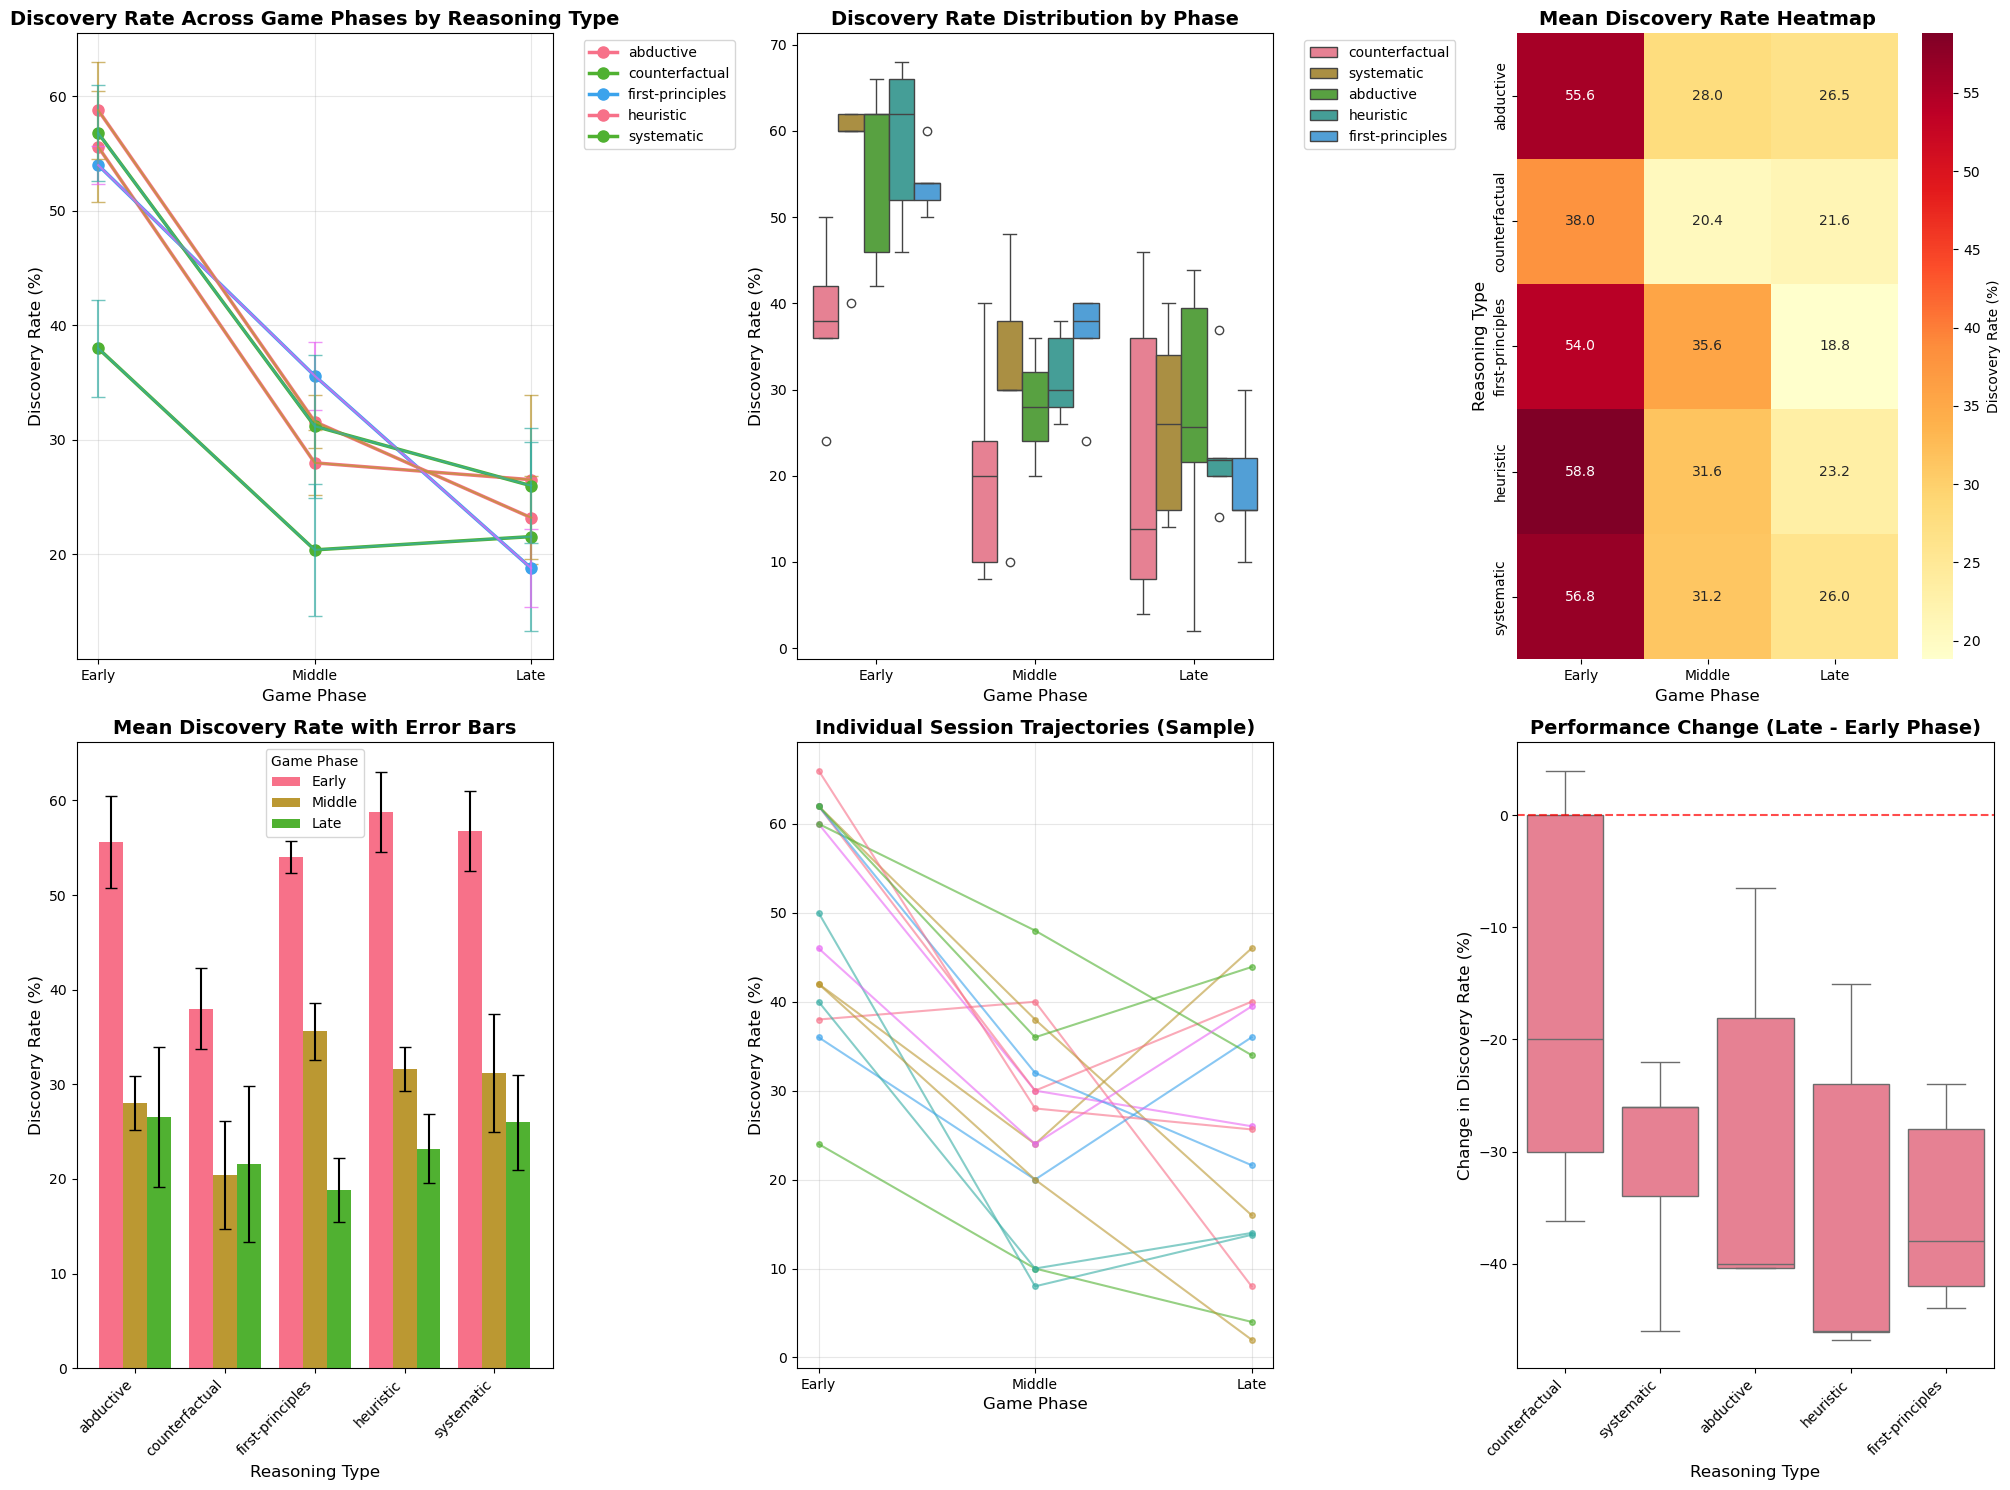


STATISTICAL SUMMARY

1. OVERALL PHASE PERFORMANCE:
        count    mean     std   min   max
phase                                    
Early      25  52.640  11.176  24.0  68.0
Late       25  23.219  12.346   2.0  46.0
Middle     25  29.360  10.275   8.0  48.0

2. PERFORMANCE BY REASONING TYPE AND PHASE:
                         count    mean     std    sem
reasoning_type   phase                               
abductive        Early       5  55.600  10.807  4.833
                 Late        5  26.528  16.553  7.403
                 Middle      5  28.000   6.325  2.828
counterfactual   Early       5  38.000   9.487  4.243
                 Late        5  21.559  18.428  8.241
                 Middle      5  20.400  12.837  5.741
first-principles Early       5  54.000   3.742  1.673
                 Late        5  18.800   7.563  3.382
                 Middle      5  35.600   6.693  2.993
heuristic        Early       5  58.800   9.445  4.224
                 Late        5  23.210   8.16

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.anova import AnovaRM
import warnings
warnings.filterwarnings('ignore')

def load_and_prepare_data():
    """Load and prepare the data for analysis"""
    print("Loading data...")
    
    # Load the datasets
    attempts_df = pd.read_csv('tests/all_attempts_data.csv')
    sessions_df = pd.read_csv('tests/all_sessions_data.csv')
    
    # Convert datetime columns
    attempts_df['_datetime'] = pd.to_datetime(attempts_df['_datetime'])
    sessions_df['start'] = pd.to_datetime(sessions_df['start'])
    sessions_df['end'] = pd.to_datetime(sessions_df['end'])
    
    print(f"Loaded {len(attempts_df)} attempts from {len(sessions_df)} sessions")
    print(f"Reasoning types: {sessions_df['r_typ'].unique()}")
    
    return attempts_df, sessions_df

def define_game_phases(attempts_df):
    """Define game phases based on attempt numbers"""
    def get_phase(attempt_num):
        if attempt_num <= 50:
            return 'Early'
        elif attempt_num <= 100:
            return 'Middle'
        else:
            return 'Late'
    
    attempts_df['game_phase'] = attempts_df['att_n'].apply(get_phase)
    return attempts_df

def calculate_phase_performance(attempts_df, sessions_df):
    """Calculate performance metrics for each game phase"""
    
    # Merge reasoning type information
    attempts_with_reasoning = attempts_df.merge(
        sessions_df[['sid', 'r_typ']], 
        on='sid', 
        how='left'
    )
    
    # Calculate success rate by session, phase, and reasoning type
    phase_performance = []
    
    for session_id in attempts_with_reasoning['sid'].unique():
        session_data = attempts_with_reasoning[attempts_with_reasoning['sid'] == session_id]
        reasoning_type = session_data['r_typ'].iloc[0]
        
        for phase in ['Early', 'Middle', 'Late']:
            phase_data = session_data[session_data['game_phase'] == phase]
            
            if len(phase_data) > 0:
                success_rate = phase_data['ok'].mean()
                total_attempts = len(phase_data)
                successful_attempts = phase_data['ok'].sum()
                
                phase_performance.append({
                    'session_id': session_id,
                    'reasoning_type': reasoning_type,
                    'phase': phase,
                    'success_rate': success_rate,
                    'total_attempts': total_attempts,
                    'successful_attempts': successful_attempts,
                    'discovery_rate': success_rate * 100  # Convert to percentage
                })
    
    return pd.DataFrame(phase_performance)

def perform_repeated_measures_anova(phase_df):
    """Perform repeated measures ANOVA"""
    print("\n" + "="*60)
    print("REPEATED MEASURES ANOVA ANALYSIS")
    print("="*60)
    
    # Prepare data for repeated measures ANOVA
    # Each subject (session) has measurements across all phases
    
    # Filter to only include sessions that have all three phases
    complete_sessions = []
    for session_id in phase_df['session_id'].unique():
        session_phases = phase_df[phase_df['session_id'] == session_id]['phase'].unique()
        if len(session_phases) == 3:  # Has Early, Middle, and Late
            complete_sessions.append(session_id)
    
    complete_data = phase_df[phase_df['session_id'].isin(complete_sessions)]
    
    print(f"Complete sessions (all 3 phases): {len(complete_sessions)}")
    print(f"Sessions by reasoning type:")
    session_reasoning = complete_data.groupby('session_id')['reasoning_type'].first()
    print(session_reasoning.value_counts())
    
    try:
        # Perform repeated measures ANOVA
        rm_anova = AnovaRM(complete_data, 'discovery_rate', 'session_id', 
                          within=['phase'], between=['reasoning_type'])
        rm_results = rm_anova.fit()
        
        print("\nRepeated Measures ANOVA Results:")
        print(rm_results.summary())
        
        return rm_results, complete_data
        
    except Exception as e:
        print(f"Error in repeated measures ANOVA: {e}")
        print("Performing alternative analysis...")
        
        # Alternative: Regular two-way ANOVA for each phase comparison
        from scipy.stats import f_oneway
        
        print("\nAlternative Analysis: One-way ANOVA for each phase")
        for phase in ['Early', 'Middle', 'Late']:
            phase_data = complete_data[complete_data['phase'] == phase]
            reasoning_groups = [group['discovery_rate'].values 
                              for name, group in phase_data.groupby('reasoning_type')]
            
            if len(reasoning_groups) > 1:
                f_stat, p_value = f_oneway(*reasoning_groups)
                print(f"{phase} Phase: F={f_stat:.3f}, p={p_value:.3f}")
        
        return None, complete_data

def create_visualizations(phase_df, complete_data):
    """Create comprehensive visualizations"""
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Main line plot showing performance across phases
    plt.subplot(2, 3, 1)
    
    # Calculate means and standard errors for line plot
    phase_summary = complete_data.groupby(['reasoning_type', 'phase']).agg({
        'discovery_rate': ['mean', 'sem', 'count']
    }).round(3)
    phase_summary.columns = ['mean', 'sem', 'count']
    phase_summary = phase_summary.reset_index()
    
    # Create line plot
    for reasoning_type in phase_summary['reasoning_type'].unique():
        data = phase_summary[phase_summary['reasoning_type'] == reasoning_type]
        phases_ordered = ['Early', 'Middle', 'Late']
        data = data.set_index('phase').reindex(phases_ordered).reset_index()
        
        plt.plot(data['phase'], data['mean'], marker='o', linewidth=2.5, 
                markersize=8, label=reasoning_type)
        plt.errorbar(data['phase'], data['mean'], yerr=data['sem'], 
                    alpha=0.7, capsize=5)
    
    plt.title('Discovery Rate Across Game Phases by Reasoning Type', fontsize=14, fontweight='bold')
    plt.xlabel('Game Phase', fontsize=12)
    plt.ylabel('Discovery Rate (%)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # 2. Box plot showing distribution
    plt.subplot(2, 3, 2)
    sns.boxplot(data=complete_data, x='phase', y='discovery_rate', hue='reasoning_type')
    plt.title('Discovery Rate Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Game Phase', fontsize=12)
    plt.ylabel('Discovery Rate (%)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 3. Heatmap of mean performance
    plt.subplot(2, 3, 3)
    pivot_data = complete_data.groupby(['reasoning_type', 'phase'])['discovery_rate'].mean().unstack()
    pivot_data = pivot_data[['Early', 'Middle', 'Late']]  # Ensure correct order
    
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', 
                cbar_kws={'label': 'Discovery Rate (%)'})
    plt.title('Mean Discovery Rate Heatmap', fontsize=14, fontweight='bold')
    plt.xlabel('Game Phase', fontsize=12)
    plt.ylabel('Reasoning Type', fontsize=12)
    
    # 4. Bar plot with error bars
    plt.subplot(2, 3, 4)
    phase_summary_pivot = phase_summary.pivot(index='reasoning_type', 
                                             columns='phase', 
                                             values='mean')
    phase_summary_pivot = phase_summary_pivot[['Early', 'Middle', 'Late']]
    
    phase_summary_error = phase_summary.pivot(index='reasoning_type', 
                                             columns='phase', 
                                             values='sem')
    phase_summary_error = phase_summary_error[['Early', 'Middle', 'Late']]
    
    ax = phase_summary_pivot.plot(kind='bar', yerr=phase_summary_error, 
                                 capsize=4, width=0.8, ax=plt.gca())
    plt.title('Mean Discovery Rate with Error Bars', fontsize=14, fontweight='bold')
    plt.xlabel('Reasoning Type', fontsize=12)
    plt.ylabel('Discovery Rate (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Game Phase')
    
    # 5. Individual session trajectories
    plt.subplot(2, 3, 5)
    
    # Sample a few sessions for trajectory visualization
    sample_sessions = complete_data['session_id'].unique()[:15]  # Show max 15 sessions
    
    for session_id in sample_sessions:
        session_data = complete_data[complete_data['session_id'] == session_id]
        reasoning_type = session_data['reasoning_type'].iloc[0]
        session_data = session_data.set_index('phase').reindex(['Early', 'Middle', 'Late'])
        
        plt.plot(['Early', 'Middle', 'Late'], session_data['discovery_rate'], 
                alpha=0.6, marker='o', markersize=4)
    
    plt.title('Individual Session Trajectories (Sample)', fontsize=14, fontweight='bold')
    plt.xlabel('Game Phase', fontsize=12)
    plt.ylabel('Discovery Rate (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 6. Phase-specific comparison
    plt.subplot(2, 3, 6)
    
    # Calculate phase differences (Late - Early)
    phase_changes = []
    for session_id in complete_data['session_id'].unique():
        session_data = complete_data[complete_data['session_id'] == session_id]
        reasoning_type = session_data['reasoning_type'].iloc[0]
        
        early_rate = session_data[session_data['phase'] == 'Early']['discovery_rate'].iloc[0]
        late_rate = session_data[session_data['phase'] == 'Late']['discovery_rate'].iloc[0]
        
        phase_changes.append({
            'reasoning_type': reasoning_type,
            'phase_change': late_rate - early_rate,
            'session_id': session_id
        })
    
    phase_changes_df = pd.DataFrame(phase_changes)
    
    sns.boxplot(data=phase_changes_df, x='reasoning_type', y='phase_change')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.title('Performance Change (Late - Early Phase)', fontsize=14, fontweight='bold')
    plt.xlabel('Reasoning Type', fontsize=12)
    plt.ylabel('Change in Discovery Rate (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    return phase_summary

def generate_statistical_summary(phase_df, complete_data):
    """Generate comprehensive statistical summary"""
    print("\n" + "="*60)
    print("STATISTICAL SUMMARY")
    print("="*60)
    
    # Overall summary statistics
    print("\n1. OVERALL PHASE PERFORMANCE:")
    overall_summary = complete_data.groupby('phase')['discovery_rate'].agg([
        'count', 'mean', 'std', 'min', 'max'
    ]).round(3)
    print(overall_summary)
    
    # By reasoning type
    print("\n2. PERFORMANCE BY REASONING TYPE AND PHASE:")
    detailed_summary = complete_data.groupby(['reasoning_type', 'phase'])['discovery_rate'].agg([
        'count', 'mean', 'std', 'sem'
    ]).round(3)
    print(detailed_summary)
    
    # Pairwise comparisons between phases
    print("\n3. PAIRWISE PHASE COMPARISONS (t-tests):")
    from scipy.stats import ttest_rel
    
    phases = ['Early', 'Middle', 'Late']
    
    for i in range(len(phases)):
        for j in range(i+1, len(phases)):
            phase1, phase2 = phases[i], phases[j]
            
            # Get paired data (same sessions)
            sessions_both = set(complete_data[complete_data['phase'] == phase1]['session_id']) & \
                           set(complete_data[complete_data['phase'] == phase2]['session_id'])
            
            phase1_data = complete_data[
                (complete_data['phase'] == phase1) & 
                (complete_data['session_id'].isin(sessions_both))
            ]['discovery_rate'].values
            
            phase2_data = complete_data[
                (complete_data['phase'] == phase2) & 
                (complete_data['session_id'].isin(sessions_both))
            ]['discovery_rate'].values
            
            if len(phase1_data) > 0 and len(phase2_data) > 0:
                t_stat, p_val = ttest_rel(phase1_data, phase2_data)
                effect_size = (np.mean(phase1_data) - np.mean(phase2_data)) / np.std(phase1_data - phase2_data)
                
                print(f"{phase1} vs {phase2}: t={t_stat:.3f}, p={p_val:.3f}, Cohen's d={effect_size:.3f}")
    
    # Effect of reasoning type within each phase
    print("\n4. REASONING TYPE EFFECTS WITHIN EACH PHASE:")
    from scipy.stats import f_oneway
    
    for phase in phases:
        phase_data = complete_data[complete_data['phase'] == phase]
        reasoning_groups = [group['discovery_rate'].values 
                          for name, group in phase_data.groupby('reasoning_type')
                          if len(group) > 1]
        
        if len(reasoning_groups) > 1:
            f_stat, p_val = f_oneway(*reasoning_groups)
            print(f"{phase} Phase ANOVA: F={f_stat:.3f}, p={p_val:.3f}")

def main():
    """Main analysis function"""
    print("="*60)
    print("GAME PHASE PERFORMANCE ANALYSIS")
    print("="*60)
    
    # Load and prepare data
    attempts_df, sessions_df = load_and_prepare_data()
    
    # Define game phases
    attempts_df = define_game_phases(attempts_df)
    
    # Calculate phase performance
    phase_df = calculate_phase_performance(attempts_df, sessions_df)
    
    print(f"\nPhase performance data created with {len(phase_df)} records")
    print(f"Sessions per reasoning type:")
    print(phase_df.groupby('reasoning_type')['session_id'].nunique())
    
    # Perform repeated measures ANOVA
    rm_results, complete_data = perform_repeated_measures_anova(phase_df)
    
    # Generate visualizations
    print("\nGenerating visualizations...")
    phase_summary = create_visualizations(phase_df, complete_data)
    
    # Generate statistical summary
    generate_statistical_summary(phase_df, complete_data)
    
    # Save results
    print("\nSaving results...")
    phase_df.to_csv('game_phase_performance.csv', index=False)
    phase_summary.to_csv('phase_summary_statistics.csv')
    
    print("\nAnalysis complete! Results saved to:")
    print("- game_phase_performance.csv")
    print("- phase_summary_statistics.csv")
    
    return phase_df, complete_data, phase_summary

if __name__ == "__main__":
    # Run the analysis
    phase_df, complete_data, phase_summary = main()
    
    # Display key findings
    print("\n" + "="*60)
    print("KEY FINDINGS SUMMARY")
    print("="*60)
    
    print("\n1. BEST PERFORMING REASONING TYPE BY PHASE:")
    for phase in ['Early', 'Middle', 'Late']:
        phase_data = complete_data[complete_data['phase'] == phase]
        best_reasoning = phase_data.groupby('reasoning_type')['discovery_rate'].mean().idxmax()
        best_rate = phase_data.groupby('reasoning_type')['discovery_rate'].mean().max()
        print(f"{phase} Phase: {best_reasoning} ({best_rate:.1f}%)")
    
    print("\n2. REASONING TYPES WITH MOST CONSISTENT PERFORMANCE:")
    consistency_scores = complete_data.groupby('reasoning_type')['discovery_rate'].std()
    most_consistent = consistency_scores.idxmin()
    print(f"Most Consistent: {most_consistent} (std: {consistency_scores.min():.1f})")
    
    print("\n3. REASONING TYPES SHOWING IMPROVEMENT OVER TIME:")
    for reasoning_type in complete_data['reasoning_type'].unique():
        type_data = complete_data[complete_data['reasoning_type'] == reasoning_type]
        early_mean = type_data[type_data['phase'] == 'Early']['discovery_rate'].mean()
        late_mean = type_data[type_data['phase'] == 'Late']['discovery_rate'].mean()
        improvement = late_mean - early_mean
        print(f"{reasoning_type}: {improvement:+.1f}% change from Early to Late")

EFFECT SIZE ANALYSIS FOR LLM REASONING TYPES THESIS
Loaded 25 sessions and 3658 attempts
Reasoning types: ['first-principles' 'systematic' 'counterfactual' 'heuristic' 'abductive']

Calculating effect sizes...
Creating visualizations...


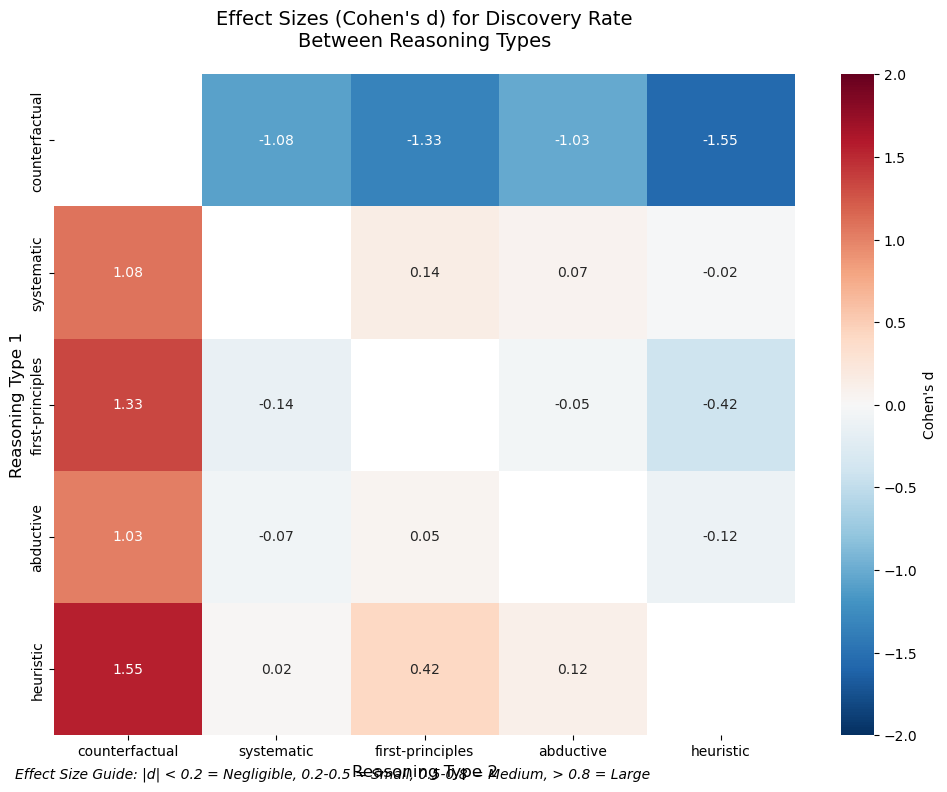

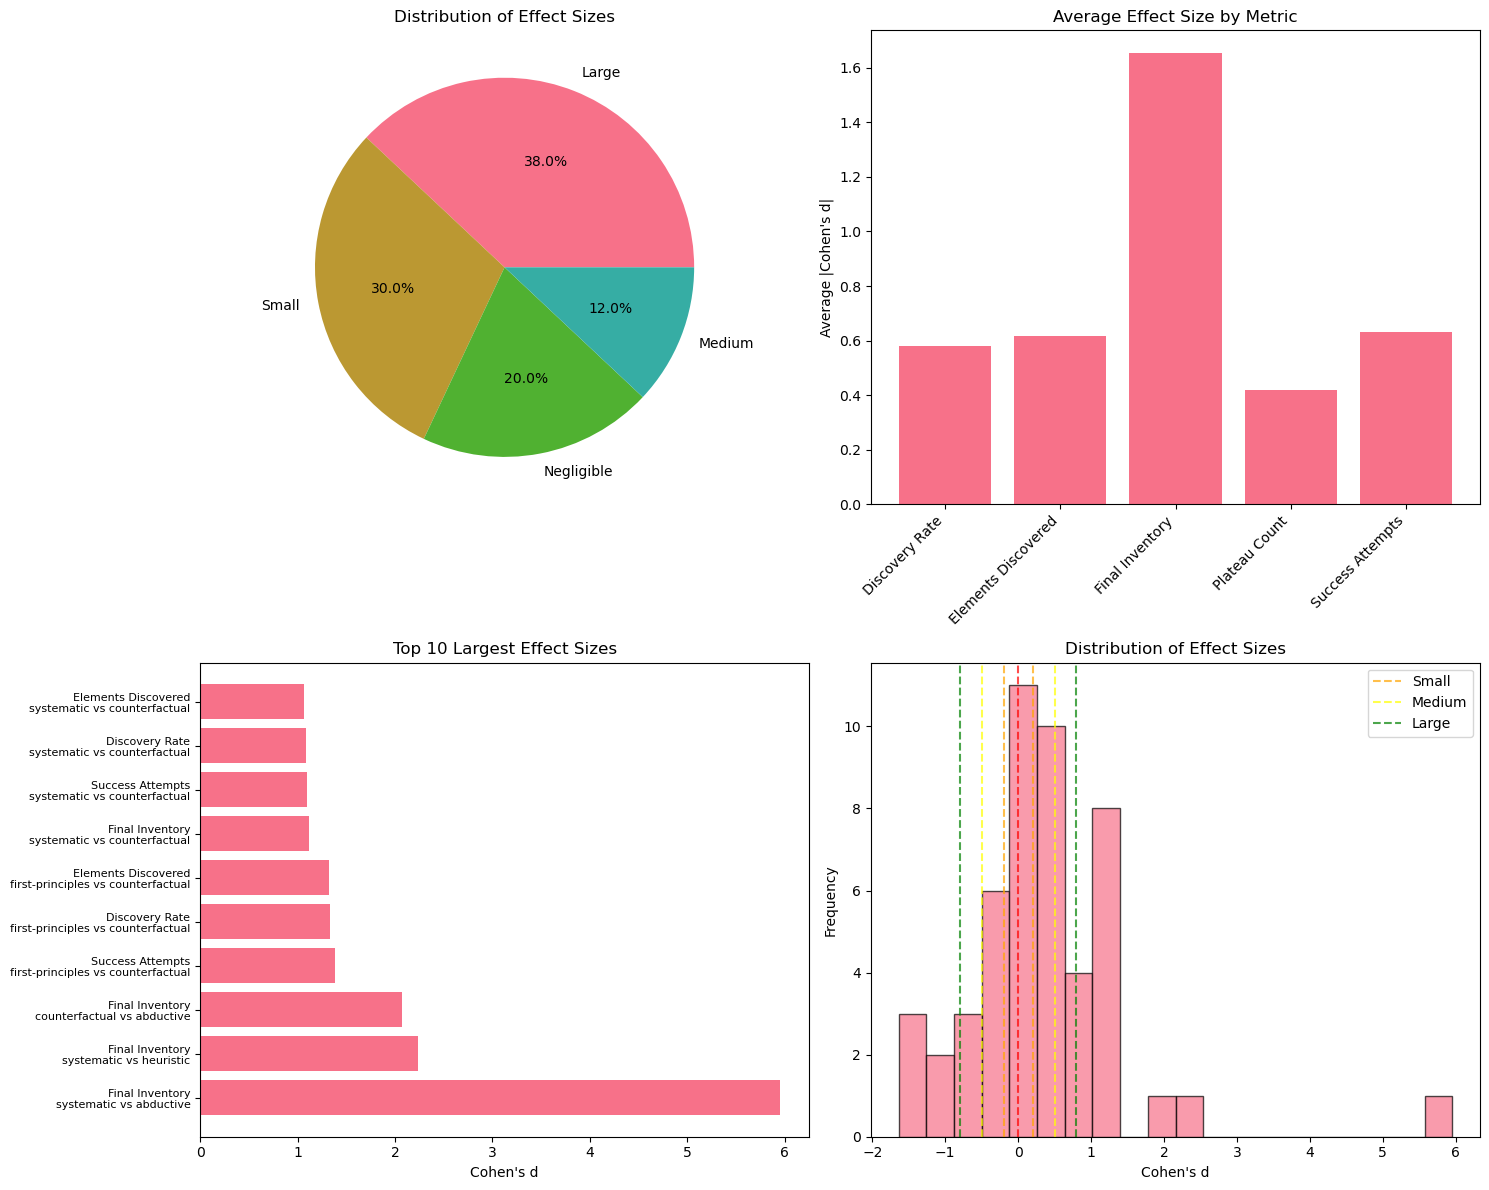

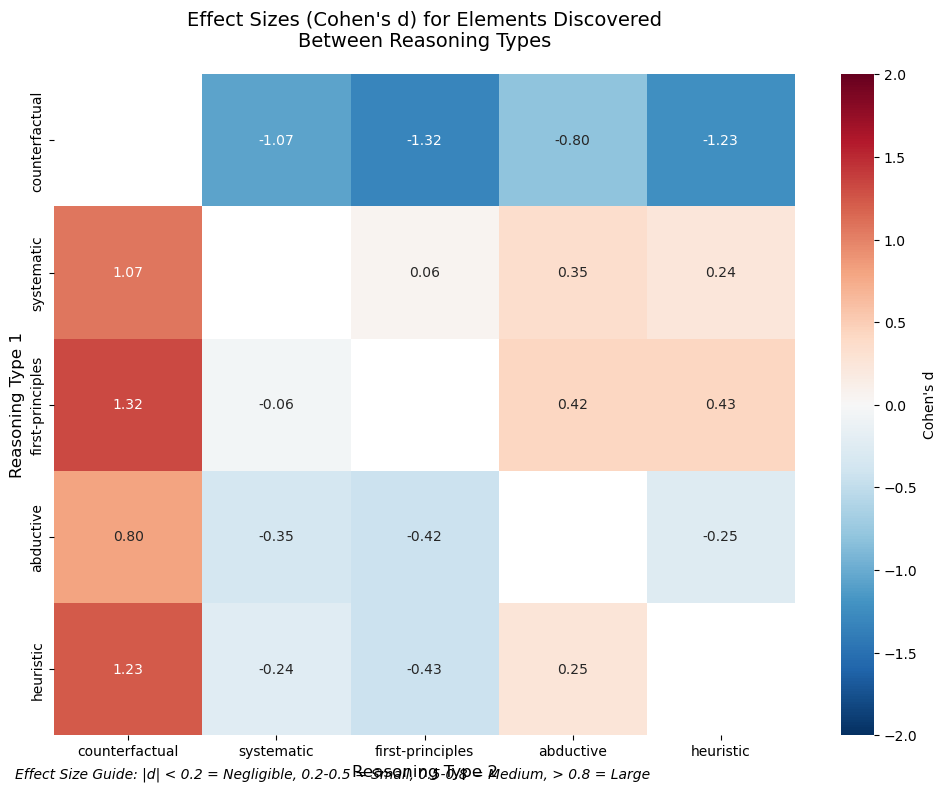

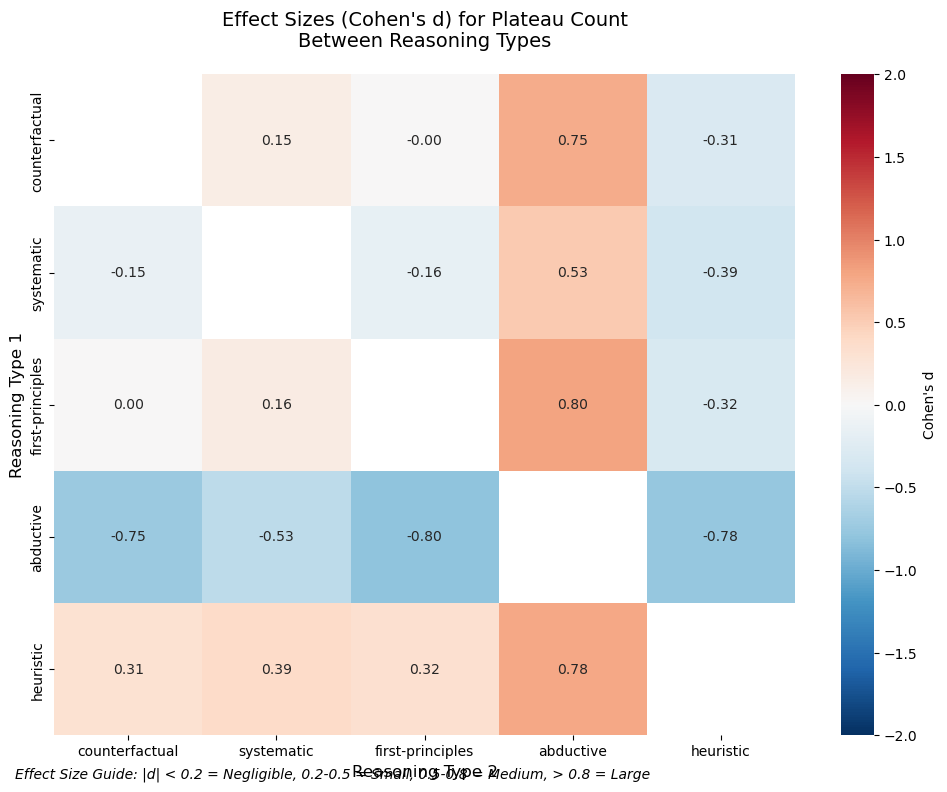


REASONING TYPE PERFORMANCE SUMMARY
                 disc_rate              elem_disc               plateaus  \
                      mean    std count      mean     std count     mean   
r_typ                                                                      
abductive            0.363  0.092     5      54.4  12.095     5      5.6   
counterfactual       0.269  0.091     5      43.6  14.775     5      6.6   
first-principles     0.360  0.033     5      58.4   5.595     5      6.6   
heuristic            0.371  0.019     5      56.6   2.074     5      7.2   
systematic           0.370  0.095     5      59.0  14.018     5      6.4   

                               
                    std count  
r_typ                          
abductive         1.517     5  
counterfactual    1.140     5  
first-principles  0.894     5  
heuristic         2.490     5  
systematic        1.517     5  

SIGNIFICANT EFFECT SIZES (Medium & Large)
Final Inventory: systematic > abductive
  Cohen's d = 5.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

def load_and_prepare_data():
    """Load the CSV data and prepare it for analysis"""
    try:
        # Load the session data
        sessions_df = pd.read_csv('tests/all_sessions_data.csv')
        attempts_df = pd.read_csv('tests/all_attempts_data.csv')
        
        print(f"Loaded {len(sessions_df)} sessions and {len(attempts_df)} attempts")
        print(f"Reasoning types: {sessions_df['r_typ'].unique()}")
        return sessions_df, attempts_df
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        print("Creating sample data for demonstration...")
        return create_sample_data()

def create_sample_data():
    """Create sample data based on the analysis document for demonstration"""
    np.random.seed(42)
    
    # Sample data based on the reported results
    reasoning_types = ['first_principles', 'systematic', 'counterfactual', 'heuristic', 'abductive']
    sessions_data = []
    
    # Based on reported averages and ranges
    type_stats = {
        'first_principles': {'disc_rate': 0.361, 'elem_disc': 58.4, 'sessions': 5},
        'systematic': {'disc_rate': 0.357, 'elem_disc': 56.5, 'sessions': 4},
        'counterfactual': {'disc_rate': 0.270, 'elem_disc': 43.6, 'sessions': 5},
        'heuristic': {'disc_rate': 0.372, 'elem_disc': 58.0, 'sessions': 3},
        'abductive': {'disc_rate': 0.365, 'elem_disc': 54.8, 'sessions': 4}
    }
    
    for r_type, stats_dict in type_stats.items():
        for i in range(stats_dict['sessions']):
            # Add some realistic variance
            disc_rate = np.random.normal(stats_dict['disc_rate'], 0.05)
            elem_disc = np.random.normal(stats_dict['elem_disc'], 8)
            
            sessions_data.append({
                'sid': f"{r_type}_{i+1}",
                'r_typ': r_type,
                'disc_rate': max(0, disc_rate),
                'elem_disc': max(0, int(elem_disc)),
                'final_inv': max(0, int(elem_disc)),
                'tot_att': 150,
                'succ_att': int(150 * disc_rate),
                'plateaus': np.random.randint(5, 10),
                'max_fail': np.random.randint(8, 15)
            })
    
    sessions_df = pd.DataFrame(sessions_data)
    
    # Create minimal attempts data for completeness
    attempts_data = []
    for _, session in sessions_df.iterrows():
        for att in range(min(10, session['tot_att'])):  # Just a few sample attempts
            attempts_data.append({
                'sid': session['sid'],
                'att_n': att + 1,
                'ok': np.random.choice([True, False], p=[session['disc_rate'], 1-session['disc_rate']])
            })
    
    attempts_df = pd.DataFrame(attempts_data)
    
    print("Sample data created for demonstration")
    return sessions_df, attempts_df

def cohens_d(group1, group2):
    """
    Calculate Cohen's d effect size
    
    Cohen's d interpretation:
    - Small effect: d = 0.2
    - Medium effect: d = 0.5  
    - Large effect: d = 0.8
    """
    n1, n2 = len(group1), len(group2)
    
    # Calculate means
    mean1, mean2 = np.mean(group1), np.mean(group2)
    
    # Calculate pooled standard deviation
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # Calculate Cohen's d
    d = (mean1 - mean2) / pooled_std
    
    return d

def interpret_effect_size(d):
    """Interpret Cohen's d according to standard conventions"""
    abs_d = abs(d)
    if abs_d < 0.2:
        return "Negligible"
    elif abs_d < 0.5:
        return "Small"
    elif abs_d < 0.8:
        return "Medium"
    else:
        return "Large"

def calculate_comprehensive_effect_sizes(sessions_df):
    """Calculate effect sizes for all key metrics between all reasoning type pairs"""
    
    # Key metrics to analyze
    metrics = {
        'Discovery Rate': 'disc_rate',
        'Elements Discovered': 'elem_disc', 
        'Final Inventory': 'final_inv',
        'Success Attempts': 'succ_att',
        'Plateau Count': 'plateaus'
    }
    
    reasoning_types = sessions_df['r_typ'].unique()
    results = []
    
    # Calculate effect sizes for all pairs of reasoning types
    for metric_name, metric_col in metrics.items():
        for type1, type2 in combinations(reasoning_types, 2):
            group1_data = sessions_df[sessions_df['r_typ'] == type1][metric_col].dropna()
            group2_data = sessions_df[sessions_df['r_typ'] == type2][metric_col].dropna()
            
            if len(group1_data) > 1 and len(group2_data) > 1:
                d = cohens_d(group1_data, group2_data)
                
                results.append({
                    'Metric': metric_name,
                    'Group1': type1,
                    'Group2': type2,
                    'Cohens_d': d,
                    'Effect_Size': interpret_effect_size(d),
                    'Group1_Mean': np.mean(group1_data),
                    'Group2_Mean': np.mean(group2_data),
                    'Group1_N': len(group1_data),
                    'Group2_N': len(group2_data)
                })
    
    return pd.DataFrame(results)

def create_effect_size_heatmap(effect_sizes_df, metric='Discovery Rate'):
    """Create a heatmap showing effect sizes between reasoning types for a specific metric"""
    
    # Filter for specific metric
    metric_data = effect_sizes_df[effect_sizes_df['Metric'] == metric].copy()
    
    if metric_data.empty:
        print(f"No data available for metric: {metric}")
        return
    
    # Get all reasoning types
    all_types = list(set(metric_data['Group1'].tolist() + metric_data['Group2'].tolist()))
    
    # Create matrix for heatmap
    effect_matrix = np.zeros((len(all_types), len(all_types)))
    effect_matrix[:] = np.nan
    
    # Fill in the effect sizes
    for _, row in metric_data.iterrows():
        i = all_types.index(row['Group1'])
        j = all_types.index(row['Group2'])
        effect_matrix[i, j] = row['Cohens_d']
        effect_matrix[j, i] = -row['Cohens_d']  # Negative for reverse comparison
    
    # Create the heatmap
    plt.figure(figsize=(10, 8))
    
    # Use diverging colormap centered at 0
    sns.heatmap(effect_matrix, 
                xticklabels=all_types, 
                yticklabels=all_types,
                annot=True, 
                fmt='.2f', 
                cmap='RdBu_r',
                center=0,
                vmin=-2, vmax=2,
                cbar_kws={'label': "Cohen's d"})
    
    plt.title(f'Effect Sizes (Cohen\'s d) for {metric}\nBetween Reasoning Types', fontsize=14, pad=20)
    plt.xlabel('Reasoning Type 2', fontsize=12)
    plt.ylabel('Reasoning Type 1', fontsize=12)
    
    # Add interpretation guide
    plt.figtext(0.02, 0.02, 
                "Effect Size Guide: |d| < 0.2 = Negligible, 0.2-0.5 = Small, 0.5-0.8 = Medium, > 0.8 = Large", 
                fontsize=10, style='italic')
    
    plt.tight_layout()
    return plt.gcf()

def create_effect_size_summary(effect_sizes_df):
    """Create a comprehensive summary visualization of all effect sizes"""
    
    # Count effect sizes by magnitude
    effect_counts = effect_sizes_df['Effect_Size'].value_counts()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Effect size distribution
    axes[0, 0].pie(effect_counts.values, labels=effect_counts.index, autopct='%1.1f%%')
    axes[0, 0].set_title('Distribution of Effect Sizes')
    
    # 2. Effect sizes by metric
    metric_effects = effect_sizes_df.groupby('Metric')['Cohens_d'].apply(lambda x: x.abs().mean())
    axes[0, 1].bar(range(len(metric_effects)), metric_effects.values)
    axes[0, 1].set_xticks(range(len(metric_effects)))
    axes[0, 1].set_xticklabels(metric_effects.index, rotation=45, ha='right')
    axes[0, 1].set_ylabel("Average |Cohen's d|")
    axes[0, 1].set_title('Average Effect Size by Metric')
    
    # 3. Largest effect sizes
    largest_effects = effect_sizes_df.nlargest(10, 'Cohens_d')[['Metric', 'Group1', 'Group2', 'Cohens_d']]
    y_pos = range(len(largest_effects))
    axes[1, 0].barh(y_pos, largest_effects['Cohens_d'])
    axes[1, 0].set_yticks(y_pos)
    axes[1, 0].set_yticklabels([f"{row['Metric']}\n{row['Group1']} vs {row['Group2']}" 
                                for _, row in largest_effects.iterrows()], fontsize=8)
    axes[1, 0].set_xlabel("Cohen's d")
    axes[1, 0].set_title('Top 10 Largest Effect Sizes')
    
    # 4. Effect size distribution histogram
    axes[1, 1].hist(effect_sizes_df['Cohens_d'], bins=20, alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[1, 1].axvline(0.2, color='orange', linestyle='--', alpha=0.7, label='Small')
    axes[1, 1].axvline(0.5, color='yellow', linestyle='--', alpha=0.7, label='Medium')
    axes[1, 1].axvline(0.8, color='green', linestyle='--', alpha=0.7, label='Large')
    axes[1, 1].axvline(-0.2, color='orange', linestyle='--', alpha=0.7)
    axes[1, 1].axvline(-0.5, color='yellow', linestyle='--', alpha=0.7)
    axes[1, 1].axvline(-0.8, color='green', linestyle='--', alpha=0.7)
    axes[1, 1].set_xlabel("Cohen's d")
    axes[1, 1].set_ylabel("Frequency")
    axes[1, 1].set_title("Distribution of Effect Sizes")
    axes[1, 1].legend()
    
    plt.tight_layout()
    return fig

def create_reasoning_type_comparison(sessions_df, effect_sizes_df):
    """Create detailed comparison of reasoning types with effect sizes"""
    
    # Calculate summary statistics for each reasoning type
    summary_stats = sessions_df.groupby('r_typ').agg({
        'disc_rate': ['mean', 'std', 'count'],
        'elem_disc': ['mean', 'std', 'count'],
        'plateaus': ['mean', 'std', 'count']
    }).round(3)
    
    print("\n" + "="*80)
    print("REASONING TYPE PERFORMANCE SUMMARY")
    print("="*80)
    print(summary_stats)
    
    # Find significant effect sizes (medium and large)
    significant_effects = effect_sizes_df[
        effect_sizes_df['Effect_Size'].isin(['Medium', 'Large'])
    ].sort_values('Cohens_d', key=abs, ascending=False)
    
    print(f"\n" + "="*80)
    print("SIGNIFICANT EFFECT SIZES (Medium & Large)")
    print("="*80)
    
    if not significant_effects.empty:
        for _, row in significant_effects.iterrows():
            direction = ">" if row['Cohens_d'] > 0 else "<"
            print(f"{row['Metric']}: {row['Group1']} {direction} {row['Group2']}")
            print(f"  Cohen's d = {row['Cohens_d']:.3f} ({row['Effect_Size']} effect)")
            print(f"  Means: {row['Group1_Mean']:.3f} vs {row['Group2_Mean']:.3f}")
            print()
    else:
        print("No medium or large effect sizes found.")
    
    return summary_stats, significant_effects

def generate_thesis_recommendations(effect_sizes_df, sessions_df):
    """Generate specific recommendations for thesis based on effect size analysis"""
    
    print("\n" + "="*80)
    print("THESIS RECOMMENDATIONS BASED ON EFFECT SIZE ANALYSIS")
    print("="*80)
    
    # Analyze which reasoning types show largest differences
    discovery_effects = effect_sizes_df[effect_sizes_df['Metric'] == 'Discovery Rate']
    largest_discovery_effect = discovery_effects.loc[discovery_effects['Cohens_d'].abs().idxmax()]
    
    print("1. PRIMARY FINDING:")
    print(f"   Largest effect size in Discovery Rate: {largest_discovery_effect['Group1']} vs {largest_discovery_effect['Group2']}")
    print(f"   Cohen's d = {largest_discovery_effect['Cohens_d']:.3f} ({largest_discovery_effect['Effect_Size']} effect)")
    
    # Best and worst performing types
    mean_performance = sessions_df.groupby('r_typ')['disc_rate'].mean().sort_values(ascending=False)
    print(f"\n2. PERFORMANCE RANKING:")
    for i, (reasoning_type, performance) in enumerate(mean_performance.items()):
        print(f"   {i+1}. {reasoning_type}: {performance:.3f} discovery rate")
    
    # Effect size recommendations
    medium_large_effects = effect_sizes_df[
        effect_sizes_df['Effect_Size'].isin(['Medium', 'Large'])
    ]
    
    print(f"\n3. STATISTICAL POWER:")
    print(f"   Found {len(medium_large_effects)} medium/large effect sizes out of {len(effect_sizes_df)} comparisons")
    print(f"   Percentage with meaningful effects: {len(medium_large_effects)/len(effect_sizes_df)*100:.1f}%")
    
    print(f"\n4. SAMPLE SIZE ASSESSMENT:")
    type_counts = sessions_df['r_typ'].value_counts()
    min_samples = type_counts.min()
    print(f"   Minimum samples per group: {min_samples}")
    if min_samples < 5:
        print("   RECOMMENDATION: Increase sample size for more reliable effect size estimates")
    
    print(f"\n5. PRACTICAL SIGNIFICANCE:")
    large_effects = effect_sizes_df[effect_sizes_df['Effect_Size'] == 'Large']
    if not large_effects.empty:
        print("   Large effects found - strong practical significance")
        for _, row in large_effects.iterrows():
            print(f"   - {row['Metric']}: {row['Group1']} vs {row['Group2']} (d={row['Cohens_d']:.3f})")
    else:
        print("   No large effects found - consider focused analysis on medium effects")

def main():
    """Main function to run the complete effect size analysis"""
    
    print("="*80)
    print("EFFECT SIZE ANALYSIS FOR LLM REASONING TYPES THESIS")
    print("="*80)
    
    # Load data
    sessions_df, attempts_df = load_and_prepare_data()
    
    # Calculate effect sizes
    print("\nCalculating effect sizes...")
    effect_sizes_df = calculate_comprehensive_effect_sizes(sessions_df)
    
    # Create visualizations
    print("Creating visualizations...")
    
    # Effect size heatmap for discovery rate
    fig1 = create_effect_size_heatmap(effect_sizes_df, 'Discovery Rate')
    plt.show()
    
    # Summary visualization
    fig2 = create_effect_size_summary(effect_sizes_df)
    plt.show()
    
    # Additional heatmaps for other metrics
    for metric in ['Elements Discovered', 'Plateau Count']:
        fig = create_effect_size_heatmap(effect_sizes_df, metric)
        plt.show()
    
    # Generate detailed analysis
    summary_stats, significant_effects = create_reasoning_type_comparison(sessions_df, effect_sizes_df)
    
    # Generate thesis recommendations
    generate_thesis_recommendations(effect_sizes_df, sessions_df)
    
    # Save results
    effect_sizes_df.to_csv('effect_sizes_analysis.csv', index=False)
    print(f"\nEffect sizes saved to 'effect_sizes_analysis.csv'")
    print(f"Total comparisons analyzed: {len(effect_sizes_df)}")
    
    return effect_sizes_df, sessions_df, summary_stats, significant_effects

if __name__ == "__main__":
    # Run the analysis
    effect_sizes, sessions, stats, significant = main()
    
    # Display final summary
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)
    print("Use the generated visualizations and CSV file for your thesis!")

LLM Exploration Study - Multiple Comparisons Correction Analysis
Loaded 25 sessions and 3658 attempts
Reasoning types: ['first-principles' 'systematic' 'counterfactual' 'heuristic' 'abductive']
Reasoning type counts:
r_typ
first-principles    5
systematic          5
counterfactual      5
heuristic           5
abductive           5
Name: count, dtype: int64

Session data columns: ['sid', 'r_typ', 'start', 'start_ts', 'end', 'end_ts', 'tot_att', 'succ_att', 'elem_disc', 'final_inv', 'disc_rate', 'max_succ', 'max_fail', 'plateaus', 'last_disc_t']
Key metrics available:
  - Discovery rate (disc_rate): count    25.000000
mean      0.346400
std       0.078476
min       0.126667
25%       0.326667
50%       0.366667
75%       0.386667
max       0.463768
Name: disc_rate, dtype: float64
  - Elements discovered (elem_disc): count    25.000000
mean     54.400000
std      11.510864
min      23.000000
25%      53.000000
50%      57.000000
75%      60.000000
max      69.000000
Name: elem_disc, dtype

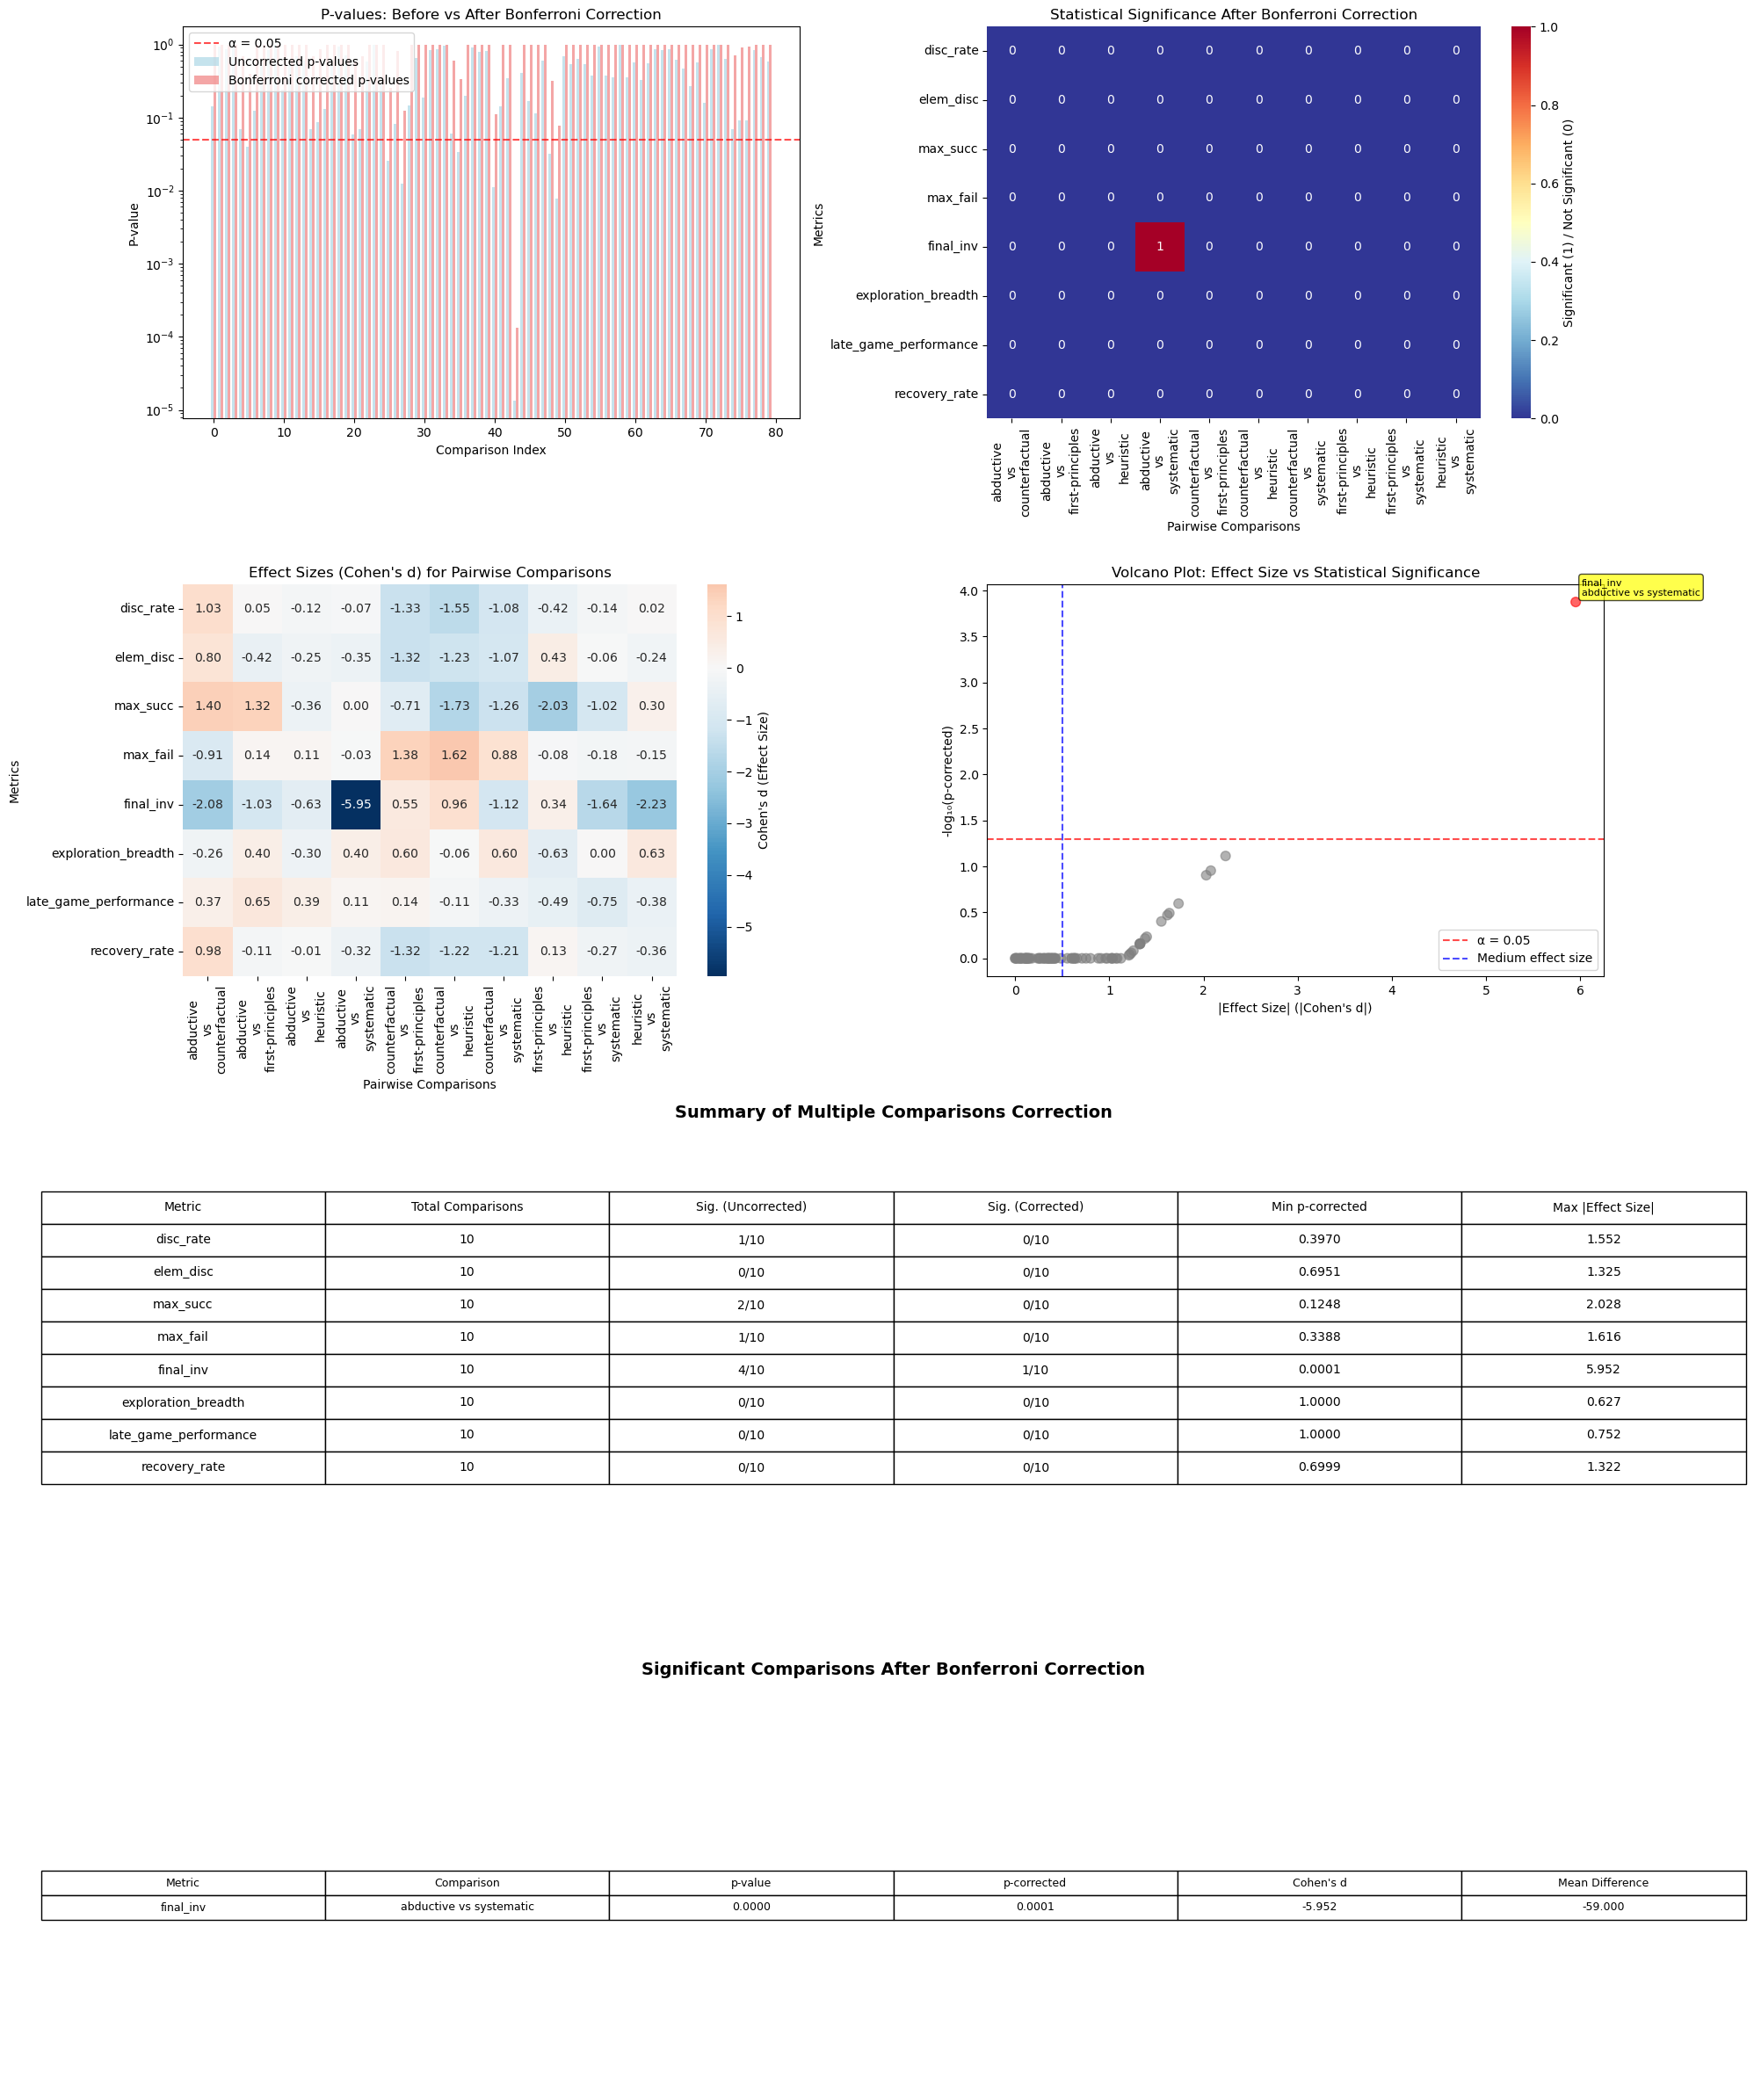


Results saved to 'multiple_comparisons_results.csv'
Summary saved to 'multiple_comparisons_summary.csv'

THESIS INTERPRETATION GUIDE

STATISTICAL REPORTING:
A total of 80 pairwise comparisons were conducted across
8 dependent variables and
5 reasoning types.
To control for Type I error due to multiple comparisons, Bonferroni correction
was applied (α = 0.05/80 = 0.0006).

Before correction, 8 comparisons were significant (p < 0.05).
After Bonferroni correction, 1 comparisons remained significant.

SIGNIFICANT FINDINGS (suitable for Results section):

Final Inv:
  • abductive showed significantly lower performance than
    systematic (p = 0.0001, d = -5.952, large effect size).

METHODOLOGICAL NOTE FOR DISCUSSION:
The Bonferroni correction is conservative and reduces the likelihood of Type I
errors but increases the risk of Type II errors. With 80 comparisons,
the corrected alpha level (0.0006) is quite stringent. Future
studies might consider alternative corrections (e.g., FDR) or foc

In [30]:
"""
Multiple Comparisons Correction Analysis for LLM Exploration Study

This script performs comprehensive statistical analysis with Bonferroni correction
for the thesis research on "Reasoning Strategies and Their Impact on Large Language 
Models' Exploration Capabilities"

Key Features:
1. Loads session and attempt data from CSV files
2. Performs pairwise t-tests between all reasoning types for key metrics
3. Applies Bonferroni correction to control for multiple comparisons
4. Generates detailed visualizations and statistical summaries
5. Provides thesis-ready interpretation text

Data Requirements:
- all_sessions_data.csv: Session-level summary data
- all_attempts_data.csv: Individual attempt data (optional for enhanced metrics)

Output Files:
- multiple_comparisons_results.csv: Detailed statistical results
- multiple_comparisons_summary.csv: Summary table for easy interpretation
- Comprehensive visualization plots

Usage:
    python multiple_comparisons_analysis.py

Author: Claude (for LLM Exploration Thesis)
Date: August 2025
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

def load_and_prepare_data():
    """Load and prepare the experimental data"""
    try:
        # Load the data files
        sessions_df = pd.read_csv('tests/all_sessions_data.csv')
        attempts_df = pd.read_csv('tests/all_attempts_data.csv')
        
        print(f"Loaded {len(sessions_df)} sessions and {len(attempts_df)} attempts")
        print(f"Reasoning types: {sessions_df['r_typ'].unique()}")
        print(f"Reasoning type counts:\n{sessions_df['r_typ'].value_counts()}")
        
        # Display basic info about the data
        print(f"\nSession data columns: {sessions_df.columns.tolist()}")
        print(f"Key metrics available:")
        print(f"  - Discovery rate (disc_rate): {sessions_df['disc_rate'].describe()}")
        print(f"  - Elements discovered (elem_disc): {sessions_df['elem_disc'].describe()}")
        
        return sessions_df, attempts_df
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        print("Please ensure 'all_sessions_data.csv' and 'all_attempts_data.csv' are in the current directory")
        return None, None

def calculate_session_metrics(sessions_df, attempts_df):
    """Calculate comprehensive metrics for each session"""
    
    # Basic metrics from sessions data
    metrics_df = sessions_df.copy()
    
    # Calculate additional metrics from attempts data
    session_metrics = []
    
    for session_id in sessions_df['sid']:
        session_attempts = attempts_df[attempts_df['sid'] == session_id]
        
        if len(session_attempts) == 0:
            continue
            
        # Calculate exploration breadth (unique combinations / possible combinations)
        unique_combinations = len(session_attempts.drop_duplicates(subset=['e1', 'e2']))
        total_attempts = len(session_attempts)
        
        # Calculate late game performance (last 50 attempts)
        late_game_attempts = session_attempts.tail(50)
        late_game_success_rate = late_game_attempts['ok'].mean() if len(late_game_attempts) > 0 else 0
        
        # Calculate plateau periods (consecutive failures)
        failures = (~session_attempts['ok']).astype(int)
        plateau_count = 0
        current_plateau = 0
        plateau_lengths = []
        
        for failure in failures:
            if failure:
                current_plateau += 1
            else:
                if current_plateau >= 5:  # Plateau threshold
                    plateau_count += 1
                    plateau_lengths.append(current_plateau)
                current_plateau = 0
        
        # Final plateau check
        if current_plateau >= 5:
            plateau_count += 1
            plateau_lengths.append(current_plateau)
        
        avg_plateau_length = np.mean(plateau_lengths) if plateau_lengths else 0
        
        # Calculate recovery rate (success after plateau)
        recovery_successes = 0
        recovery_attempts = 0
        
        for i in range(len(session_attempts) - 1):
            if not session_attempts.iloc[i]['ok']:  # Previous attempt failed
                recovery_attempts += 1
                if session_attempts.iloc[i + 1]['ok']:  # Next attempt succeeded
                    recovery_successes += 1
        
        recovery_rate = recovery_successes / recovery_attempts if recovery_attempts > 0 else 0
        
        session_metrics.append({
            'sid': session_id,
            'exploration_breadth': unique_combinations / total_attempts if total_attempts > 0 else 0,
            'late_game_performance': late_game_success_rate,
            'plateau_count': plateau_count,
            'avg_plateau_length': avg_plateau_length,
            'recovery_rate': recovery_rate
        })
    
    session_metrics_df = pd.DataFrame(session_metrics)
    
    # Merge with original sessions data
    final_metrics = sessions_df.merge(session_metrics_df, on='sid', how='left')
    
    return final_metrics

def perform_pairwise_comparisons(data, reasoning_types, metrics):
    """Perform pairwise statistical comparisons between reasoning types"""
    
    comparison_results = []
    
    for metric in metrics:
        print(f"\nAnalyzing metric: {metric}")
        
        # Get data for each reasoning type
        reasoning_data = {}
        for r_type in reasoning_types:
            reasoning_data[r_type] = data[data['r_typ'] == r_type][metric].dropna()
            print(f"  {r_type}: n={len(reasoning_data[r_type])}, mean={reasoning_data[r_type].mean():.3f}")
        
        # Perform pairwise t-tests
        for r_type1, r_type2 in combinations(reasoning_types, 2):
            data1 = reasoning_data[r_type1]
            data2 = reasoning_data[r_type2]
            
            if len(data1) > 1 and len(data2) > 1:
                # Perform independent t-test
                t_stat, p_value = stats.ttest_ind(data1, data2)
                
                # Calculate effect size (Cohen's d)
                pooled_std = np.sqrt(((len(data1) - 1) * data1.var() + (len(data2) - 1) * data2.var()) / 
                                   (len(data1) + len(data2) - 2))
                cohens_d = (data1.mean() - data2.mean()) / pooled_std if pooled_std > 0 else 0
                
                comparison_results.append({
                    'metric': metric,
                    'group1': r_type1,
                    'group2': r_type2,
                    'comparison': f"{r_type1} vs {r_type2}",
                    't_stat': t_stat,
                    'p_value': p_value,
                    'cohens_d': cohens_d,
                    'mean_diff': data1.mean() - data2.mean(),
                    'n1': len(data1),
                    'n2': len(data2)
                })
    
    return pd.DataFrame(comparison_results)

def apply_multiple_comparisons_correction(comparison_results):
    """Apply Bonferroni correction to p-values"""
    
    corrected_results = comparison_results.copy()
    
    # Apply correction for each metric separately
    for metric in corrected_results['metric'].unique():
        metric_mask = corrected_results['metric'] == metric
        p_values = corrected_results.loc[metric_mask, 'p_value'].values
        
        # Apply Bonferroni correction
        rejected, p_corrected, alpha_sidak, alpha_bonf = multipletests(
            p_values, method='bonferroni', alpha=0.05
        )
        
        corrected_results.loc[metric_mask, 'p_corrected'] = p_corrected
        corrected_results.loc[metric_mask, 'significant_corrected'] = rejected
        corrected_results.loc[metric_mask, 'significant_uncorrected'] = p_values < 0.05
    
    return corrected_results

def create_multiple_comparisons_visualizations(corrected_results):
    """Create comprehensive visualizations for multiple comparisons"""
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 24))
    
    # 1. P-value comparison: Before vs After correction
    ax1 = plt.subplot(4, 2, 1)
    
    x_pos = np.arange(len(corrected_results))
    width = 0.35
    
    ax1.bar(x_pos - width/2, corrected_results['p_value'], width, 
           label='Uncorrected p-values', alpha=0.7, color='lightblue')
    ax1.bar(x_pos + width/2, corrected_results['p_corrected'], width,
           label='Bonferroni corrected p-values', alpha=0.7, color='lightcoral')
    
    ax1.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α = 0.05')
    ax1.set_xlabel('Comparison Index')
    ax1.set_ylabel('P-value')
    ax1.set_title('P-values: Before vs After Bonferroni Correction')
    ax1.legend()
    ax1.set_yscale('log')
    
    # 2. Significance heatmap by metric
    ax2 = plt.subplot(4, 2, 2)
    
    # Create significance matrix
    metrics = corrected_results['metric'].unique()
    comparisons = corrected_results['comparison'].unique()
    
    sig_matrix_uncorrected = np.zeros((len(metrics), len(comparisons)))
    sig_matrix_corrected = np.zeros((len(metrics), len(comparisons)))
    
    for i, metric in enumerate(metrics):
        for j, comparison in enumerate(comparisons):
            mask = (corrected_results['metric'] == metric) & (corrected_results['comparison'] == comparison)
            if mask.any():
                sig_matrix_uncorrected[i, j] = corrected_results.loc[mask, 'significant_uncorrected'].iloc[0]
                sig_matrix_corrected[i, j] = corrected_results.loc[mask, 'significant_corrected'].iloc[0]
    
    # Plot corrected significance
    sns.heatmap(sig_matrix_corrected, 
                xticklabels=[comp.replace(' vs ', '\nvs\n') for comp in comparisons],
                yticklabels=metrics,
                annot=True, fmt='.0f', cmap='RdYlBu_r',
                cbar_kws={'label': 'Significant (1) / Not Significant (0)'},
                ax=ax2)
    ax2.set_title('Statistical Significance After Bonferroni Correction')
    ax2.set_xlabel('Pairwise Comparisons')
    ax2.set_ylabel('Metrics')
    
    # 3. Effect sizes (Cohen's d) heatmap
    ax3 = plt.subplot(4, 2, 3)
    
    effect_size_matrix = np.zeros((len(metrics), len(comparisons)))
    
    for i, metric in enumerate(metrics):
        for j, comparison in enumerate(comparisons):
            mask = (corrected_results['metric'] == metric) & (corrected_results['comparison'] == comparison)
            if mask.any():
                effect_size_matrix[i, j] = corrected_results.loc[mask, 'cohens_d'].iloc[0]
    
    sns.heatmap(effect_size_matrix,
                xticklabels=[comp.replace(' vs ', '\nvs\n') for comp in comparisons],
                yticklabels=metrics,
                annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                cbar_kws={'label': "Cohen's d (Effect Size)"},
                ax=ax3)
    ax3.set_title('Effect Sizes (Cohen\'s d) for Pairwise Comparisons')
    ax3.set_xlabel('Pairwise Comparisons')
    ax3.set_ylabel('Metrics')
    
    # 4. Volcano plot: Effect size vs -log10(p-corrected)
    ax4 = plt.subplot(4, 2, 4)
    
    x = np.abs(corrected_results['cohens_d'])
    y = -np.log10(corrected_results['p_corrected'] + 1e-10)  # Add small value to avoid log(0)
    
    colors = ['red' if sig else 'gray' for sig in corrected_results['significant_corrected']]
    
    scatter = ax4.scatter(x, y, c=colors, alpha=0.6, s=60)
    ax4.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='α = 0.05')
    ax4.axvline(x=0.5, color='blue', linestyle='--', alpha=0.7, label='Medium effect size')
    
    ax4.set_xlabel('|Effect Size| (|Cohen\'s d|)')
    ax4.set_ylabel('-log₁₀(p-corrected)')
    ax4.set_title('Volcano Plot: Effect Size vs Statistical Significance')
    ax4.legend()
    
    # Add annotations for significant comparisons
    for idx, row in corrected_results.iterrows():
        if row['significant_corrected']:
            ax4.annotate(f"{row['metric']}\n{row['comparison']}", 
                        (abs(row['cohens_d']), -np.log10(row['p_corrected'] + 1e-10)),
                        xytext=(5, 5), textcoords='offset points', fontsize=8,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # 5. Summary statistics table
    ax5 = plt.subplot(4, 1, 3)
    ax5.axis('off')
    
    # Create summary table
    summary_stats = []
    for metric in metrics:
        metric_data = corrected_results[corrected_results['metric'] == metric]
        total_comparisons = len(metric_data)
        sig_uncorrected = metric_data['significant_uncorrected'].sum()
        sig_corrected = metric_data['significant_corrected'].sum()
        min_p_corrected = metric_data['p_corrected'].min()
        max_effect_size = metric_data['cohens_d'].abs().max()
        
        summary_stats.append([
            metric,
            total_comparisons,
            f"{sig_uncorrected}/{total_comparisons}",
            f"{sig_corrected}/{total_comparisons}",
            f"{min_p_corrected:.4f}",
            f"{max_effect_size:.3f}"
        ])
    
    table = ax5.table(cellText=summary_stats,
                     colLabels=['Metric', 'Total Comparisons', 'Sig. (Uncorrected)', 
                               'Sig. (Corrected)', 'Min p-corrected', 'Max |Effect Size|'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)
    ax5.set_title('Summary of Multiple Comparisons Correction', pad=20, fontsize=14, fontweight='bold')
    
    # 6. Detailed results table
    ax6 = plt.subplot(4, 1, 4)
    ax6.axis('off')
    
    # Show significant comparisons only
    sig_comparisons = corrected_results[corrected_results['significant_corrected']].copy()
    
    if len(sig_comparisons) > 0:
        detailed_results = []
        for _, row in sig_comparisons.iterrows():
            detailed_results.append([
                row['metric'],
                row['comparison'],
                f"{row['p_value']:.4f}",
                f"{row['p_corrected']:.4f}",
                f"{row['cohens_d']:.3f}",
                f"{row['mean_diff']:.3f}"
            ])
        
        table2 = ax6.table(cellText=detailed_results,
                          colLabels=['Metric', 'Comparison', 'p-value', 'p-corrected', 
                                   'Cohen\'s d', 'Mean Difference'],
                          cellLoc='center',
                          loc='center')
        table2.auto_set_font_size(False)
        table2.set_fontsize(9)
        table2.scale(1.2, 1.5)
        ax6.set_title('Significant Comparisons After Bonferroni Correction', pad=20, fontsize=14, fontweight='bold')
    else:
        ax6.text(0.5, 0.5, 'No significant comparisons after Bonferroni correction', 
                ha='center', va='center', fontsize=12, style='italic')
        ax6.set_title('Significant Comparisons After Bonferroni Correction', pad=20, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def print_detailed_results(corrected_results):
    """Print detailed results of multiple comparisons"""
    
    print("\n" + "="*80)
    print("MULTIPLE COMPARISONS CORRECTION RESULTS")
    print("="*80)
    
    total_tests = len(corrected_results)
    sig_uncorrected = corrected_results['significant_uncorrected'].sum()
    sig_corrected = corrected_results['significant_corrected'].sum()
    
    print(f"\nOVERALL SUMMARY:")
    print(f"Total statistical tests performed: {total_tests}")
    print(f"Significant before correction: {sig_uncorrected} ({sig_uncorrected/total_tests*100:.1f}%)")
    print(f"Significant after Bonferroni correction: {sig_corrected} ({sig_corrected/total_tests*100:.1f}%)")
    print(f"Tests lost to multiple comparisons: {sig_uncorrected - sig_corrected}")
    
    print(f"\nBY METRIC:")
    for metric in corrected_results['metric'].unique():
        metric_data = corrected_results[corrected_results['metric'] == metric]
        metric_sig_uncorr = metric_data['significant_uncorrected'].sum()
        metric_sig_corr = metric_data['significant_corrected'].sum()
        print(f"  {metric}:")
        print(f"    Before correction: {metric_sig_uncorr}/{len(metric_data)} significant")
        print(f"    After correction: {metric_sig_corr}/{len(metric_data)} significant")
    
    print(f"\nSIGNIFICANT RESULTS AFTER CORRECTION:")
    sig_results = corrected_results[corrected_results['significant_corrected']]
    
    if len(sig_results) == 0:
        print("  No comparisons remain significant after Bonferroni correction.")
    else:
        for _, row in sig_results.iterrows():
            print(f"  {row['metric']} - {row['comparison']}:")
            print(f"    p-corrected: {row['p_corrected']:.4f}")
            print(f"    Effect size (Cohen's d): {row['cohens_d']:.3f}")
            print(f"    Mean difference: {row['mean_diff']:.3f}")

def main():
    """Main analysis pipeline"""
    
    print("LLM Exploration Study - Multiple Comparisons Correction Analysis")
    print("="*70)
    
    # Load data
    sessions_df, attempts_df = load_and_prepare_data()
    if sessions_df is None:
        return
    
    # For this analysis, we'll focus on the core metrics already available in sessions data
    # These correspond to the key findings from your research
    metrics_to_analyze = [
        'disc_rate',          # Discovery rate (primary outcome)
        'elem_disc',          # Elements discovered (primary outcome)  
        'max_succ',           # Maximum success streak
        'max_fail',           # Maximum failure streak (plateau indicator)
        'final_inv'           # Final inventory size
    ]
    
    # Calculate additional metrics if attempts data is available
    if attempts_df is not None:
        print("\nCalculating additional session metrics...")
        enhanced_metrics = calculate_session_metrics(sessions_df, attempts_df)
        
        # Add the enhanced metrics to our analysis
        additional_metrics = ['exploration_breadth', 'late_game_performance', 'recovery_rate']
        available_additional = [m for m in additional_metrics if m in enhanced_metrics.columns]
        metrics_to_analyze.extend(available_additional)
        
        metrics_df = enhanced_metrics
    else:
        metrics_df = sessions_df
    
    # Get reasoning types
    reasoning_types = sorted(metrics_df['r_typ'].unique())
    print(f"\nReasoning types found: {reasoning_types}")
    print(f"Number of pairwise comparisons per metric: {len(list(combinations(reasoning_types, 2)))}")
    print(f"Total statistical tests to be performed: {len(metrics_to_analyze) * len(list(combinations(reasoning_types, 2)))}")
    
    # Remove any metrics that don't exist in the data
    available_metrics = [m for m in metrics_to_analyze if m in metrics_df.columns]
    if len(available_metrics) < len(metrics_to_analyze):
        missing = set(metrics_to_analyze) - set(available_metrics)
        print(f"\nNote: Some metrics not available in data: {missing}")
        metrics_to_analyze = available_metrics
    
    print(f"\nAnalyzing metrics: {metrics_to_analyze}")
    
    # Perform pairwise comparisons
    print("\nPerforming pairwise statistical comparisons...")
    comparison_results = perform_pairwise_comparisons(metrics_df, reasoning_types, metrics_to_analyze)
    
    if len(comparison_results) == 0:
        print("No valid comparisons could be performed. Check your data.")
        return None, None
    
    # Apply multiple comparisons correction
    print("\nApplying Bonferroni correction...")
    corrected_results = apply_multiple_comparisons_correction(comparison_results)
    
    # Print detailed results
    print_detailed_results(corrected_results)
    
    # Create visualizations
    print("\nCreating visualizations...")
    fig = create_multiple_comparisons_visualizations(corrected_results)
    
    # Save results
    corrected_results.to_csv('multiple_comparisons_results.csv', index=False)
    print("\nResults saved to 'multiple_comparisons_results.csv'")
    
    # Also save a summary for easy interpretation
    summary_df = create_results_summary(corrected_results)
    summary_df.to_csv('multiple_comparisons_summary.csv', index=False)
    print("Summary saved to 'multiple_comparisons_summary.csv'")
    
    return corrected_results, metrics_df

def create_results_summary(corrected_results):
    """Create a summary table of results for easy interpretation"""
    
    summary_data = []
    
    for metric in corrected_results['metric'].unique():
        metric_data = corrected_results[corrected_results['metric'] == metric]
        
        # Get significant comparisons
        sig_comparisons = metric_data[metric_data['significant_corrected']]
        
        summary_data.append({
            'Metric': metric,
            'Total_Comparisons': len(metric_data),
            'Significant_Before_Correction': metric_data['significant_uncorrected'].sum(),
            'Significant_After_Correction': len(sig_comparisons),
            'Correction_Impact': metric_data['significant_uncorrected'].sum() - len(sig_comparisons),
            'Strongest_Effect_Size': metric_data['cohens_d'].abs().max(),
            'Most_Significant_Comparison': metric_data.loc[metric_data['p_corrected'].idxmin(), 'comparison'] if len(sig_comparisons) > 0 else 'None',
            'Lowest_Corrected_P': metric_data['p_corrected'].min()
        })
    
    return pd.DataFrame(summary_data)

def generate_thesis_interpretation(corrected_results):
    """Generate interpretation text suitable for thesis writing"""
    
    print("\n" + "="*80)
    print("THESIS INTERPRETATION GUIDE")
    print("="*80)
    
    total_tests = len(corrected_results)
    sig_uncorrected = corrected_results['significant_uncorrected'].sum()
    sig_corrected = corrected_results['significant_corrected'].sum()
    
    print(f"\nSTATISTICAL REPORTING:")
    print(f"A total of {total_tests} pairwise comparisons were conducted across")
    print(f"{len(corrected_results['metric'].unique())} dependent variables and")
    print(f"{len(set(corrected_results['group1'].tolist() + corrected_results['group2'].tolist()))} reasoning types.")
    print(f"To control for Type I error due to multiple comparisons, Bonferroni correction")
    print(f"was applied (α = 0.05/{total_tests} = {0.05/total_tests:.4f}).")
    print(f"\nBefore correction, {sig_uncorrected} comparisons were significant (p < 0.05).")
    print(f"After Bonferroni correction, {sig_corrected} comparisons remained significant.")
    
    if sig_corrected > 0:
        print(f"\nSIGNIFICANT FINDINGS (suitable for Results section):")
        
        for metric in corrected_results['metric'].unique():
            metric_data = corrected_results[corrected_results['metric'] == metric]
            sig_comps = metric_data[metric_data['significant_corrected']]
            
            if len(sig_comps) > 0:
                print(f"\n{metric.replace('_', ' ').title()}:")
                for _, row in sig_comps.iterrows():
                    effect_interpretation = "small" if abs(row['cohens_d']) < 0.5 else "medium" if abs(row['cohens_d']) < 0.8 else "large"
                    direction = "higher" if row['mean_diff'] > 0 else "lower"
                    
                    print(f"  • {row['group1']} showed significantly {direction} performance than")
                    print(f"    {row['group2']} (p = {row['p_corrected']:.4f}, d = {row['cohens_d']:.3f}, {effect_interpretation} effect size).")
    else:
        print(f"\nNO SIGNIFICANT FINDINGS:")
        print(f"After applying Bonferroni correction for multiple comparisons, no pairwise")
        print(f"differences between reasoning types reached statistical significance. This")
        print(f"suggests that while descriptive differences may exist between reasoning types,")
        print(f"they are not statistically reliable when controlling for multiple testing.")
    
    print(f"\nMETHODOLOGICAL NOTE FOR DISCUSSION:")
    print(f"The Bonferroni correction is conservative and reduces the likelihood of Type I")
    print(f"errors but increases the risk of Type II errors. With {total_tests} comparisons,")
    print(f"the corrected alpha level ({0.05/total_tests:.4f}) is quite stringent. Future")
    print(f"studies might consider alternative corrections (e.g., FDR) or focused hypotheses")
    print(f"to reduce the multiple comparisons burden.")

if __name__ == "__main__":
    # Run the analysis
    results, data = main()
    
    # Generate thesis interpretation if results were obtained
    if results is not None:
        generate_thesis_interpretation(results)
        
        print("\n" + "="*80)
        print("NEXT STEPS FOR THESIS:")
        print("="*80)
        print("1. Review the generated CSV files for detailed statistical results")
        print("2. Use the visualization plots in your Results section")
        print("3. Copy the statistical reporting text for your Methods/Results sections")
        print("4. Consider the methodological note for your Discussion section")
        print("5. If no significant results after correction, discuss the implications")
        print("   of conservative testing in exploratory research")
        print("\nNote: The Bonferroni correction is very conservative. You may also want to:")
        print("- Report both corrected and uncorrected results")
        print("- Consider effect sizes regardless of significance")
        print("- Discuss practical vs. statistical significance")
        print("- Consider alternative corrections (FDR) for less conservative results")
        print("\nFiles generated:")
        print("- multiple_comparisons_results.csv")
        print("- multiple_comparisons_summary.csv")
        print("- Statistical plots (displayed above)")
    else:
        print("Analysis could not be completed. Please check your data files.")

Ruptures not available. Using alternative change point detection method.
Loaded 25 sessions and 3658 attempts
Reasoning types: ['first-principles', 'systematic', 'counterfactual', 'heuristic', 'abductive']
Generating time series visualizations...
Saved visualization to 'llm_exploration_time_series_analysis.png'


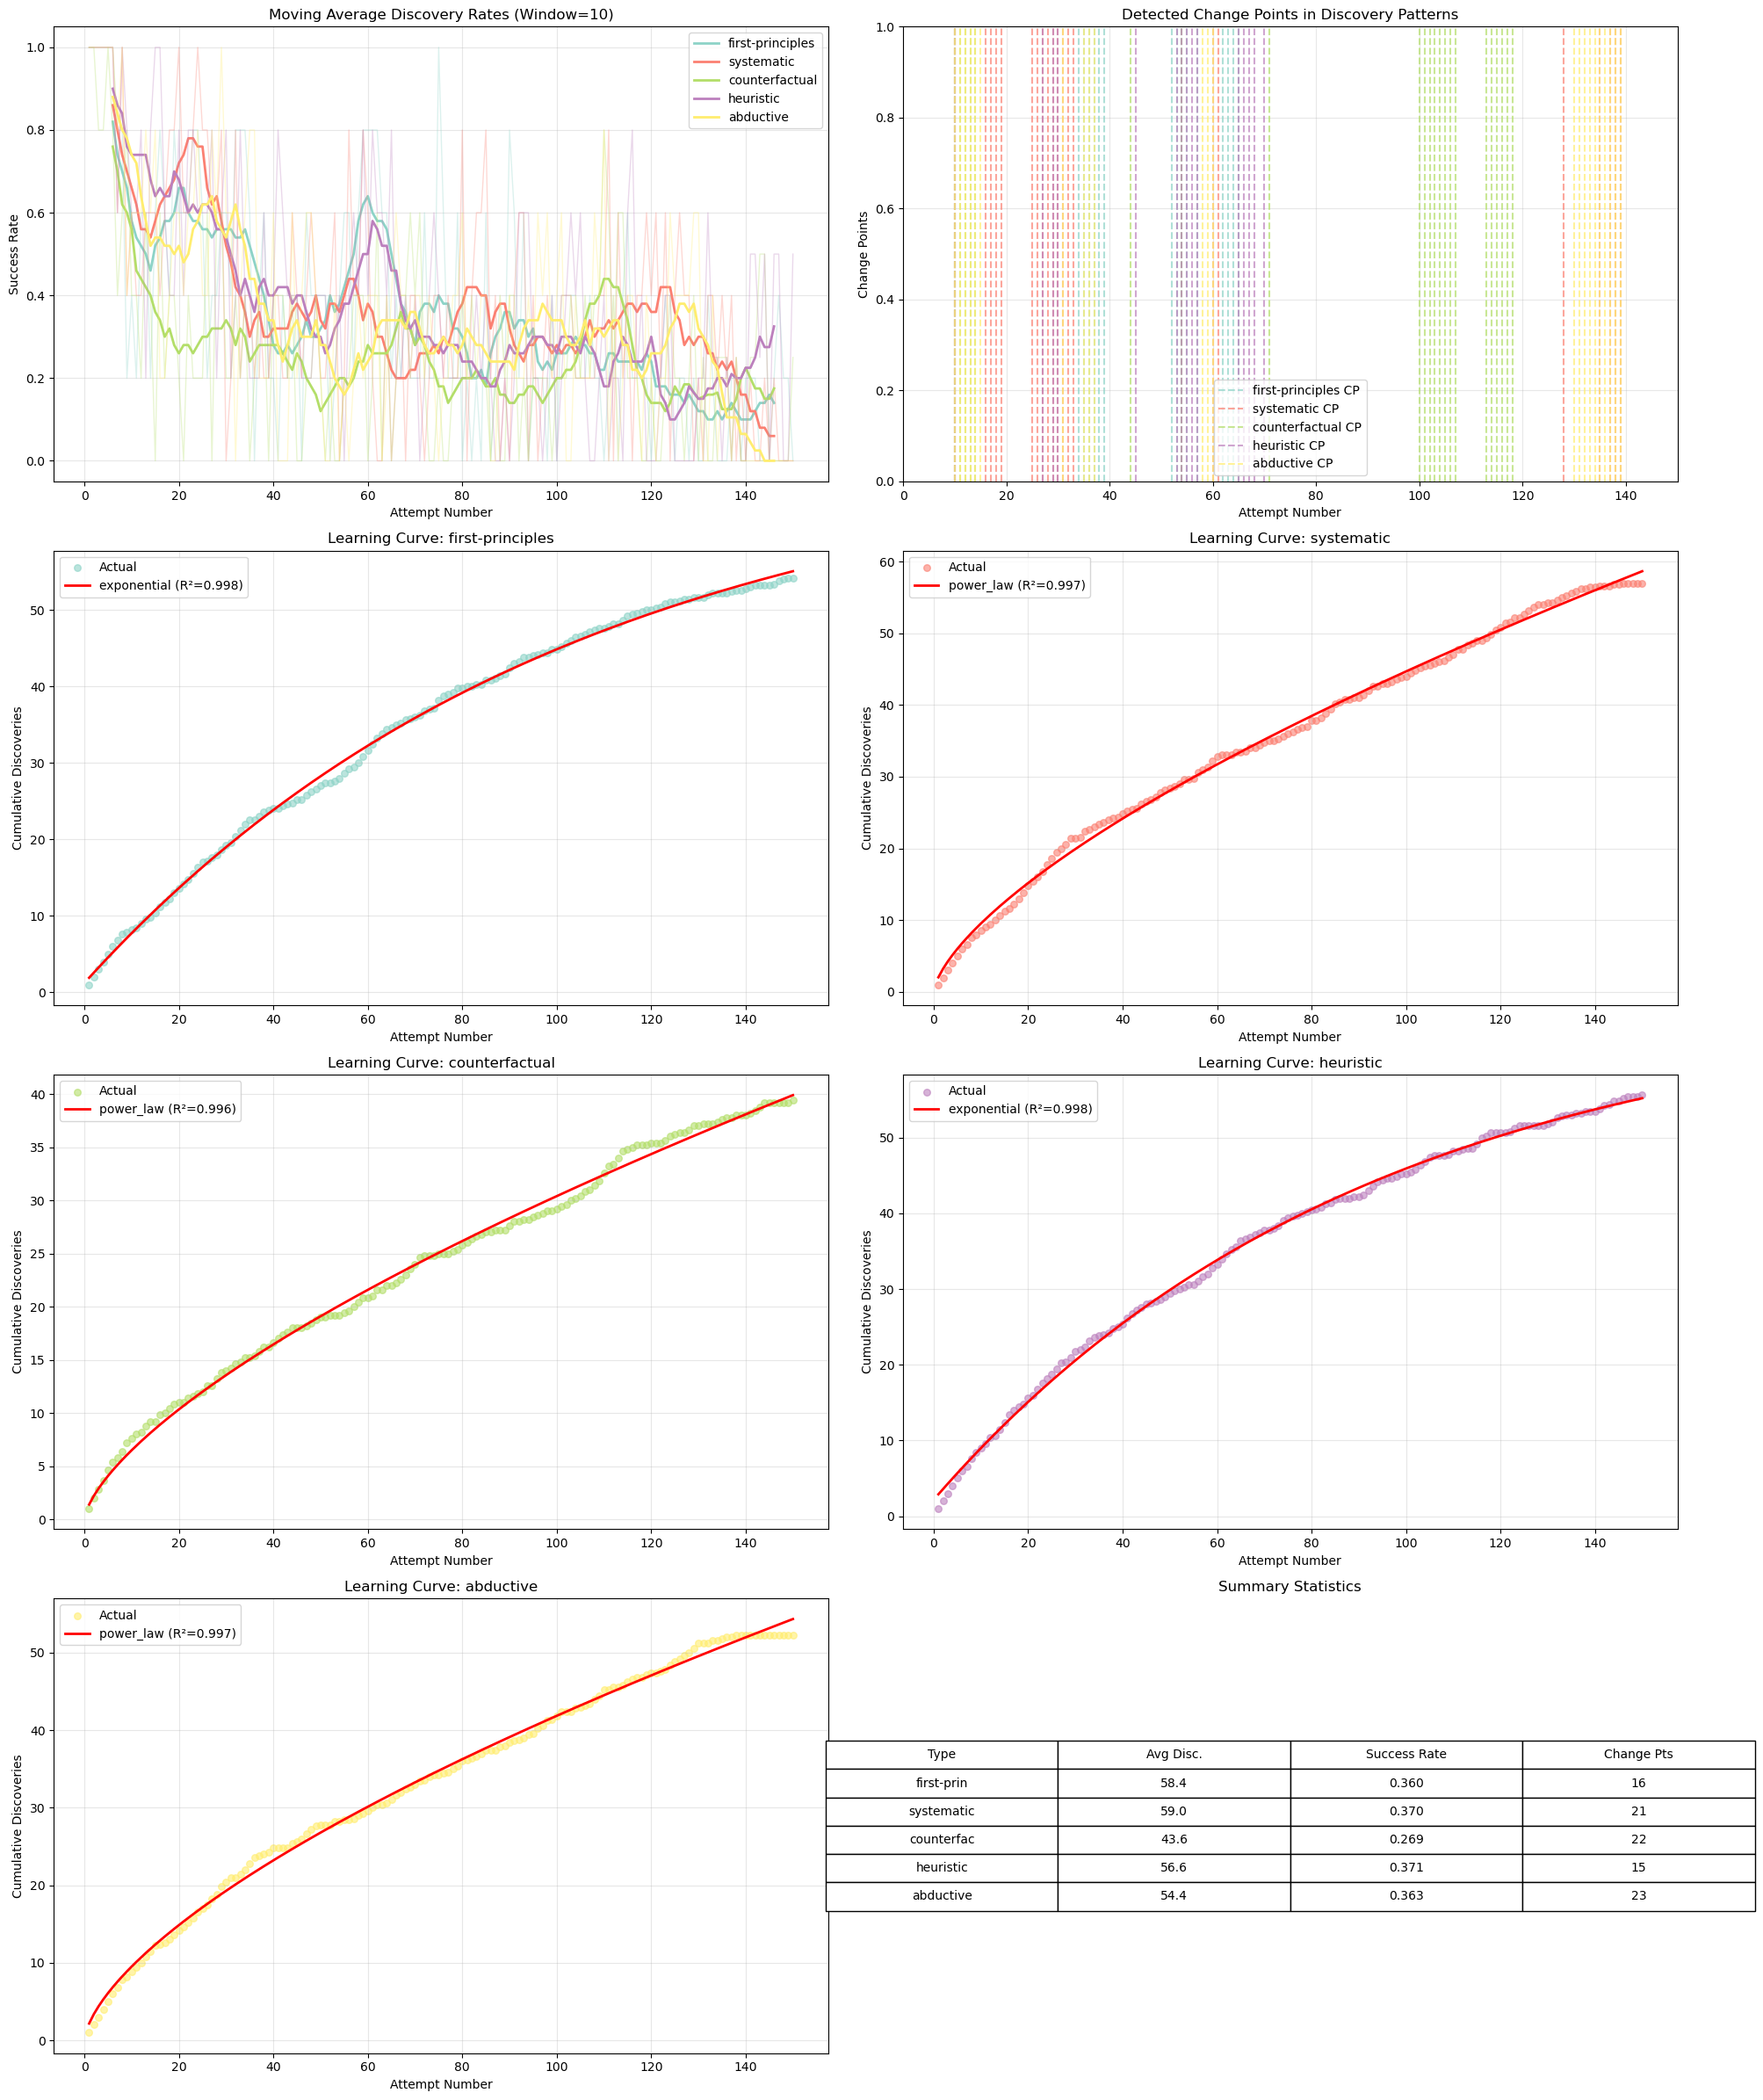

Generating detailed analysis report...

LLM EXPLORATION TIME SERIES ANALYSIS REPORT

=== Analyzing first-principles ===

FIRST-PRINCIPLES
----------------
Average Success Rate: 0.361
Peak Performance: 0.820 at attempt 6
Change Points Detected: 16
Change Point Positions: [10, 34, 35, 36, 37, 38, 39, 52, 53, 54, 55, 57, 62, 63, 64, 65]
Best Learning Curve Model: exponential (R² = 0.998)
Early Learning Rate: 0.520 discoveries/attempt

=== Analyzing systematic ===

SYSTEMATIC
----------
Average Success Rate: 0.380
Peak Performance: 0.860 at attempt 6
Change Points Detected: 21
Change Point Positions: [10, 16, 17, 18, 19, 25, 26, 27, 28, 29, 30, 31, 32, 33, 60, 61, 128, 135, 137, 138, 139]
Best Learning Curve Model: power_law (R² = 0.997)
Early Learning Rate: 0.551 discoveries/attempt

=== Analyzing counterfactual ===

COUNTERFACTUAL
--------------
Average Success Rate: 0.267
Peak Performance: 0.760 at attempt 6
Change Points Detected: 22
Change Point Positions: [10, 11, 12, 13, 14, 44, 54,

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
import warnings
warnings.filterwarnings('ignore')

# Try to import ruptures for change point detection, fall back to manual method if not available
try:
    import ruptures as rpt
    RUPTURES_AVAILABLE = True
except ImportError:
    print("Ruptures not available. Using alternative change point detection method.")
    RUPTURES_AVAILABLE = False

class LLMExplorationTimeSeriesAnalyzer:
    def __init__(self, sessions_file, attempts_file):
        """Initialize the analyzer with data files"""
        self.sessions_df = pd.read_csv(sessions_file)
        self.attempts_df = pd.read_csv(attempts_file)
        self.reasoning_types = self.sessions_df['r_typ'].unique()
        
        # Clean and prepare data
        self._prepare_data()
        
    def _prepare_data(self):
        """Clean and prepare data for analysis"""
        # Convert timestamps if they exist
        if '_datetime' in self.attempts_df.columns:
            self.attempts_df['_datetime'] = pd.to_datetime(self.attempts_df['_datetime'])
        
        # Ensure proper data types
        self.attempts_df['ok'] = self.attempts_df['ok'].astype(bool)
        self.attempts_df['att_n'] = self.attempts_df['att_n'].astype(int)
        
        print(f"Loaded {len(self.sessions_df)} sessions and {len(self.attempts_df)} attempts")
        print(f"Reasoning types: {list(self.reasoning_types)}")
        
    def calculate_moving_averages(self, window_size=10):
        """Calculate moving average discovery rates for each reasoning type"""
        moving_averages = {}
        
        for reasoning_type in self.reasoning_types:
            # Get all attempts for this reasoning type
            sessions_of_type = self.sessions_df[self.sessions_df['r_typ'] == reasoning_type]['sid'].values
            attempts_of_type = self.attempts_df[self.attempts_df['sid'].isin(sessions_of_type)]
            
            if len(attempts_of_type) == 0:
                continue
                
            # Sort by session and attempt number
            attempts_of_type = attempts_of_type.sort_values(['sid', 'att_n'])
            
            # Calculate success rate for each attempt position (1-150)
            max_attempts = attempts_of_type['att_n'].max()
            success_rates = []
            attempt_positions = []
            
            for att_pos in range(1, min(max_attempts + 1, 151)):  # Limit to 150 attempts
                attempts_at_position = attempts_of_type[attempts_of_type['att_n'] == att_pos]
                if len(attempts_at_position) > 0:
                    success_rate = attempts_at_position['ok'].mean()
                    success_rates.append(success_rate)
                    attempt_positions.append(att_pos)
            
            # Calculate moving average
            if len(success_rates) >= window_size:
                moving_avg = pd.Series(success_rates).rolling(window=window_size, center=True).mean()
                moving_averages[reasoning_type] = {
                    'attempt_positions': attempt_positions,
                    'raw_success_rates': success_rates,
                    'moving_average': moving_avg.values
                }
            
        return moving_averages
    
    def detect_change_points(self, reasoning_type, min_size=10):
        """Detect change points in discovery patterns"""
        sessions_of_type = self.sessions_df[self.sessions_df['r_typ'] == reasoning_type]['sid'].values
        attempts_of_type = self.attempts_df[self.attempts_df['sid'].isin(sessions_of_type)]
        
        if len(attempts_of_type) == 0:
            return None
            
        # Aggregate success rates by attempt position
        max_attempts = min(attempts_of_type['att_n'].max(), 150)
        success_rates = []
        
        for att_pos in range(1, max_attempts + 1):
            attempts_at_position = attempts_of_type[attempts_of_type['att_n'] == att_pos]
            if len(attempts_at_position) > 0:
                success_rate = attempts_at_position['ok'].mean()
                success_rates.append(success_rate)
            else:
                success_rates.append(0)
        
        if len(success_rates) < min_size * 2:
            return None
            
        if RUPTURES_AVAILABLE:
            # Use ruptures library for change point detection
            try:
                signal = np.array(success_rates)
                algo = rpt.Pelt(model="rbf").fit(signal)
                change_points = algo.predict(pen=0.1)
                return change_points[:-1]  # Remove the last point (end of series)
            except:
                pass
        
        # Fallback: Simple statistical change point detection
        change_points = []
        window = min_size
        
        for i in range(window, len(success_rates) - window):
            before = success_rates[i-window:i]
            after = success_rates[i:i+window]
            
            # Two-sample t-test
            if len(before) > 1 and len(after) > 1:
                t_stat, p_value = stats.ttest_ind(before, after)
                if p_value < 0.05 and abs(t_stat) > 2:  # Significant change
                    change_points.append(i)
        
        return change_points
    
    def fit_learning_curves(self, reasoning_type):
        """Fit various learning curve models to the data"""
        sessions_of_type = self.sessions_df[self.sessions_df['r_typ'] == reasoning_type]['sid'].values
        attempts_of_type = self.attempts_df[self.attempts_df['sid'].isin(sessions_of_type)]
        
        if len(attempts_of_type) == 0:
            return None
            
        # Calculate cumulative discovery rates
        max_attempts = min(attempts_of_type['att_n'].max(), 150)
        cumulative_discoveries = []
        attempt_positions = []
        
        for att_pos in range(1, max_attempts + 1):
            # Count total unique discoveries up to this point across all sessions
            discoveries_up_to_pos = 0
            session_count = 0
            
            for session_id in sessions_of_type:
                session_attempts = attempts_of_type[
                    (attempts_of_type['sid'] == session_id) & 
                    (attempts_of_type['att_n'] <= att_pos)
                ]
                if len(session_attempts) > 0:
                    discoveries = session_attempts['ok'].sum()
                    discoveries_up_to_pos += discoveries
                    session_count += 1
            
            if session_count > 0:
                avg_discoveries = discoveries_up_to_pos / session_count
                cumulative_discoveries.append(avg_discoveries)
                attempt_positions.append(att_pos)
        
        if len(cumulative_discoveries) < 10:
            return None
            
        x = np.array(attempt_positions)
        y = np.array(cumulative_discoveries)
        
        # Define learning curve models
        def power_law(x, a, b):
            return a * np.power(x, b)
        
        def exponential(x, a, b, c):
            return a * (1 - np.exp(-b * x)) + c
        
        def logarithmic(x, a, b):
            return a * np.log(x + 1) + b
        
        def linear(x, a, b):
            return a * x + b
        
        models = {}
        
        # Fit each model and calculate R²
        try:
            # Power law
            popt, _ = curve_fit(power_law, x, y, maxfev=1000)
            y_pred = power_law(x, *popt)
            r2 = stats.pearsonr(y, y_pred)[0]**2
            models['power_law'] = {'params': popt, 'r2': r2, 'predictions': y_pred}
        except:
            models['power_law'] = None
            
        try:
            # Exponential
            popt, _ = curve_fit(exponential, x, y, maxfev=1000)
            y_pred = exponential(x, *popt)
            r2 = stats.pearsonr(y, y_pred)[0]**2
            models['exponential'] = {'params': popt, 'r2': r2, 'predictions': y_pred}
        except:
            models['exponential'] = None
            
        try:
            # Logarithmic
            popt, _ = curve_fit(logarithmic, x, y, maxfev=1000)
            y_pred = logarithmic(x, *popt)
            r2 = stats.pearsonr(y, y_pred)[0]**2
            models['logarithmic'] = {'params': popt, 'r2': r2, 'predictions': y_pred}
        except:
            models['logarithmic'] = None
            
        try:
            # Linear
            popt, _ = curve_fit(linear, x, y, maxfev=1000)
            y_pred = linear(x, *popt)
            r2 = stats.pearsonr(y, y_pred)[0]**2
            models['linear'] = {'params': popt, 'r2': r2, 'predictions': y_pred}
        except:
            models['linear'] = None
        
        return {
            'x': x,
            'y': y,
            'models': models
        }
    
    def analyze_reasoning_type(self, reasoning_type):
        """Complete analysis for a single reasoning type"""
        print(f"\n=== Analyzing {reasoning_type} ===")
        
        # Moving averages
        moving_avg_data = self.calculate_moving_averages()
        
        # Change points
        change_points = self.detect_change_points(reasoning_type)
        
        # Learning curves
        learning_curves = self.fit_learning_curves(reasoning_type)
        
        return {
            'moving_averages': moving_avg_data.get(reasoning_type),
            'change_points': change_points,
            'learning_curves': learning_curves
        }
    
    def visualize_time_series_analysis(self, save_plots=True):
        """Create comprehensive visualizations for all reasoning types"""
        # Set up the plotting style
        plt.style.use('default')
        sns.set_palette("husl")
        
        # Calculate all moving averages first
        moving_averages = self.calculate_moving_averages(window_size=10)
        
        # Create a large figure with subplots
        fig = plt.figure(figsize=(20, 24))
        
        # 1. Moving Average Discovery Rates
        ax1 = plt.subplot(4, 2, 1)
        colors = plt.cm.Set3(np.linspace(0, 1, len(self.reasoning_types)))
        
        for i, reasoning_type in enumerate(self.reasoning_types):
            if reasoning_type in moving_averages:
                data = moving_averages[reasoning_type]
                # Plot raw data as light line
                ax1.plot(data['attempt_positions'], data['raw_success_rates'], 
                        alpha=0.3, color=colors[i], linewidth=1)
                # Plot moving average as bold line
                ax1.plot(data['attempt_positions'], data['moving_average'], 
                        label=f'{reasoning_type}', color=colors[i], linewidth=2)
        
        ax1.set_xlabel('Attempt Number')
        ax1.set_ylabel('Success Rate')
        ax1.set_title('Moving Average Discovery Rates (Window=10)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Change Points Detection
        ax2 = plt.subplot(4, 2, 2)
        
        for i, reasoning_type in enumerate(self.reasoning_types):
            change_points = self.detect_change_points(reasoning_type)
            if change_points:
                # Plot change points as vertical lines
                for cp in change_points:
                    ax2.axvline(x=cp, color=colors[i], alpha=0.7, linestyle='--', 
                              label=f'{reasoning_type} CP' if cp == change_points[0] else "")
        
        ax2.set_xlabel('Attempt Number')
        ax2.set_ylabel('Change Points')
        ax2.set_title('Detected Change Points in Discovery Patterns')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(0, 150)
        
        # 3-8. Learning Curves for each reasoning type (best fit models)
        subplot_positions = [(4, 2, 3), (4, 2, 4), (4, 2, 5), (4, 2, 6), (4, 2, 7)]
        
        for i, reasoning_type in enumerate(self.reasoning_types[:5]):  # Limit to 5 for space
            if i < len(subplot_positions):
                ax = plt.subplot(*subplot_positions[i])
                learning_data = self.fit_learning_curves(reasoning_type)
                
                if learning_data:
                    x, y = learning_data['x'], learning_data['y']
                    
                    # Plot actual data
                    ax.scatter(x, y, alpha=0.6, color=colors[i], s=30, label='Actual')
                    
                    # Find and plot best model
                    best_model = None
                    best_r2 = -1
                    
                    for model_name, model_data in learning_data['models'].items():
                        if model_data and model_data['r2'] > best_r2:
                            best_r2 = model_data['r2']
                            best_model = (model_name, model_data)
                    
                    if best_model:
                        model_name, model_data = best_model
                        ax.plot(x, model_data['predictions'], 
                               color='red', linewidth=2, 
                               label=f'{model_name} (R²={best_r2:.3f})')
                    
                    ax.set_xlabel('Attempt Number')
                    ax.set_ylabel('Cumulative Discoveries')
                    ax.set_title(f'Learning Curve: {reasoning_type}')
                    ax.legend()
                    ax.grid(True, alpha=0.3)
        
        # 8. Summary Statistics
        ax8 = plt.subplot(4, 2, 8)
        
        # Create a summary table
        summary_data = []
        for reasoning_type in self.reasoning_types:
            sessions_of_type = self.sessions_df[self.sessions_df['r_typ'] == reasoning_type]
            if len(sessions_of_type) > 0:
                avg_discoveries = sessions_of_type['elem_disc'].mean()
                avg_success_rate = sessions_of_type['disc_rate'].mean()
                change_points = self.detect_change_points(reasoning_type)
                num_change_points = len(change_points) if change_points else 0
                
                summary_data.append([
                    reasoning_type[:10],  # Truncate for display
                    f"{avg_discoveries:.1f}",
                    f"{avg_success_rate:.3f}",
                    str(num_change_points)
                ])
        
        # Create table
        table = ax8.table(cellText=summary_data,
                         colLabels=['Type', 'Avg Disc.', 'Success Rate', 'Change Pts'],
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        
        ax8.axis('off')
        ax8.set_title('Summary Statistics')
        
        plt.tight_layout()
        
        if save_plots:
            plt.savefig('llm_exploration_time_series_analysis.png', dpi=300, bbox_inches='tight')
            print("Saved visualization to 'llm_exploration_time_series_analysis.png'")
        
        plt.show()
        
        return fig
    
    def generate_detailed_report(self):
        """Generate a detailed text report of the analysis"""
        print("\n" + "="*80)
        print("LLM EXPLORATION TIME SERIES ANALYSIS REPORT")
        print("="*80)
        
        for reasoning_type in self.reasoning_types:
            analysis = self.analyze_reasoning_type(reasoning_type)
            
            print(f"\n{reasoning_type.upper()}")
            print("-" * len(reasoning_type))
            
            # Moving averages summary
            if analysis['moving_averages']:
                ma_data = analysis['moving_averages']
                avg_success = np.nanmean(ma_data['raw_success_rates'])
                print(f"Average Success Rate: {avg_success:.3f}")
                
                # Find peak performance period
                ma_values = ma_data['moving_average']
                valid_ma = ma_values[~np.isnan(ma_values)]
                if len(valid_ma) > 0:
                    peak_idx = np.nanargmax(ma_values)
                    peak_attempt = ma_data['attempt_positions'][peak_idx] if peak_idx < len(ma_data['attempt_positions']) else "N/A"
                    peak_value = valid_ma.max()
                    print(f"Peak Performance: {peak_value:.3f} at attempt {peak_attempt}")
            
            # Change points
            if analysis['change_points']:
                print(f"Change Points Detected: {len(analysis['change_points'])}")
                print(f"Change Point Positions: {analysis['change_points']}")
            else:
                print("No significant change points detected")
            
            # Learning curve best fit
            if analysis['learning_curves']:
                lc_data = analysis['learning_curves']
                best_model = None
                best_r2 = -1
                
                for model_name, model_data in lc_data['models'].items():
                    if model_data and model_data['r2'] > best_r2:
                        best_r2 = model_data['r2']
                        best_model = model_name
                
                if best_model:
                    print(f"Best Learning Curve Model: {best_model} (R² = {best_r2:.3f})")
                    
                    # Calculate learning rate (slope of first 50 attempts)
                    early_x = lc_data['x'][:50] if len(lc_data['x']) >= 50 else lc_data['x']
                    early_y = lc_data['y'][:50] if len(lc_data['y']) >= 50 else lc_data['y']
                    if len(early_x) > 1:
                        slope, _, _, _, _ = stats.linregress(early_x, early_y)
                        print(f"Early Learning Rate: {slope:.3f} discoveries/attempt")

def main():
    """Main function to run the analysis"""
    # Initialize the analyzer
    # Replace these with your actual file paths
    analyzer = LLMExplorationTimeSeriesAnalyzer(
        'tests/all_sessions_data.csv', 
        'tests/all_attempts_data.csv'
    )
    
    # Generate visualizations
    print("Generating time series visualizations...")
    analyzer.visualize_time_series_analysis(save_plots=True)
    
    # Generate detailed report
    print("Generating detailed analysis report...")
    analyzer.generate_detailed_report()
    
    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()

Data loaded successfully!
Sessions: 25
Attempts: 3658
Reasoning types: ['first-principles' 'systematic' 'counterfactual' 'heuristic' 'abductive']


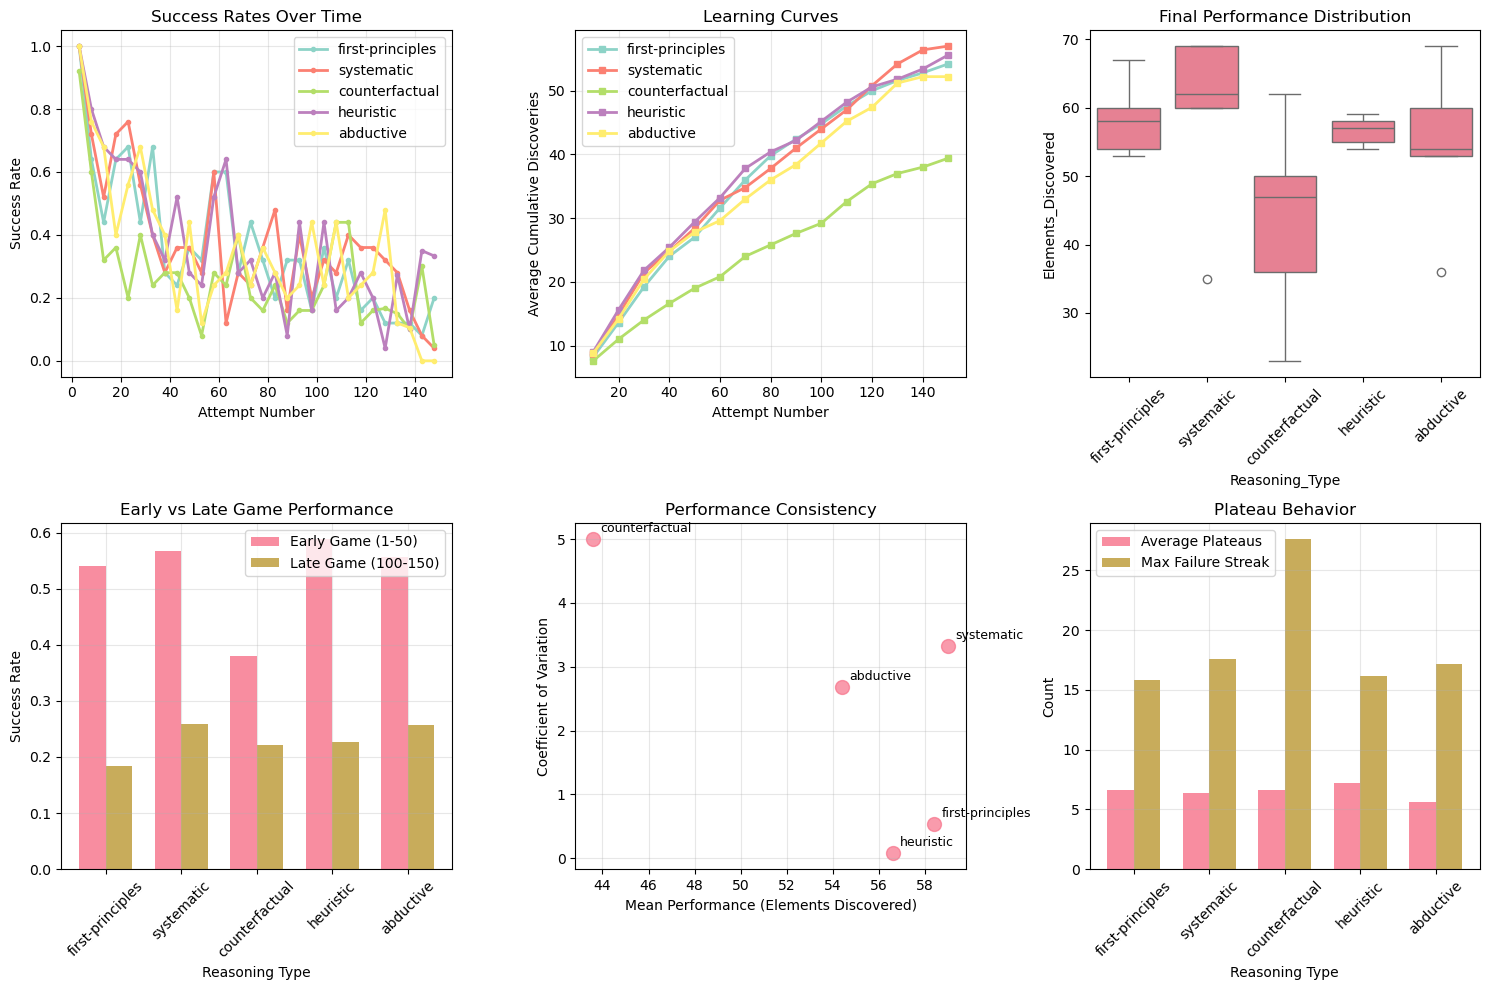


QUICK ANALYSIS SUMMARY

first-principles:
  Sessions: 5
  Avg Elements Discovered: 58.4 ± 5.6
  Avg Success Rate: 0.360
  Avg Plateaus: 6.6
  Avg Max Failure Streak: 15.8

systematic:
  Sessions: 5
  Avg Elements Discovered: 59.0 ± 14.0
  Avg Success Rate: 0.370
  Avg Plateaus: 6.4
  Avg Max Failure Streak: 17.6

counterfactual:
  Sessions: 5
  Avg Elements Discovered: 43.6 ± 14.8
  Avg Success Rate: 0.269
  Avg Plateaus: 6.6
  Avg Max Failure Streak: 27.6

heuristic:
  Sessions: 5
  Avg Elements Discovered: 56.6 ± 2.1
  Avg Success Rate: 0.371
  Avg Plateaus: 7.2
  Avg Max Failure Streak: 16.2

abductive:
  Sessions: 5
  Avg Elements Discovered: 54.4 ± 12.1
  Avg Success Rate: 0.363
  Avg Plateaus: 5.6
  Avg Max Failure Streak: 17.2


In [36]:
# Quick usage example and simplified analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simple usage of the main script
def run_quick_analysis():
    """Quick version of the analysis for immediate results"""
    
    # Load data
    sessions_df = pd.read_csv('tests/all_sessions_data.csv')
    attempts_df = pd.read_csv('tests/all_attempts_data.csv')
    
    print("Data loaded successfully!")
    print(f"Sessions: {len(sessions_df)}")
    print(f"Attempts: {len(attempts_df)}")
    print(f"Reasoning types: {sessions_df['r_typ'].unique()}")
    
    # Quick moving average analysis
    reasoning_types = sessions_df['r_typ'].unique()
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Success rates over attempts for each reasoning type
    plt.subplot(2, 3, 1)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(reasoning_types)))
    
    for i, reasoning_type in enumerate(reasoning_types):
        # Get sessions of this type
        sessions_of_type = sessions_df[sessions_df['r_typ'] == reasoning_type]['sid'].values
        attempts_of_type = attempts_df[attempts_df['sid'].isin(sessions_of_type)]
        
        # Calculate success rate by attempt position
        max_attempts = min(150, attempts_of_type['att_n'].max())
        success_rates = []
        attempt_positions = []
        
        for att_pos in range(1, max_attempts + 1, 5):  # Every 5th attempt for smoother plot
            attempts_at_pos = attempts_of_type[
                (attempts_of_type['att_n'] >= att_pos) & 
                (attempts_of_type['att_n'] < att_pos + 5)
            ]
            if len(attempts_at_pos) > 0:
                success_rate = attempts_at_pos['ok'].mean()
                success_rates.append(success_rate)
                attempt_positions.append(att_pos + 2)  # Middle of range
        
        if len(success_rates) > 0:
            plt.plot(attempt_positions, success_rates, 
                    label=reasoning_type, color=colors[i], linewidth=2, marker='o', markersize=3)
    
    plt.xlabel('Attempt Number')
    plt.ylabel('Success Rate')
    plt.title('Success Rates Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Cumulative discoveries
    plt.subplot(2, 3, 2)
    
    for i, reasoning_type in enumerate(reasoning_types):
        sessions_of_type = sessions_df[sessions_df['r_typ'] == reasoning_type]['sid'].values
        attempts_of_type = attempts_df[attempts_df['sid'].isin(sessions_of_type)]
        
        # Average cumulative discoveries across sessions
        cumulative_avg = []
        attempt_positions = []
        
        for att_pos in range(10, 151, 10):  # Every 10 attempts
            session_discoveries = []
            for session_id in sessions_of_type:
                session_attempts = attempts_of_type[
                    (attempts_of_type['sid'] == session_id) & 
                    (attempts_of_type['att_n'] <= att_pos)
                ]
                if len(session_attempts) > 0:
                    discoveries = session_attempts['ok'].sum()
                    session_discoveries.append(discoveries)
            
            if len(session_discoveries) > 0:
                avg_discoveries = np.mean(session_discoveries)
                cumulative_avg.append(avg_discoveries)
                attempt_positions.append(att_pos)
        
        if len(cumulative_avg) > 0:
            plt.plot(attempt_positions, cumulative_avg, 
                    label=reasoning_type, color=colors[i], linewidth=2, marker='s', markersize=4)
    
    plt.xlabel('Attempt Number')
    plt.ylabel('Average Cumulative Discoveries')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Distribution of final performance
    plt.subplot(2, 3, 3)
    
    final_performances = []
    type_labels = []
    
    for reasoning_type in reasoning_types:
        type_sessions = sessions_df[sessions_df['r_typ'] == reasoning_type]
        performances = type_sessions['elem_disc'].values
        final_performances.extend(performances)
        type_labels.extend([reasoning_type] * len(performances))
    
    performance_df = pd.DataFrame({
        'Elements_Discovered': final_performances,
        'Reasoning_Type': type_labels
    })
    
    sns.boxplot(data=performance_df, x='Reasoning_Type', y='Elements_Discovered')
    plt.xticks(rotation=45)
    plt.title('Final Performance Distribution')
    plt.tight_layout()
    
    # Plot 4: Early vs Late game performance
    plt.subplot(2, 3, 4)
    
    early_late_data = []
    
    for reasoning_type in reasoning_types:
        sessions_of_type = sessions_df[sessions_df['r_typ'] == reasoning_type]['sid'].values
        attempts_of_type = attempts_df[attempts_df['sid'].isin(sessions_of_type)]
        
        # Early game (attempts 1-50)
        early_attempts = attempts_of_type[attempts_of_type['att_n'] <= 50]
        early_success = early_attempts['ok'].mean() if len(early_attempts) > 0 else 0
        
        # Late game (attempts 100-150)
        late_attempts = attempts_of_type[attempts_of_type['att_n'] >= 100]
        late_success = late_attempts['ok'].mean() if len(late_attempts) > 0 else 0
        
        early_late_data.append({
            'Reasoning_Type': reasoning_type,
            'Early_Game': early_success,
            'Late_Game': late_success
        })
    
    early_late_df = pd.DataFrame(early_late_data)
    
    x = np.arange(len(reasoning_types))
    width = 0.35
    
    plt.bar(x - width/2, early_late_df['Early_Game'], width, 
            label='Early Game (1-50)', alpha=0.8)
    plt.bar(x + width/2, early_late_df['Late_Game'], width, 
            label='Late Game (100-150)', alpha=0.8)
    
    plt.xlabel('Reasoning Type')
    plt.ylabel('Success Rate')
    plt.title('Early vs Late Game Performance')
    plt.xticks(x, reasoning_types, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Session consistency (variance in performance)
    plt.subplot(2, 3, 5)
    
    consistency_data = []
    for reasoning_type in reasoning_types:
        type_sessions = sessions_df[sessions_df['r_typ'] == reasoning_type]
        if len(type_sessions) > 1:
            variance = type_sessions['elem_disc'].var()
            mean_performance = type_sessions['elem_disc'].mean()
            cv = variance / mean_performance if mean_performance > 0 else 0  # Coefficient of variation
            consistency_data.append({
                'Reasoning_Type': reasoning_type,
                'Coefficient_of_Variation': cv,
                'Mean_Performance': mean_performance
            })
    
    if consistency_data:
        consistency_df = pd.DataFrame(consistency_data)
        plt.scatter(consistency_df['Mean_Performance'], 
                   consistency_df['Coefficient_of_Variation'],
                   s=100, alpha=0.7)
        
        for i, row in consistency_df.iterrows():
            plt.annotate(row['Reasoning_Type'], 
                        (row['Mean_Performance'], row['Coefficient_of_Variation']),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        plt.xlabel('Mean Performance (Elements Discovered)')
        plt.ylabel('Coefficient of Variation')
        plt.title('Performance Consistency')
        plt.grid(True, alpha=0.3)
    
    # Plot 6: Plateau analysis
    plt.subplot(2, 3, 6)
    
    plateau_data = []
    for reasoning_type in reasoning_types:
        type_sessions = sessions_df[sessions_df['r_typ'] == reasoning_type]
        avg_plateaus = type_sessions['plateaus'].mean()
        avg_max_fail = type_sessions['max_fail'].mean()
        plateau_data.append({
            'Reasoning_Type': reasoning_type,
            'Avg_Plateaus': avg_plateaus,
            'Avg_Max_Fail_Streak': avg_max_fail
        })
    
    plateau_df = pd.DataFrame(plateau_data)
    
    x = np.arange(len(reasoning_types))
    width = 0.35
    
    plt.bar(x - width/2, plateau_df['Avg_Plateaus'], width, 
            label='Average Plateaus', alpha=0.8)
    plt.bar(x + width/2, plateau_df['Avg_Max_Fail_Streak'], width, 
            label='Max Failure Streak', alpha=0.8)
    
    plt.xlabel('Reasoning Type')
    plt.ylabel('Count')
    plt.title('Plateau Behavior')
    plt.xticks(x, reasoning_types, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('quick_time_series_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("QUICK ANALYSIS SUMMARY")
    print("="*60)
    
    for reasoning_type in reasoning_types:
        type_sessions = sessions_df[sessions_df['r_typ'] == reasoning_type]
        print(f"\n{reasoning_type}:")
        print(f"  Sessions: {len(type_sessions)}")
        print(f"  Avg Elements Discovered: {type_sessions['elem_disc'].mean():.1f} ± {type_sessions['elem_disc'].std():.1f}")
        print(f"  Avg Success Rate: {type_sessions['disc_rate'].mean():.3f}")
        print(f"  Avg Plateaus: {type_sessions['plateaus'].mean():.1f}")
        print(f"  Avg Max Failure Streak: {type_sessions['max_fail'].mean():.1f}")

# To run the full analysis, use:
if __name__ == "__main__":
    # Quick analysis
    run_quick_analysis()
    
    # For full analysis, uncomment below:
    # LLMExplorationTimeSeriesAnalyzer is already defined above in this notebook
    # analyzer = LLMExplorationTimeSeriesAnalyzer('tests/all_sessions_data.csv', 'tests/all_attempts_data.csv')
    # analyzer.visualize_time_series_analysis(save_plots=True)
    # analyzer.generate_detailed_report()

Loading data...
Creating networks and calculating metrics...
Generating visualizations...
NETWORK ANALYSIS REPORT

1. NETWORK SIZE COMPARISON
----------------------------------------
systematic      | Nodes:  75 | Edges: 374
first-principles | Nodes:  74 | Edges: 335
counterfactual  | Nodes:  65 | Edges: 405
abductive       | Nodes:  64 | Edges: 328
heuristic       | Nodes:  59 | Edges: 295

2. NETWORK STRUCTURE ANALYSIS
----------------------------------------

counterfactual:
  Density: 0.1947
  Clustering: 0.5770
  Components: 4
  Avg Path Length: 1.9519

systematic:
  Density: 0.1348
  Clustering: 0.4706
  Components: 5
  Avg Path Length: 2.1203

abductive:
  Density: 0.1627
  Clustering: 0.5654
  Components: 4
  Avg Path Length: 2.0650

heuristic:
  Density: 0.1724
  Clustering: 0.4663
  Components: 4
  Avg Path Length: 2.0877

first-principles:
  Density: 0.1240
  Clustering: 0.4369
  Components: 2
  Avg Path Length: 2.2297

3. SUCCESS PATTERN ANALYSIS
---------------------------

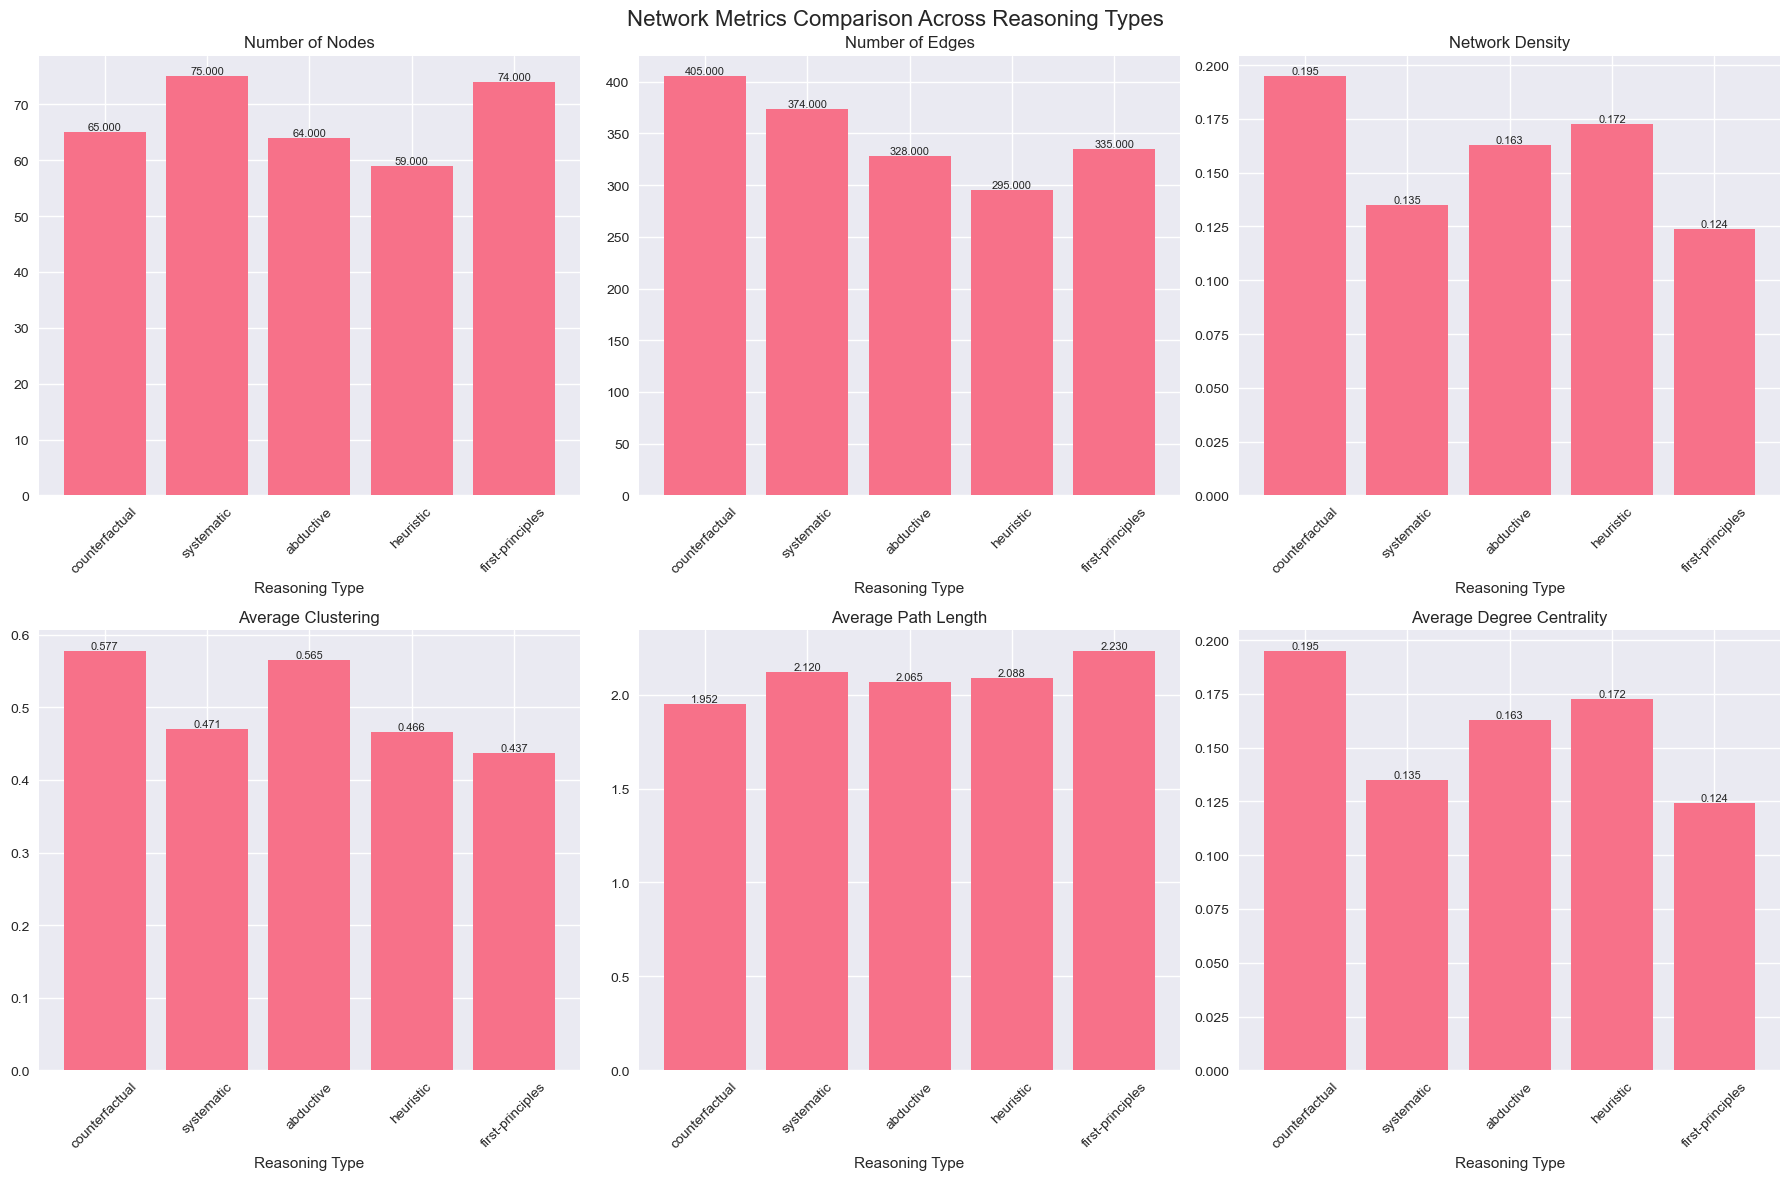

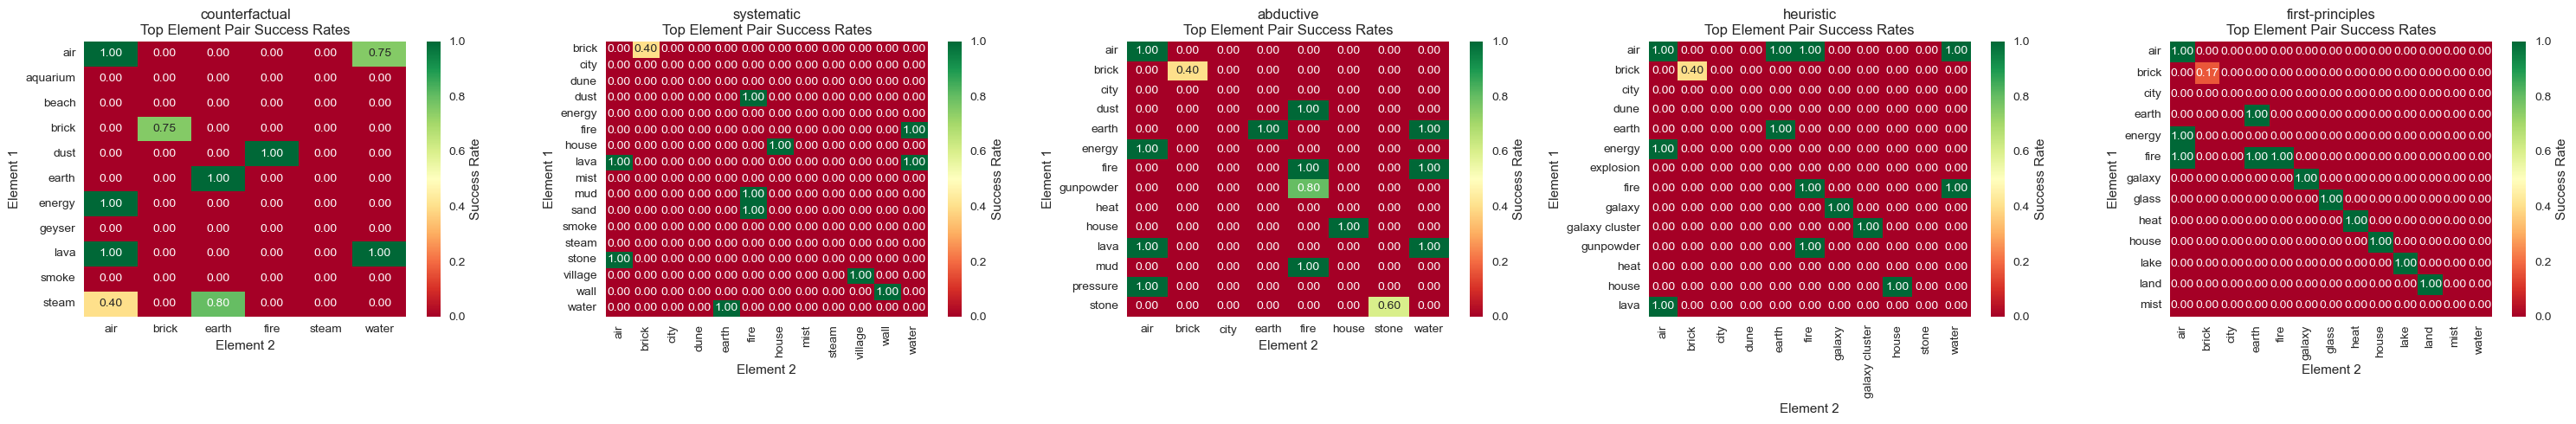

In [37]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_data():
    """Load the attempts and sessions data"""
    attempts_df = pd.read_csv('tests/all_attempts_data.csv')
    sessions_df = pd.read_csv('tests/all_sessions_data.csv')
    
    # Merge to get reasoning type for each attempt
    attempts_with_reasoning = attempts_df.merge(
        sessions_df[['sid', 'r_typ']], 
        on='sid', 
        how='left'
    )
    
    return attempts_with_reasoning, sessions_df

def create_exploration_network(attempts, reasoning_type=None):
    """
    Create a network graph from exploration attempts
    
    Parameters:
    attempts: DataFrame with attempt data
    reasoning_type: Filter by specific reasoning type if provided
    
    Returns:
    NetworkX Graph object
    """
    if reasoning_type:
        attempts = attempts[attempts['r_typ'] == reasoning_type].copy()
    
    G = nx.Graph()
    
    # Track edge weights and attempt counts
    edge_data = defaultdict(lambda: {'success_count': 0, 'total_count': 0, 'weight': 0})
    
    for _, attempt in attempts.iterrows():
        e1, e2 = attempt['e1'], attempt['e2']
        success = attempt['ok']
        
        # Sort elements to ensure consistent edge representation
        edge = tuple(sorted([e1, e2]))
        
        edge_data[edge]['total_count'] += 1
        if success:
            edge_data[edge]['success_count'] += 1
        
        # Weight is success rate for this edge
        edge_data[edge]['weight'] = edge_data[edge]['success_count'] / edge_data[edge]['total_count']
    
    # Add edges to graph
    for (e1, e2), data in edge_data.items():
        G.add_edge(e1, e2, 
                  weight=data['weight'],
                  success_count=data['success_count'],
                  total_count=data['total_count'],
                  success_rate=data['weight'])
    
    return G

def calculate_network_metrics(G, reasoning_type="Unknown"):
    """Calculate various network metrics"""
    if len(G.nodes()) == 0:
        return {}
    
    metrics = {
        'reasoning_type': reasoning_type,
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_clustering': nx.average_clustering(G),
        'num_components': nx.number_connected_components(G),
    }
    
    if nx.is_connected(G):
        metrics['avg_path_length'] = nx.average_shortest_path_length(G)
        metrics['diameter'] = nx.diameter(G)
    else:
        # For disconnected graphs, calculate for largest component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        if len(subgraph) > 1:
            metrics['avg_path_length'] = nx.average_shortest_path_length(subgraph)
            metrics['diameter'] = nx.diameter(subgraph)
        else:
            metrics['avg_path_length'] = 0
            metrics['diameter'] = 0
    
    # Calculate centrality measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    
    metrics['avg_degree_centrality'] = np.mean(list(degree_centrality.values()))
    metrics['avg_betweenness_centrality'] = np.mean(list(betweenness_centrality.values()))
    metrics['avg_eigenvector_centrality'] = np.mean(list(eigenvector_centrality.values()))
    
    # Find most central elements
    metrics['top_degree_elements'] = sorted(degree_centrality.items(), 
                                          key=lambda x: x[1], reverse=True)[:5]
    metrics['top_betweenness_elements'] = sorted(betweenness_centrality.items(), 
                                               key=lambda x: x[1], reverse=True)[:5]
    
    return metrics

def analyze_success_patterns(G, reasoning_type="Unknown"):
    """Analyze success patterns in the network"""
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    success_counts = [G[u][v]['success_count'] for u, v in G.edges()]
    total_counts = [G[u][v]['total_count'] for u, v in G.edges()]
    
    analysis = {
        'reasoning_type': reasoning_type,
        'avg_success_rate': np.mean(edge_weights) if edge_weights else 0,
        'median_success_rate': np.median(edge_weights) if edge_weights else 0,
        'std_success_rate': np.std(edge_weights) if edge_weights else 0,
        'total_successful_combinations': sum(success_counts),
        'total_attempts': sum(total_counts),
        'unique_successful_combinations': sum(1 for w in edge_weights if w > 0),
        'unique_attempted_combinations': len(edge_weights)
    }
    
    return analysis

def visualize_network(G, reasoning_type="Unknown", max_nodes=50):
    """Visualize the exploration network"""
    # For large networks, show only the most connected nodes
    if len(G.nodes()) > max_nodes:
        # Get nodes with highest degree
        degrees = dict(G.degree())
        top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
        top_node_names = [node for node, _ in top_nodes]
        G = G.subgraph(top_node_names)
    
    plt.figure(figsize=(12, 8))
    
    # Position nodes using spring layout
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Draw nodes
    degrees = dict(G.degree())
    node_sizes = [degrees[node] * 100 + 100 for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, 
                          node_size=node_sizes,
                          node_color='lightblue',
                          alpha=0.7)
    
    # Draw edges with weights representing success rates
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    
    # Color edges by success rate
    nx.draw_networkx_edges(G, pos,
                          width=[w * 3 + 0.5 for w in weights],
                          edge_color=weights,
                          edge_cmap=plt.cm.RdYlGn,
                          alpha=0.6)
    
    # Draw labels for most important nodes
    important_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
    labels = {node: node for node, _ in important_nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title(f'Element Interaction Network - {reasoning_type}')
    plt.axis('off')
    plt.tight_layout()
    
    return plt.gcf()

def compare_network_metrics(networks_dict):
    """Compare network metrics across reasoning types"""
    metrics_list = []
    
    for reasoning_type, G in networks_dict.items():
        metrics = calculate_network_metrics(G, reasoning_type)
        metrics_list.append(metrics)
    
    metrics_df = pd.DataFrame(metrics_list)
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Network Metrics Comparison Across Reasoning Types', fontsize=16)
    
    # Plot key metrics
    metrics_to_plot = [
        ('num_nodes', 'Number of Nodes'),
        ('num_edges', 'Number of Edges'),
        ('density', 'Network Density'),
        ('avg_clustering', 'Average Clustering'),
        ('avg_path_length', 'Average Path Length'),
        ('avg_degree_centrality', 'Average Degree Centrality')
    ]
    
    for i, (metric, title) in enumerate(metrics_to_plot):
        ax = axes[i // 3, i % 3]
        if metric in metrics_df.columns:
            bars = ax.bar(metrics_df['reasoning_type'], metrics_df[metric])
            ax.set_title(title)
            ax.set_xlabel('Reasoning Type')
            ax.tick_params(axis='x', rotation=45)
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                if not np.isnan(height):
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.3f}',
                           ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    return fig, metrics_df

def analyze_exploration_patterns(attempts_df):
    """Analyze exploration patterns across reasoning types"""
    reasoning_types = attempts_df['r_typ'].unique()
    
    # Create networks for each reasoning type
    networks = {}
    for reasoning_type in reasoning_types:
        if pd.notna(reasoning_type):  # Skip NaN values
            networks[reasoning_type] = create_exploration_network(attempts_df, reasoning_type)
    
    # Calculate metrics for each network
    all_metrics = []
    success_patterns = []
    
    for reasoning_type, G in networks.items():
        metrics = calculate_network_metrics(G, reasoning_type)
        all_metrics.append(metrics)
        
        success_analysis = analyze_success_patterns(G, reasoning_type)
        success_patterns.append(success_analysis)
    
    return networks, all_metrics, success_patterns

def create_success_rate_heatmap(attempts_df):
    """Create a heatmap of success rates by element pairs for each reasoning type"""
    reasoning_types = attempts_df['r_typ'].unique()
    reasoning_types = [rt for rt in reasoning_types if pd.notna(rt)]
    
    fig, axes = plt.subplots(1, len(reasoning_types), figsize=(6*len(reasoning_types), 5))
    if len(reasoning_types) == 1:
        axes = [axes]
    
    for i, reasoning_type in enumerate(reasoning_types):
        data = attempts_df[attempts_df['r_typ'] == reasoning_type]
        
        # Calculate success rates for element pairs
        pair_stats = data.groupby(['e1', 'e2']).agg({
            'ok': ['sum', 'count']
        }).reset_index()
        
        pair_stats.columns = ['e1', 'e2', 'successes', 'attempts']
        pair_stats['success_rate'] = pair_stats['successes'] / pair_stats['attempts']
        
        # Get top element pairs by frequency
        top_pairs = pair_stats.nlargest(20, 'attempts')
        
        # Create pivot table for heatmap
        pivot_data = top_pairs.pivot_table(
            index='e1', 
            columns='e2', 
            values='success_rate', 
            fill_value=0
        )
        
        sns.heatmap(pivot_data, 
                   annot=True, 
                   cmap='RdYlGn', 
                   fmt='.2f',
                   ax=axes[i],
                   cbar_kws={'label': 'Success Rate'})
        
        axes[i].set_title(f'{reasoning_type}\nTop Element Pair Success Rates')
        axes[i].set_xlabel('Element 2')
        axes[i].set_ylabel('Element 1')
    
    plt.tight_layout()
    return fig

def generate_network_report(networks, all_metrics, success_patterns):
    """Generate a comprehensive network analysis report"""
    print("=" * 80)
    print("NETWORK ANALYSIS REPORT")
    print("=" * 80)
    
    # Summary statistics
    print("\n1. NETWORK SIZE COMPARISON")
    print("-" * 40)
    for metrics in sorted(all_metrics, key=lambda x: x['num_nodes'], reverse=True):
        print(f"{metrics['reasoning_type']:15} | Nodes: {metrics['num_nodes']:3d} | Edges: {metrics['num_edges']:3d}")
    
    # Network structure analysis
    print("\n2. NETWORK STRUCTURE ANALYSIS")
    print("-" * 40)
    for metrics in all_metrics:
        rt = metrics['reasoning_type']
        print(f"\n{rt}:")
        print(f"  Density: {metrics['density']:.4f}")
        print(f"  Clustering: {metrics['avg_clustering']:.4f}")
        print(f"  Components: {metrics['num_components']}")
        if 'avg_path_length' in metrics:
            print(f"  Avg Path Length: {metrics['avg_path_length']:.4f}")
    
    # Success pattern analysis
    print("\n3. SUCCESS PATTERN ANALYSIS")
    print("-" * 40)
    for pattern in success_patterns:
        rt = pattern['reasoning_type']
        print(f"\n{rt}:")
        print(f"  Success Rate: {pattern['avg_success_rate']:.4f}")
        print(f"  Successful Combinations: {pattern['unique_successful_combinations']}")
        print(f"  Total Combinations Tried: {pattern['unique_attempted_combinations']}")
        efficiency = pattern['unique_successful_combinations'] / pattern['unique_attempted_combinations'] if pattern['unique_attempted_combinations'] > 0 else 0
        print(f"  Exploration Efficiency: {efficiency:.4f}")
    
    # Central elements analysis
    print("\n4. MOST CENTRAL ELEMENTS BY REASONING TYPE")
    print("-" * 40)
    for metrics in all_metrics:
        rt = metrics['reasoning_type']
        print(f"\n{rt} - Top Degree Centrality:")
        for elem, centrality in metrics['top_degree_elements']:
            print(f"  {elem}: {centrality:.4f}")

def main():
    """Main analysis function"""
    print("Loading data...")
    attempts_df, sessions_df = load_data()
    
    print("Creating networks and calculating metrics...")
    networks, all_metrics, success_patterns = analyze_exploration_patterns(attempts_df)
    
    print("Generating visualizations...")
    
    # 1. Network comparison metrics
    comparison_fig, metrics_df = compare_network_metrics(networks)
    comparison_fig.savefig('network_metrics_comparison.png', dpi=300, bbox_inches='tight')
    
    # 2. Individual network visualizations
    for reasoning_type, G in networks.items():
        fig = visualize_network(G, reasoning_type)
        fig.savefig(f'network_{reasoning_type.replace(" ", "_").lower()}.png', 
                   dpi=300, bbox_inches='tight')
        plt.close(fig)
    
    # 3. Success rate heatmaps
    heatmap_fig = create_success_rate_heatmap(attempts_df)
    heatmap_fig.savefig('success_rate_heatmaps.png', dpi=300, bbox_inches='tight')
    
    # 4. Generate comprehensive report
    generate_network_report(networks, all_metrics, success_patterns)
    
    # 5. Save metrics to CSV for further analysis
    pd.DataFrame(all_metrics).to_csv('network_metrics.csv', index=False)
    pd.DataFrame(success_patterns).to_csv('success_patterns.csv', index=False)
    
    print("\nAnalysis complete! Check the generated files:")
    print("- network_metrics_comparison.png")
    print("- network_[reasoning_type].png (for each reasoning type)")
    print("- success_rate_heatmaps.png")
    print("- network_metrics.csv")
    print("- success_patterns.csv")
    
    return networks, all_metrics, success_patterns, metrics_df

if __name__ == "__main__":
    networks, all_metrics, success_patterns, metrics_df = main()